# spatial-temporal

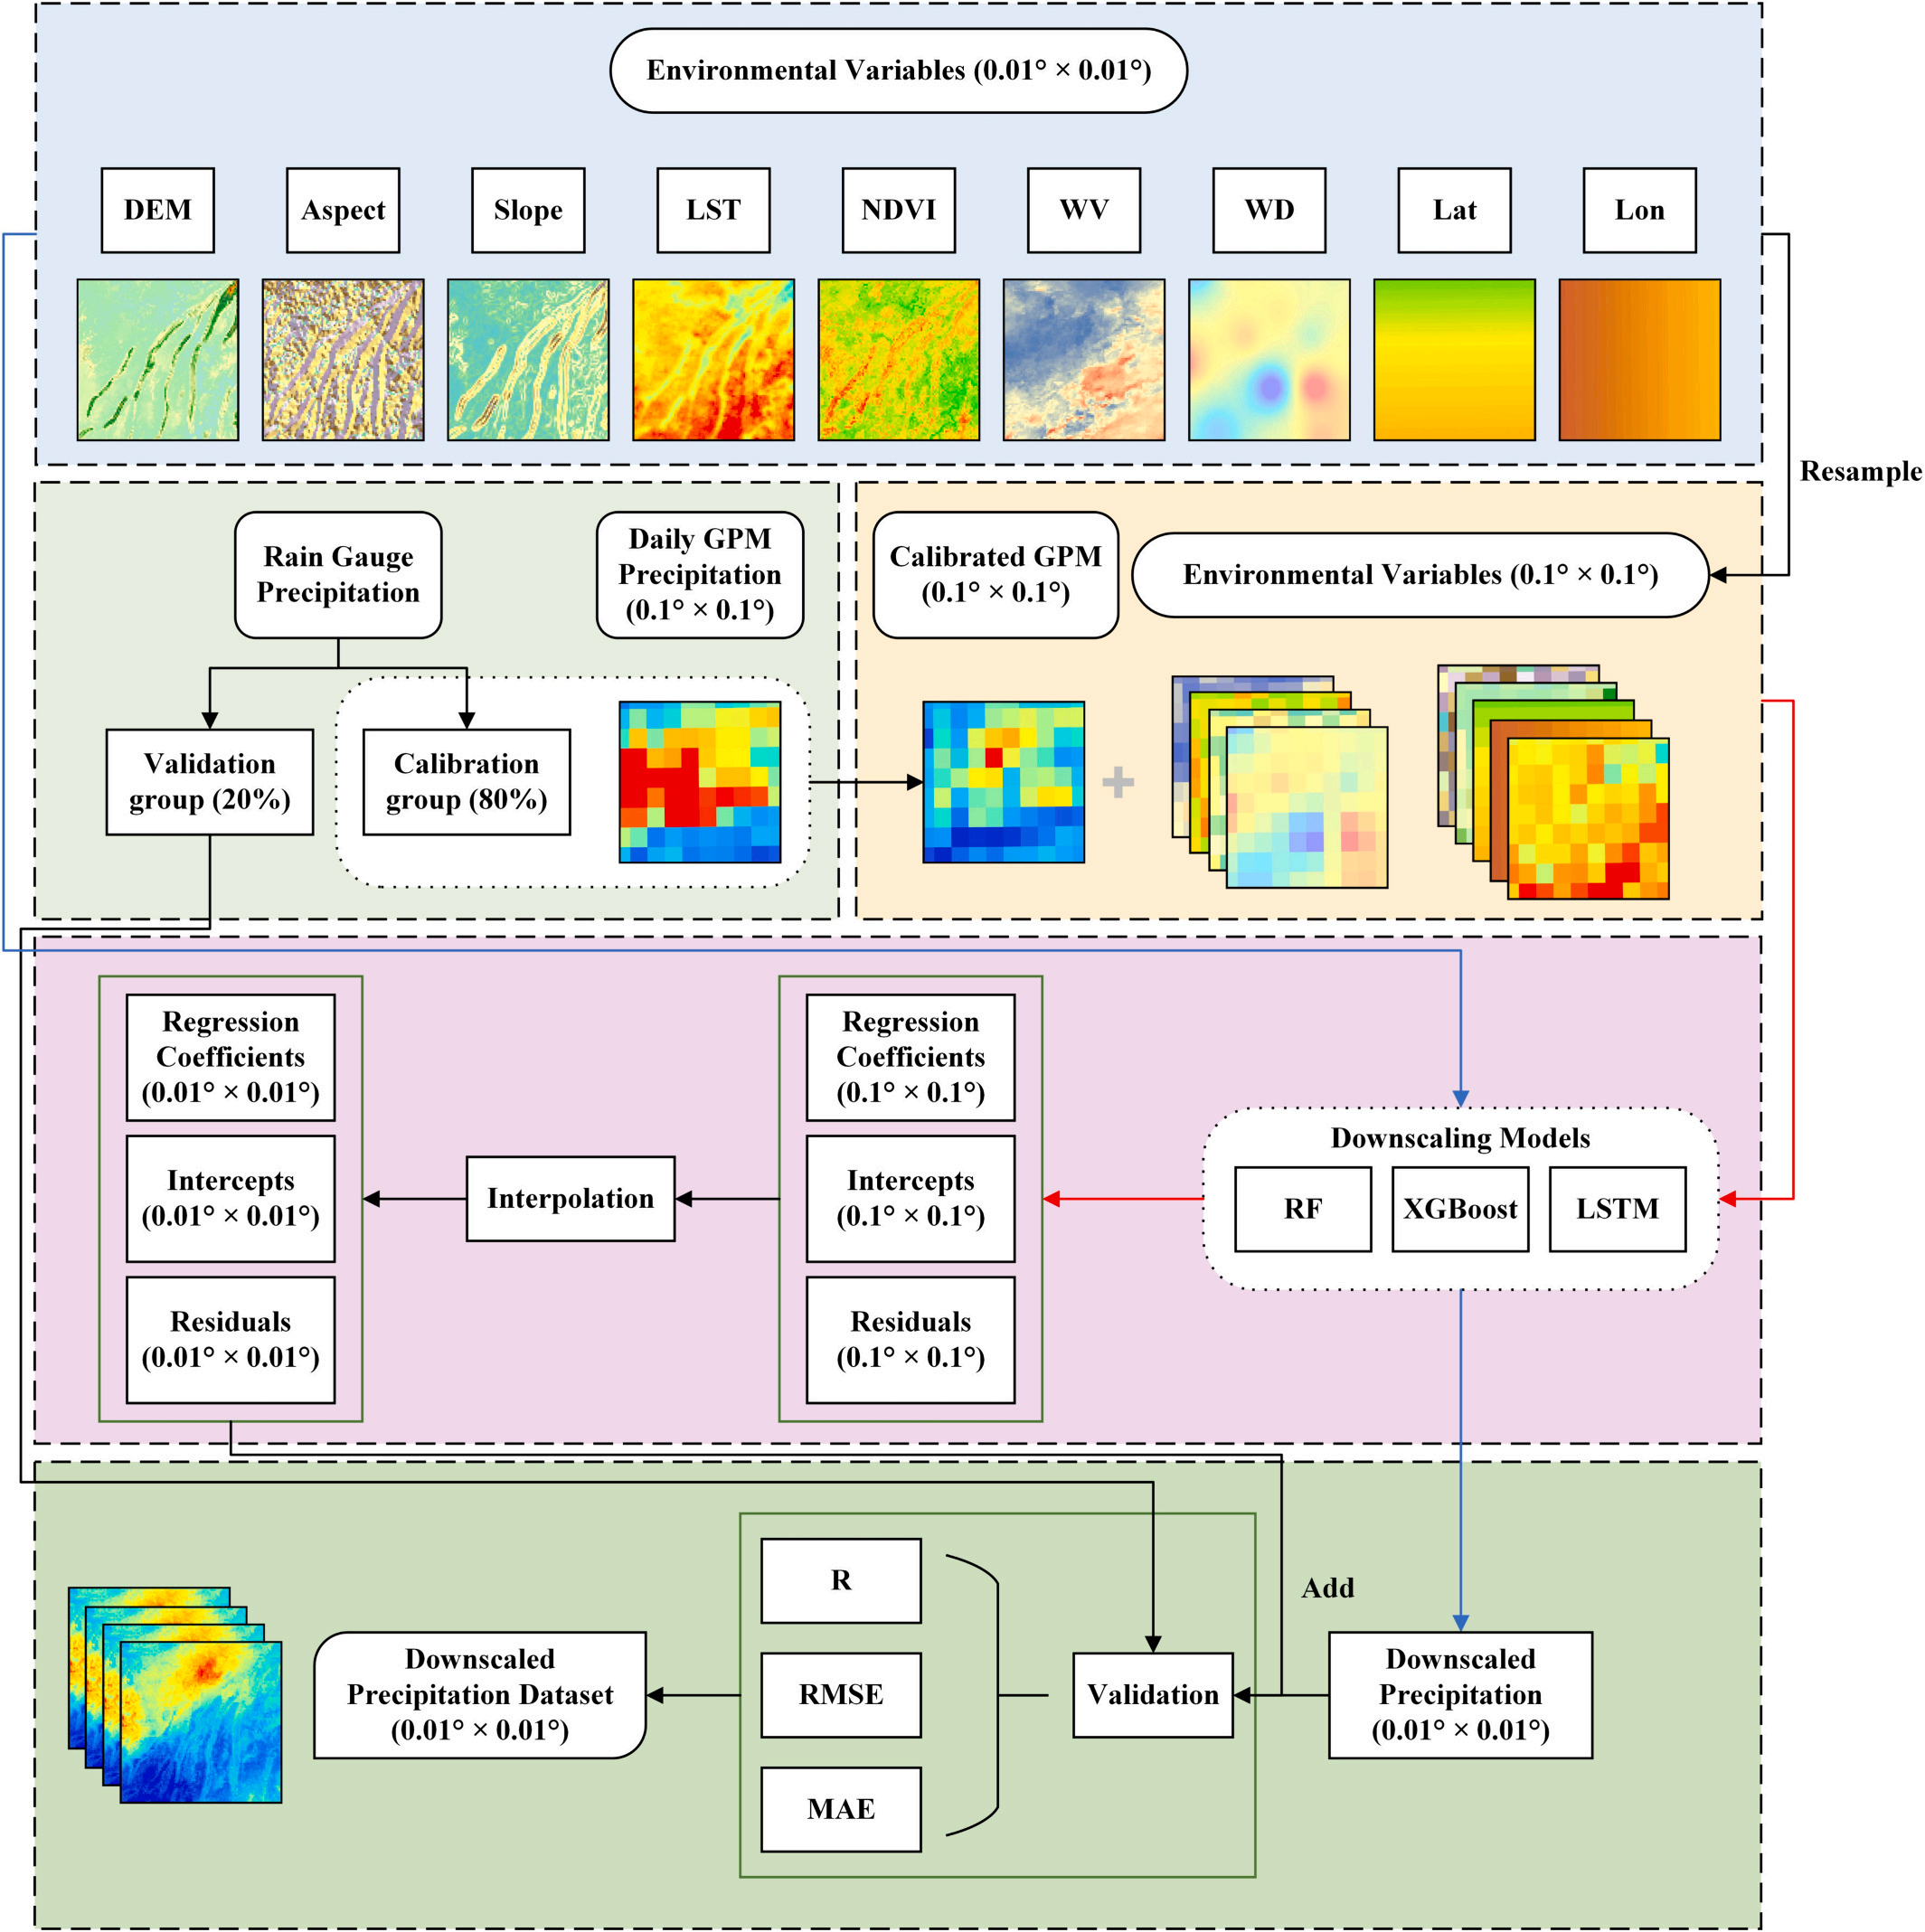

LSTM Structure
def build_lstm_model(input_shape = (timesteps, features = 9)):
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model


# STEP 1: Generate environmental variables and precipitation for January of each year

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.interpolate import griddata, RegularGridInterpolator
import os
from datetime import datetime
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)

# Create directories for outputs
output_dir = 'output'
model_dir = 'models'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Define resolutions
low_res = 0.1  # Original resolution (0.1°)
high_res = 0.01  # Target resolution (0.01°)
scale_factor = int(low_res / high_res)  # Scale factor between resolutions (10)

# Define temporal parameters for annual January data
n_years = 10  # 10 years of data (2011-2020)
# We're only using January data for each year
print(f"Scale factor: {scale_factor}x (from {low_res}° to {high_res}°)")
print(f"Temporal extent: {n_years} years (January only)")
print("\nSTEP 1: Generating environmental variables and precipitation data...")

# Define geographic boundaries for New York State
lon_min, lon_max = -79.76, -71.85
lat_min, lat_max = 40.50, 45.01

# Create the low-resolution grid (0.1°)
lr_lon = np.arange(lon_min, lon_max + low_res, low_res)
lr_lat = np.arange(lat_min, lat_max + low_res, low_res)
lr_lon_mesh, lr_lat_mesh = np.meshgrid(lr_lon, lr_lat)

# Create the high-resolution grid (0.01°)
hr_lon = np.arange(lon_min, lon_max + high_res, high_res)
hr_lat = np.arange(lat_min, lat_max + high_res, high_res)
hr_lon_mesh, hr_lat_mesh = np.meshgrid(hr_lon, hr_lat)

print(f"Low-resolution grid: {len(lr_lat)}x{len(lr_lon)} ({len(lr_lat)*len(lr_lon)} points)")
print(f"High-resolution grid: {len(hr_lat)}x{len(hr_lon)} ({len(hr_lat)*len(hr_lon)} points)")

# Define environmental variables
env_vars = ['DEM', 'Slope', 'Aspect', 'NDVI', 'LST', 'WaterVapor', 'WindDirection']

# Function to generate synthetic environmental variables for both resolutions
def generate_environmental_variables(lon, lat, resolution, year_idx=0):
    """Generate synthetic environmental variables for a given location, resolution and year (January)"""
    
    # Generate DEM (Digital Elevation Model) - static, doesn't change with year
    adirondack_center = (-74.5, 44.1)
    catskill_center = (-74.5, 42.0)
    
    # Distance calculations
    dist_adirondacks = np.sqrt((lon - adirondack_center[0])**2 + (lat - adirondack_center[1])**2)
    dist_catskills = np.sqrt((lon - catskill_center[0])**2 + (lat - catskill_center[1])**2)
    
    # Calculate elevation with terrain effects - static
    adirondack_effect = np.exp(-dist_adirondacks * 2) * 1500
    catskill_effect = np.exp(-dist_catskills * 2) * 1200
    base_elevation = 100 + (lat - lat_min) * 50 + (lon_max - lon) * 30
    
    # Add detail proportional to resolution
    detail_scale = 1.0 if resolution >= 0.1 else (0.1 / resolution) * 0.3
    detail = np.random.normal(0, 10 * detail_scale)
    dem = base_elevation + adirondack_effect + catskill_effect + detail
    dem = max(0, dem)
    
    # Generate Slope (steeper in mountains) - static
    slope_base = 0.1 * dem / 100
    slope_detail = np.random.normal(0, 1 * detail_scale)
    slope = max(0, slope_base + slope_detail)
    
    # Generate Aspect (direction of slope) - static
    aspect_base = (lon * 100 + lat * 70) % 360
    aspect_detail = np.random.normal(0, 10 * detail_scale)
    aspect = (aspect_base + aspect_detail) % 360
    
    # The variables below will vary by year, but since we're focusing on January,
    # we'll use January conditions with some interannual variability
    
    # January is winter in Northern Hemisphere, so use winter conditions
    # But add some year-to-year variability
    year_factor = np.sin(year_idx * np.pi / 5)  # Cyclical pattern over 10 years
    
    # Generate NDVI (vegetation index) - low in winter, but varies by year
    ndvi_base = 0.2 + 0.1 * year_factor  # Low in winter (0.1-0.3)
    ndvi_base = ndvi_base - 0.0003 * dem  # Less vegetation at higher elevations
    ndvi_detail = np.random.normal(0, 0.05 * detail_scale)
    ndvi = min(1, max(0, ndvi_base + ndvi_detail))
    
    # Generate LST (land surface temperature) - cold in winter, varies by year
    lst_base = -5 + 7 * year_factor  # Cold in winter, fluctuating between years
    lst_base = lst_base - 0.006 * dem - (lat - lat_min) * 2  # Cooler at higher elevations and latitudes
    lst_detail = np.random.normal(0, 1 * detail_scale)
    lst = lst_base + lst_detail
    
    # Generate Water Vapor (less in winter) - varies by year
    wv_base = 3 + 2 * year_factor  # Low in winter, fluctuating between years
    wv_base = wv_base + 0.2 * lst - 0.1 * dem/100  # Related to temperature and elevation
    wv_detail = np.random.normal(0, 0.2 * detail_scale)
    wv = max(0, wv_base + wv_detail)
    
    # Generate Wind Direction (predominantly westerly) - varies by year
    wd_base = (270 + year_idx * 15) % 360  # Shift slightly each year
    wd_base = (wd_base + (lat - lon) * 5) % 360  # Spatial variation
    wd_detail = np.random.normal(0, 10 * detail_scale)
    wd = (wd_base + wd_detail) % 360
    
    return dem, slope, aspect, ndvi, lst, wv, wd

# Function to generate synthetic precipitation based on environmental variables and year
def generate_precipitation(dem, slope, aspect, ndvi, lst, water_vapor, wind_direction, lon, lat, year_idx):
    """Generate synthetic precipitation for January of a given year"""
    
    # Base precipitation value for January (winter in NY)
    baseline = 80  # Higher in winter
    
    # Add interannual variability
    year_effect = np.sin(year_idx * np.pi / 2.5) * 20  # Cycling between wet and dry years
    
    # Long-term climate change trend (slight increase in winter precipitation)
    trend_effect = year_idx * 1.2  # ~1.2mm increase per year
    
    # El Niño / La Niña effect (cyclical pattern affecting winter precipitation)
    enso_effect = np.cos(year_idx * np.pi / 2) * 15
    
    # Contributions from each environmental factor
    orographic = 0.025 * dem  # More snow at higher elevations in winter
    latitude_effect = (lat - lat_min) * 18  # More precipitation in northern NY in winter
    longitude_effect = (lon_max - lon) * 12  # More precipitation in western NY (lake effect snow)
    
    # Temperature effect (in winter, colder temps can mean more snow)
    temp_effect = np.maximum(0, 5 - lst) * 0.5
    
    # Wind-slope-aspect interaction (windward slopes get more precipitation)
    wind_rad = np.radians(wind_direction)
    aspect_rad = np.radians(aspect)
    wind_aspect_effect = np.cos(wind_rad - aspect_rad) * slope * 0.6
    
    # Vapor effect
    vapor_effect = water_vapor * 2.0
    
    # Random variation (gamma distributed for precipitation-like distribution)
    random_effect = np.random.gamma(2, 3)
    
    # Combine all effects
    precip = baseline + orographic + latitude_effect + longitude_effect + temp_effect + \
             wind_aspect_effect + vapor_effect + year_effect + trend_effect + enso_effect + random_effect
    
    return max(0, precip)

print("Generating low-resolution (0.1°) environmental data for January of each year...")
# Initialize low-resolution arrays with year dimension
lr_dem = np.zeros((n_years, len(lr_lat), len(lr_lon)))
lr_slope = np.zeros_like(lr_dem)
lr_aspect = np.zeros_like(lr_dem)
lr_ndvi = np.zeros_like(lr_dem)
lr_lst = np.zeros_like(lr_dem)
lr_water_vapor = np.zeros_like(lr_dem)
lr_wind_direction = np.zeros_like(lr_dem)
lr_precipitation = np.zeros_like(lr_dem)

# Generate low-resolution environmental variables and precipitation for January of each year
for y in range(n_years):
    year = 2011 + y
    print(f"Processing January {year}")
    
    for i, lat in enumerate(lr_lat):
        for j, lon in enumerate(lr_lon):
            # Generate environmental variables for this year's January
            dem, slope, aspect, ndvi, lst, wv, wd = generate_environmental_variables(lon, lat, low_res, y)
            
            # Store values
            lr_dem[y, i, j] = dem
            lr_slope[y, i, j] = slope
            lr_aspect[y, i, j] = aspect
            lr_ndvi[y, i, j] = ndvi
            lr_lst[y, i, j] = lst
            lr_water_vapor[y, i, j] = wv
            lr_wind_direction[y, i, j] = wd
            
            # Generate precipitation
            lr_precipitation[y, i, j] = generate_precipitation(dem, slope, aspect, ndvi, lst, wv, wd, lon, lat, y)

print("Generating high-resolution (0.01°) environmental data for validation year...")
# We'll only generate high-res data for the last year to save computation time
validation_year = n_years - 1  # 2020

# Initialize high-resolution arrays for the validation year's January
hr_dem = np.zeros((len(hr_lat), len(hr_lon)))
hr_slope = np.zeros_like(hr_dem)
hr_aspect = np.zeros_like(hr_dem)
hr_ndvi = np.zeros_like(hr_dem)
hr_lst = np.zeros_like(hr_dem)
hr_water_vapor = np.zeros_like(hr_dem)
hr_wind_direction = np.zeros_like(hr_dem)

print(f"Generating high-resolution environmental variables for January {2011+validation_year}...")

# Generate high-resolution environmental variables
# This is computationally intensive, so we'll use batching
batch_size = 50  # Process this many rows at a time
for i_start in range(0, len(hr_lat), batch_size):
    i_end = min(i_start + batch_size, len(hr_lat))
    print(f"Processing high-resolution rows {i_start} to {i_end-1} of {len(hr_lat)}")
    
    for i in range(i_start, i_end):
        for j in range(len(hr_lon)):
            # Generate environmental variables at high resolution
            dem, slope, aspect, ndvi, lst, wv, wd = generate_environmental_variables(hr_lon[j], hr_lat[i], high_res, validation_year)
            
            # Store values
            hr_dem[i, j] = dem
            hr_slope[i, j] = slope
            hr_aspect[i, j] = aspect
            hr_ndvi[i, j] = ndvi
            hr_lst[i, j] = lst
            hr_water_vapor[i, j] = wv
            hr_wind_direction[i, j] = wd


KeyboardInterrupt: 


# STEP 2: Simulate calibration with 80% of station data (complex terrain)


The calibration involves two steps:

---

## 1. Calculation of Ratio Coefficient $P_k$

$$
P_k = \frac{x_k + \lambda}{y_k + \lambda}
$$

- $x_k$: Observed precipitation at the $k$-th ground station  
- $y_k$: GPM precipitation value at the pixel overlapping the $k$-th station  
- $\lambda$: A smoothing constant ($\lambda = 10 \, \text{mm}$) introduced to:  
  - Avoid division by zero when $y_k = 0$  
  - Mitigate instability caused by extremely low precipitation values (e.g., $y_k \approx 0$)

**Interpretation:**

- If $x_k > y_k$ (GPM **underestimates** precipitation), $P_k > 1$  
- If $x_k < y_k$ (GPM **overestimates** precipitation), $P_k < 1$  
- $\lambda$ acts as a regularization term, ensuring numerical stability in low-precipitation regions

---

## 2. Spatial Interpolation and Application of $P_k$

The ratio coefficients $P_k$ are spatially interpolated to create a continuous correction map $P_{k(i,j)}$ at the original GPM resolution ($0.1^\circ$).  
The calibrated precipitation value at each pixel $(i,j)$ is calculated as:

$$
P_{(i,j)}^m = \max\left(P_{k(i,j)} \times (y_{(i,j)} + \lambda) - \lambda, \, 0\right)
$$

- $y_{(i,j)}$: Original GPM precipitation value at pixel $(i,j)$  
- $\max(\cdot, 0)$: Ensures non-negative precipitation values

**Interpretation:**

- The term $(y_{(i,j)} + \lambda)$ scales the original GPM value to match the adjusted ratio $P_{k(i,j)}$  
- Subtracting $\lambda$ reverses the initial smoothing effect introduced in $P_k$

---

## Key Steps and Rationale

### Global Interpolation of $P_k$

- **Methods**: Techniques like **Kriging** or **Inverse Distance Weighting (IDW)** interpolate station-based $P_k$ values into a continuous correction map  
- **Purpose**: Captures spatial variability in GPM biases (e.g., overestimation on windward slopes, underestimation in valleys)

---

### Smoothing Constant ($\lambda$)

**Example:**  
If $x_k = 0 \, \text{mm}$ (no observed precipitation) and $y_k = 5 \, \text{mm}$ (GPM estimate):

$$
P_k = \frac{0 + 10}{5 + 10} = 0.67 \quad \Rightarrow \quad P_{(i,j)}^m = 0.67 \times (5 + 10) - 10 = 0.05 \, \text{mm}
$$

**Result**: Reduces GPM overestimation while preserving non-negativity

---

### Non-Negativity Constraint

- Ensures physically realistic precipitation values  
- Especially critical in arid regions or during dry seasons

---

## Summary

This calibration method adjusts GPM data using ground truth from stations, addressing systematic biases through a two-step process:

1. Compute localized correction ratios ($P_k$)  
2. Apply spatially interpolated corrections to generate a refined precipitation product

The use of $\lambda = 10 \, \text{mm}$ balances robustness and sensitivity, while the $\max(\cdot, 0)$ constraint ensures realistic outputs.


In [ ]:

print("\nSTEP 2: Simulating calibration with 80% of station data...")

# Simulate station data by sampling from the low-resolution grid
n_stations = 40  # Total number of stations
calibration_ratio = 0.8  # 80% for calibration, 20% for validation

# Randomly select station locations (same for all years)
np.random.seed(42)  # For reproducibility
station_indices = np.random.choice(len(lr_lat) * len(lr_lon), n_stations, replace=False)
station_i = station_indices // len(lr_lon)
station_j = station_indices % len(lr_lon)

# Get station coordinates
station_lons = lr_lon[station_j]
station_lats = lr_lat[station_i]

# Create a dictionary to store calibrated precipitation for each year
calibrated_lr_precip = np.zeros_like(lr_precipitation)

# Process each year separately
for y in range(n_years):
    # Get "observed" precipitation for this year's January from stations
    station_precip = np.array([lr_precipitation[y, i, j] for i, j in zip(station_i, station_j)])
    
    # Add some random variation to make it more realistic (measurement error, local effects)
    station_precip = station_precip * (1 + np.random.normal(0, 0.1, n_stations))
    
    # Split into calibration and validation stations (same split for all years)
    if y == 0:  # Only create the split once
        n_calibration = int(n_stations * calibration_ratio)
        calibration_indices = np.random.choice(n_stations, n_calibration, replace=False)
        validation_indices = np.setdiff1d(np.arange(n_stations), calibration_indices)
        
        cal_lons = station_lons[calibration_indices]
        cal_lats = station_lats[calibration_indices]
        
        val_lons = station_lons[validation_indices]
        val_lats = station_lats[validation_indices]
        
        # Find the closest grid points to each calibration station
        cal_grid_i = np.array([np.argmin(np.abs(lr_lat - lat)) for lat in cal_lats])
        cal_grid_j = np.array([np.argmin(np.abs(lr_lon - lon)) for lon in cal_lons])
    
    # Get calibration and validation precipitation for this year
    cal_precip = station_precip[calibration_indices]
    val_precip = station_precip[validation_indices]
    
    # Calculate calibration ratios at station locations
    lambda_value = 10  # As used in the paper's calibration formula
    cal_ratios = np.zeros(n_calibration)
    for k in range(n_calibration):
        i, j = cal_grid_i[k], cal_grid_j[k]
        x_k = cal_precip[k]  # Station measurement
        y_k = lr_precipitation[y, i, j]  # Original value at corresponding grid point
        cal_ratios[k] = (x_k + lambda_value) / (y_k + lambda_value)
    
    # Interpolate calibration ratios to the entire grid using IDW (Inverse Distance Weighting)
    cal_points = np.array([cal_lats, cal_lons]).T
    grid_points = np.array([lr_lat_mesh.flatten(), lr_lon_mesh.flatten()]).T
    cal_ratio_grid_flat = griddata(cal_points, cal_ratios, grid_points, method='linear', fill_value=1.0)
    cal_ratio_grid = cal_ratio_grid_flat.reshape(lr_lat_mesh.shape)
    
    # Apply calibration to the entire low-resolution precipitation grid for this year
    for i in range(len(lr_lat)):
        for j in range(len(lr_lon)):
            # Apply the calibration formula
            y_val = lr_precipitation[y, i, j]
            ratio = cal_ratio_grid[i, j]
            calibrated_lr_precip[y, i, j] = max(0, ratio * (y_val + lambda_value) - lambda_value)

print("Low-resolution precipitation calibrated with station data for all years")

# STEP 3: Build LSTM model to predict annual January precipitation

In [61]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.interpolate import griddata, RegularGridInterpolator
import os
from datetime import datetime
import seaborn as sns
data025 = xr.open_dataset("D:\Desktop\mentor_research\RNN_temp\ERA5_API\era5_nyc_combined_025.nc")
unused_coords = [coord for coord in data025.coords if coord not in data025.dims]
data025_cleaned = data025.drop_vars(unused_coords)
data025_cleaned


<xarray.Dataset>
Dimensions:           (time: 156, latitude: 3, longitude: 5)
Coordinates:
  * time              (time) datetime64[ns] 2002-01-01 2002-02-01 ... 2014-12-01
  * longitude         (longitude) float64 -74.1 -73.85 -73.6 -73.35 -73.1
  * latitude          (latitude) float64 40.9 40.65 40.4
Data variables: (12/14)
    t2m               (time, latitude, longitude) float32 ...
    tcc               (time, latitude, longitude) float32 ...
    u10               (time, latitude, longitude) float32 ...
    v10               (time, latitude, longitude) float32 ...
    lai_hv            (time, latitude, longitude) float32 ...
    lai_lv            (time, latitude, longitude) float32 ...
    ...                ...
    ewss              (time, latitude, longitude) float32 ...
    nsss              (time, latitude, longitude) float32 ...
    tp                (time, latitude, longitude) float32 ...
    wind_speed        (time, latitude, longitude) float32 ...
    wind_direction    (time, latitude, longitude) float32 ...
    stress_magnitude  (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-08T23:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
data01 = xr.open_dataset("D:\Desktop\mentor_research\RNN_temp\ERA5_API\era5_nyc_combined.nc")
unused_coords = [coord for coord in data025.coords if coord not in data01.dims]
data01_cleaned = data01.drop_vars(unused_coords)
data01_cleaned

<xarray.Dataset>
Dimensions:           (time: 156, latitude: 6, longitude: 11)
Coordinates:
  * time              (time) datetime64[ns] 2002-01-01 2002-02-01 ... 2014-12-01
  * longitude         (longitude) float64 -74.1 -74.0 -73.9 ... -73.2 -73.1
  * latitude          (latitude) float64 40.9 40.8 40.7 40.6 40.5 40.4
Data variables: (12/14)
    t2m               (time, latitude, longitude) float32 ...
    tcc               (time, latitude, longitude) float32 ...
    u10               (time, latitude, longitude) float32 ...
    v10               (time, latitude, longitude) float32 ...
    lai_hv            (time, latitude, longitude) float32 ...
    lai_lv            (time, latitude, longitude) float32 ...
    ...                ...
    ewss              (time, latitude, longitude) float32 ...
    nsss              (time, latitude, longitude) float32 ...
    tp                (time, latitude, longitude) float32 ...
    wind_speed        (time, latitude, longitude) float32 ...
    wind_direction    (time, latitude, longitude) float32 ...
    stress_magnitude  (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-08T22:54 GRIB to CDM+CF via cfgrib-0.9.1...

# no lonlat dataset: combined001,combined 005

In [13]:
import numpy as np
import xarray as xr
modis001 = xr.open_dataset("D:/Desktop/mentor_research/data_modis/nyc_modis_data_2015_present.nc")
modis001 = modis001.sel(time=modis001.time < np.datetime64("2024-12-01"))
modis001
precip001 = xr.open_dataset("D:/Desktop/mentor_research/data_imerg/nyc_precipitation_data_2015_to_present.nc")
precip001
combined001 = xr.merge([modis001, precip001])
combined001
# 1. 将 precipitation < 0 的值设为 NaN
combined001["precipitation"] = combined001["precipitation"].where(combined001["precipitation"] >= 0)

# 2. 删除变量 snow_cover（如果存在）
if "snow_cover" in combined001.data_vars:
    combined001 = combined001.drop_vars("snow_cover")

# 可选：查看结果
print(combined001)

combined005 = combined001.coarsen(lat=5, lon=5, boundary="trim").mean()
combined005

<xarray.Dataset>
Dimensions:              (time: 119, lat: 50, lon: 100)
Coordinates:
  * time                 (time) datetime64[ns] 2015-01-01 ... 2024-11-01
  * lon                  (lon) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
  * lat                  (lat) float32 40.4 40.41 40.42 ... 40.88 40.89 40.9
Data variables:
    surface_temperature  (time, lat, lon) float32 ...
    vegetation_index     (time, lat, lon) float32 ...
    evapotranspiration   (time, lat, lon) float32 ...
    dem                  (time, lat, lon) float32 ...
    burned_area          (time, lat, lon) float32 ...
    precipitation        (time, lat, lon) float32 nan 0.0 0.0 ... 0.01102 0.0
Attributes:
    title:                NASA MODIS Data for New York City (2015-Present)
    description:          Monthly averages of Surface Temperature, Vegetation...
    history:              Created on 2025-04-20
    source:               NASA MODIS
    spatial_resolution:   1000m
    temporal_resolution:  Monthly avera

<xarray.Dataset>
Dimensions:              (time: 119, lat: 10, lon: 20)
Coordinates:
  * time                 (time) datetime64[ns] 2015-01-01 ... 2024-11-01
  * lon                  (lon) float32 -74.08 -74.03 -73.98 ... -73.17 -73.12
  * lat                  (lat) float32 40.42 40.47 40.52 ... 40.78 40.83 40.88
Data variables:
    surface_temperature  (time, lat, lon) float32 67.77 75.86 73.39 ... 0.0 0.0
    vegetation_index     (time, lat, lon) float32 0.1851 0.1869 ... -0.3 -0.3
    evapotranspiration   (time, lat, lon) float32 394.5 394.6 ... 3.277e+03
    dem                  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    burned_area          (time, lat, lon) float32 -0.12 -0.12 ... -2.0 -2.0
    precipitation        (time, lat, lon) float32 0.0009419 0.05037 ... 0.005709
Attributes:
    title:                NASA MODIS Data for New York City (2015-Present)
    description:          Monthly averages of Surface Temperature, Vegetation...
    history:              Created on 2025-04-20
    source:               NASA MODIS
    spatial_resolution:   1000m
    temporal_resolution:  Monthly average
    west_lon:             -74.1
    east_lon:             -73.1
    south_lat:            40.4
    north_lat:            40.9

# with lonlat dataframe: df001,df005

In [18]:
df001 = combined001.to_dataframe().reset_index()
df005 = combined005.to_dataframe().reset_index()
df001

time        lat        lon  surface_temperature  \
0      2015-01-01  40.400002 -74.099998            48.736130   
1      2015-01-01  40.400002 -74.089897            64.265160   
2      2015-01-01  40.400002 -74.079796            89.005806   
3      2015-01-01  40.400002 -74.069695            97.069679   
4      2015-01-01  40.400002 -74.059593           105.567101   
...           ...        ...        ...                  ...   
594995 2024-11-01  40.900002 -73.140404             0.000000   
594996 2024-11-01  40.900002 -73.130302             0.000000   
594997 2024-11-01  40.900002 -73.120201             0.000000   
594998 2024-11-01  40.900002 -73.110100             0.000000   
594999 2024-11-01  40.900002 -73.099998             0.000000   

        vegetation_index  evapotranspiration  dem  burned_area  precipitation  
0                0.17170            1.725000  0.0          0.0            NaN  
1                0.23845            1.625000  0.0          0.0       0.000000  
2                0.12905            1.575000  0.0          0.0       0.000000  
3                0.10545            1.575000  0.0          0.0       0.000000  
4                0.21850            1.600000  0.0          0.0       0.006678  
...                  ...                 ...  ...          ...            ...  
594995          -0.30000         3276.600098  0.0         -2.0       0.000000  
594996          -0.30000         3276.600098  0.0         -2.0       0.004394  
594997          -0.30000         3276.600098  0.0         -2.0       0.002860  
594998          -0.30000         3276.600098  0.0         -2.0       0.011022  
594999          -0.30000         3276.600098  0.0         -2.0       0.000000  

[595000 rows x 9 columns]

# with lonlat lstm

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 6, 64)             18432     
                                                                 
 dropout_8 (Dropout)         (None, 6, 64)             0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 31393 (122.63 KB)
Trainable params: 3139

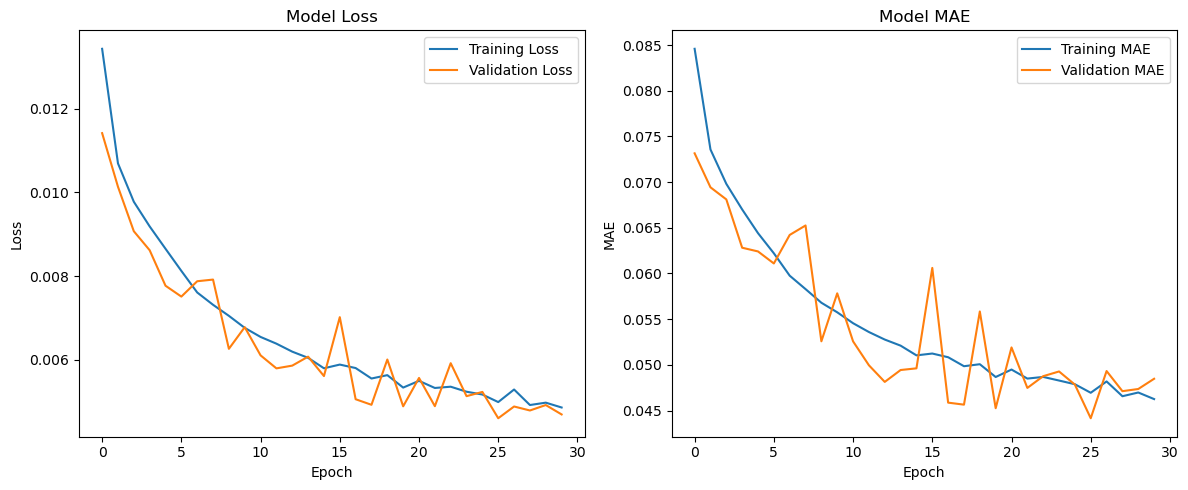

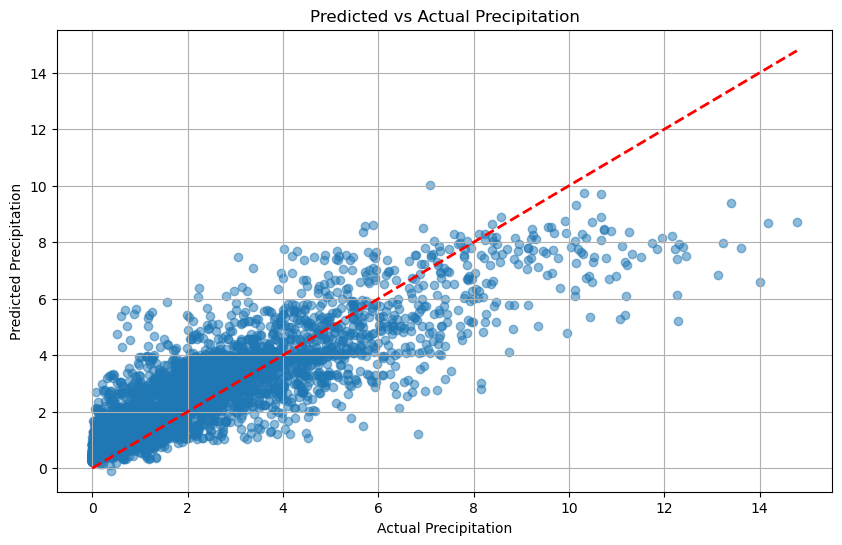

INFO:tensorflow:Assets written to: D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model\assets


INFO:tensorflow:Assets written to: D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model\assets


Model saved in SavedModel format at 'D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model'


In [93]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime

data = df005.copy()
# Process the data to create sequences
def prepare_sequences(data, seq_length=12):
    data = data.sort_values(by=['time', 'lat', 'lon'])

    if isinstance(data['time'][0], str):
        data['time_ordinal'] = pd.to_datetime(data['time']).apply(lambda x: x.toordinal())
    else:
        data['time_ordinal'] = data['time'].apply(lambda x: x.toordinal())

    locations = data[['lat', 'lon']].drop_duplicates().reset_index(drop=True)
    n_times = len(data['time_ordinal'].unique())

    features = ['surface_temperature', 'vegetation_index', 'evapotranspiration', 
                'dem', 'burned_area', 'lat', 'lon']
    target = 'precipitation'
    
    valid_time_indices = list(range(seq_length, n_times))
    X, y, meta = [], [], []

    for _, (lat, lon) in locations.iterrows():
        loc_data = data[(data['lat'] == lat) & (data['lon'] == lon)]
        if len(loc_data) != n_times:
            continue

        loc_features = loc_data[features].values
        loc_target = loc_data[target].values
        loc_times = loc_data['time'].values

        for t_idx in valid_time_indices:
            X.append(loc_features[t_idx-seq_length:t_idx, :])
            y.append(loc_target[t_idx])
            meta.append([loc_times[t_idx], lat, lon])  # 保存 time/lat/lon

    return np.array(X), np.array(y), np.array(meta)

# Prepare the data
seq_length = 6  # Look back 6 time steps
X, y, meta_info = prepare_sequences(data, seq_length)


# Scale the features
scaler_X = MinMaxScaler()
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape((n_samples * n_timesteps, n_features))
X_scaled = scaler_X.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape((n_samples, n_timesteps, n_features))

# Scale the target
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Build the LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Get input shape from training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Build and compile the model
model = build_model(input_shape)
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

# Evaluate the model
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate metrics
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"Mean Squared Error: {mse:.6f}")
print(f"Root Mean Squared Error: {rmse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plot the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 
         'r--', lw=2)
plt.title('Predicted vs Actual Precipitation')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.grid(True)
plt.show()

# 原来的代码：
# model.save('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model.h5')
# print("Model saved to 'lstm_precipitation_model.h5'")

# 修改为SavedModel格式：
model.save('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model')
print("Model saved in SavedModel format at 'D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model'")

# loaded_model = tf.keras.models.load_model('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model')

# Example of how to make predictions with new data
def predict_precipitation(model, new_data, scaler_X, scaler_y, seq_length):
    X_new, _, meta_info = prepare_sequences(new_data, seq_length)

    n_samples, n_timesteps, n_features = X_new.shape
    X_new_reshaped = X_new.reshape((n_samples * n_timesteps, n_features))
    X_new_scaled = scaler_X.transform(X_new_reshaped)
    X_new_scaled = X_new_scaled.reshape((n_samples, n_timesteps, n_features))

    y_pred_scaled = model.predict(X_new_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

    # 构建 DataFrame 结果表
    result_df = pd.DataFrame({
        'time': pd.to_datetime(meta_info[:, 0]),
        'lat': meta_info[:, 1].astype(float),
        'lon': meta_info[:, 2].astype(float),
        'predicted_precipitation': y_pred
    })

    return result_df


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 64)             18432     
                                                                 
 dropout_2 (Dropout)         (None, 6, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 31393 (122.63 KB)
Trainable params: 3139

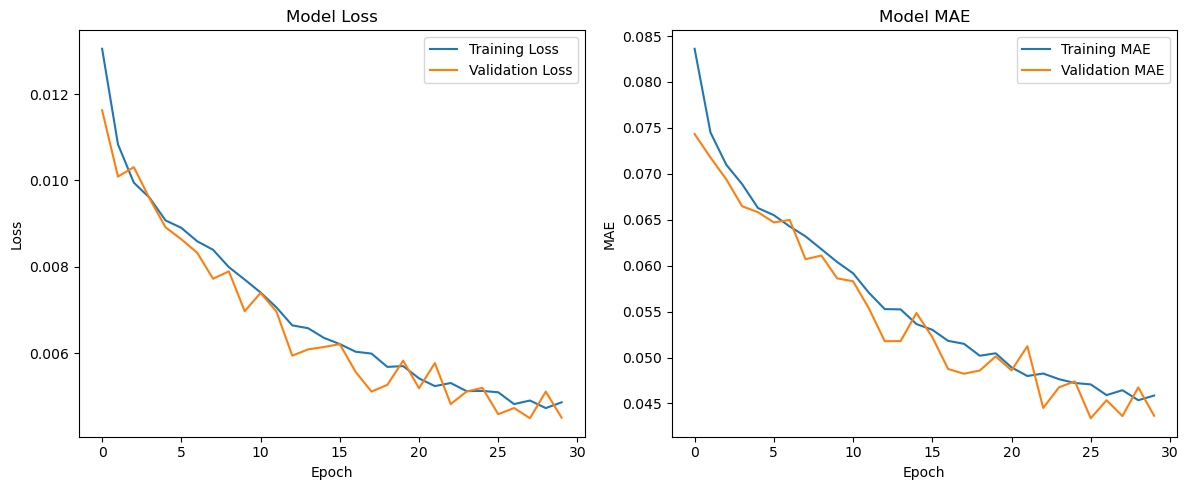

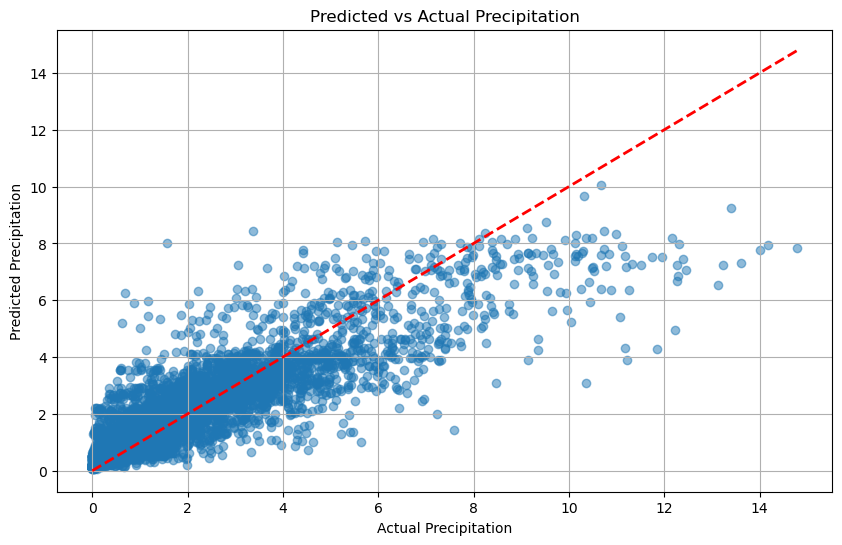

INFO:tensorflow:Assets written to: D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model\assets


INFO:tensorflow:Assets written to: D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model\assets


Model saved in SavedModel format at 'D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model'


In [ ]:
# 原版train，输出无time，lon，lat
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime

data = df005.copy()
# Process the data to create sequences
def prepare_sequences(data, seq_length=12):
    """
    Prepare sequences for LSTM model
    seq_length: number of time steps to look back
    """
    # Sort by time, lat, lon to ensure correct sequence order
    data = data.sort_values(by=['time', 'lat', 'lon'])
    
    # Convert time to ordinal for easier processing
    if isinstance(data['time'][0], str):
        data['time_ordinal'] = pd.to_datetime(data['time']).apply(lambda x: x.toordinal())
    else:
        data['time_ordinal'] = data['time'].apply(lambda x: x.toordinal())
    
    # Extract unique lat/lon combinations
    locations = data[['lat', 'lon']].drop_duplicates().reset_index(drop=True)
    n_locations = len(locations)
    
    # Features and target
    features = ['surface_temperature', 'vegetation_index', 'evapotranspiration', 
                'dem', 'burned_area', 'lat', 'lon']
    target = 'precipitation'
    
    # Get number of times and features
    times = data['time_ordinal'].unique()
    times.sort()
    n_times = len(times)
    n_features = len(features)
    
    # Skip sequences that don't have enough history
    valid_time_indices = list(range(seq_length, n_times))
    
    # Initialize arrays for sequences and targets
    X = []
    y = []
    
    # Create sequences for each location
    for loc_idx, (lat, lon) in locations.iterrows():
        # Get data for this location
        loc_data = data[(data['lat'] == lat) & (data['lon'] == lon)]
        
        # Check if we have all time points for this location
        if len(loc_data) != n_times:
            continue
            
        # Get features and target for this location
        loc_features = loc_data[features].values
        loc_target = loc_data[target].values
        
        # Create sequences
        for t_idx in valid_time_indices:
            X.append(loc_features[t_idx-seq_length:t_idx, :])
            y.append(loc_target[t_idx])
    
    return np.array(X), np.array(y)

# Prepare the data
seq_length = 6  # Look back 6 time steps
X, y = prepare_sequences(data, seq_length)

# Scale the features
scaler_X = MinMaxScaler()
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape((n_samples * n_timesteps, n_features))
X_scaled = scaler_X.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape((n_samples, n_timesteps, n_features))

# Scale the target
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Build the LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Get input shape from training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Build and compile the model
model = build_model(input_shape)
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

# Evaluate the model
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate metrics
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"Mean Squared Error: {mse:.6f}")
print(f"Root Mean Squared Error: {rmse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# Plot the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 
         'r--', lw=2)
plt.title('Predicted vs Actual Precipitation')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.grid(True)
plt.show()

# 原来的代码：
# model.save('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model.h5')
# print("Model saved to 'lstm_precipitation_model.h5'")

# 修改为SavedModel格式：
model.save('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model')
print("Model saved in SavedModel format at 'D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model'")

# loaded_model = tf.keras.models.load_model('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model')

# Example of how to make predictions with new data
def predict_precipitation(model, new_data, scaler_X, scaler_y, seq_length):
    """
    Make predictions using the trained model
    
    Parameters:
    - model: Trained LSTM model
    - new_data: New data with the same features as training data
    - scaler_X: Scaler used for features
    - scaler_y: Scaler used for target
    - seq_length: Sequence length used for model
    
    Returns:
    - Predicted precipitation values
    """
    # Prepare sequences from new data
    X_new, _ = prepare_sequences(new_data, seq_length)
    
    # Scale the features
    n_samples, n_timesteps, n_features = X_new.shape
    X_new_reshaped = X_new.reshape((n_samples * n_timesteps, n_features))
    X_new_scaled = scaler_X.transform(X_new_reshaped)
    X_new_scaled = X_new_scaled.reshape((n_samples, n_timesteps, n_features))
    
    # Make predictions
    y_pred_scaled = model.predict(X_new_scaled)
    
    # Inverse transform to get actual precipitation values
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    
    return y_pred

17657/17657 [==============================] - 25s 1ms/step
Mean Squared Error: 54.807381
Root Mean Squared Error: 7.403201
Mean Absolute Error: 5.813713
R² Score: -4.647497


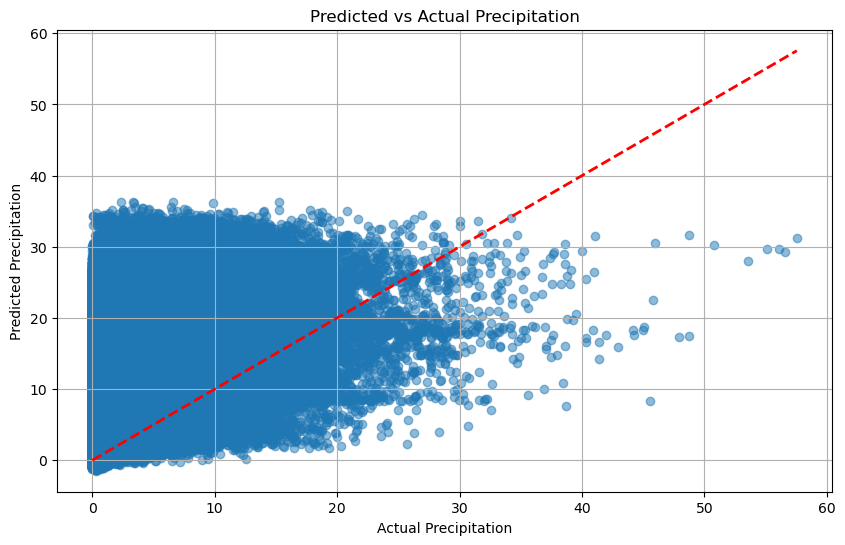

In [109]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 假设 df001 是新的完整预测数据
predict_data = df001.copy()
predict_data['precipitation'] = predict_data['precipitation'].fillna(0)
predict_data['time'] = pd.to_datetime(predict_data['time'])

# 加载模型（SavedModel 格式）
model = tf.keras.models.load_model('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/lstm_precipitation_model')

# 准备序列函数
def prepare_sequences(data, seq_length=6):
    data = data.sort_values(by=['time', 'lat', 'lon'])
    if isinstance(data['time'].iloc[0], str):
        data['time_ordinal'] = pd.to_datetime(data['time']).apply(lambda x: x.toordinal())
    else:
        data['time_ordinal'] = data['time'].apply(lambda x: x.toordinal())

    locations = data[['lat', 'lon']].drop_duplicates().reset_index(drop=True)
    n_times = len(data['time_ordinal'].unique())

    features = ['surface_temperature', 'vegetation_index', 'evapotranspiration', 
                'dem', 'burned_area', 'lat', 'lon']
    target = 'precipitation'
    valid_time_indices = list(range(seq_length, n_times))

    X, y, meta = [], [], []

    for _, (lat, lon) in locations.iterrows():
        loc_data = data[(data['lat'] == lat) & (data['lon'] == lon)]
        if len(loc_data) != n_times:
            continue

        loc_features = loc_data[features].values
        loc_target = loc_data[target].values
        loc_times = loc_data['time'].values

        for t_idx in valid_time_indices:
            X.append(loc_features[t_idx-seq_length:t_idx, :])
            y.append(loc_target[t_idx])
            meta.append([loc_times[t_idx], lat, lon])

    return np.array(X), np.array(y), np.array(meta)

# 准备序列
seq_length = 6
X_all, y_all, meta_info_all = prepare_sequences(predict_data, seq_length)

# 缩放输入特征
scaler_X = MinMaxScaler()
n_samples, n_timesteps, n_features = X_all.shape
X_reshaped = X_all.reshape((n_samples * n_timesteps, n_features))
X_scaled = scaler_X.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape((n_samples, n_timesteps, n_features))

# 缩放输出
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_all.reshape(-1, 1))

# 预测
y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_scaled)

# 构建结果表格
results_df = pd.DataFrame({
    'time': pd.to_datetime(meta_info_all[:, 0]),
    'lat': meta_info_all[:, 1].astype(float),
    'lon': meta_info_all[:, 2].astype(float),
    'actual_precipitation': y_actual.flatten(),
    'predicted_precipitation': y_pred.flatten()
})

# ====== 误差评估 ======
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"Mean Squared Error: {mse:.6f}")
print(f"Root Mean Squared Error: {rmse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# ====== 散点图：真实 vs 预测 ======
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Precipitation')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.grid(True)
plt.show()


In [110]:
results_df

time        lat        lon  actual_precipitation  \
0      2015-07-01  40.400002 -74.099998                   0.0   
1      2015-08-01  40.400002 -74.099998                   0.0   
2      2015-09-01  40.400002 -74.099998                   0.0   
3      2015-10-01  40.400002 -74.099998                   0.0   
4      2015-11-01  40.400002 -74.099998                   0.0   
...           ...        ...        ...                   ...   
564995 2024-07-01  40.900002 -73.099998                   0.0   
564996 2024-08-01  40.900002 -73.099998                   0.0   
564997 2024-09-01  40.900002 -73.099998                   0.0   
564998 2024-10-01  40.900002 -73.099998                   0.0   
564999 2024-11-01  40.900002 -73.099998                   0.0   

        predicted_precipitation  
0                      1.203645  
1                      1.111527  
2                      1.021091  
3                      0.902149  
4                      0.855164  
...                         ...  
564995                 2.779130  
564996                 2.779130  
564997                 2.779130  
564998                 2.779130  
564999                 2.779130  

[565000 rows x 5 columns]

Found 113 rows for location (40.57347106933594, -73.20101166)


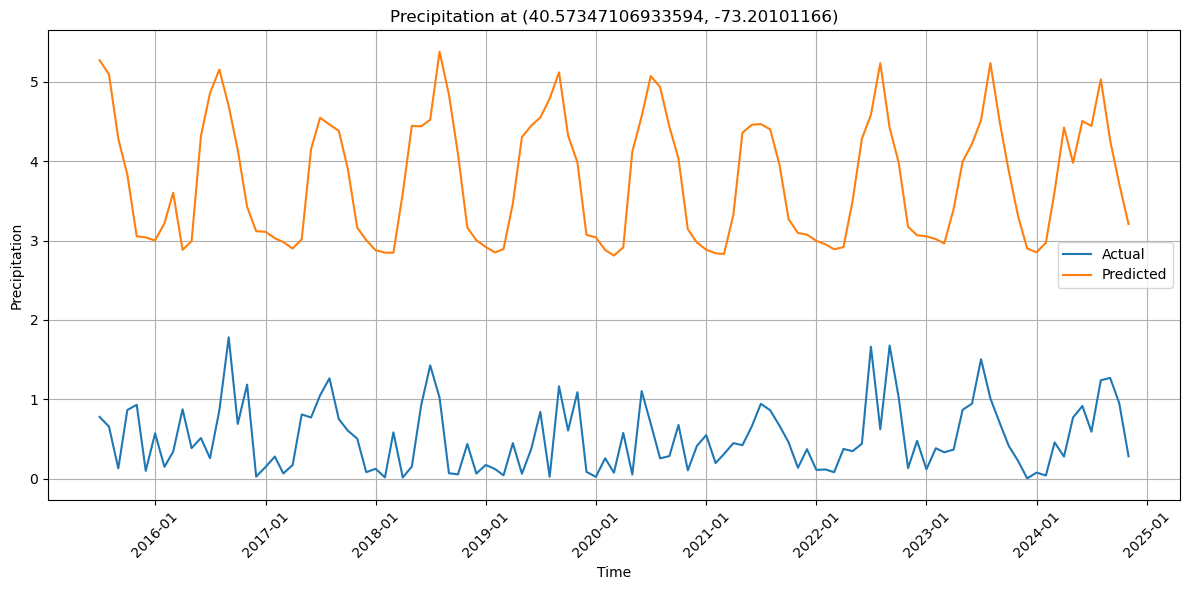

In [111]:
import matplotlib.dates as mdates

# 容差匹配经纬度
tol = 1e-4
sample_lat = 40.57347106933594
sample_lon = -73.20101166

sample_df = results_df[
    (np.abs(results_df['lat'] - sample_lat) < tol) &
    (np.abs(results_df['lon'] - sample_lon) < tol)
].sort_values('time')

# 确认筛选成功
print(f"Found {len(sample_df)} rows for location ({sample_lat}, {sample_lon})")

# 绘图
if sample_df.empty:
    print("⚠️ No data found for this location.")
else:
    plt.figure(figsize=(12, 6))
    plt.plot(sample_df['time'], sample_df['actual_precipitation'], label='Actual')
    plt.plot(sample_df['time'], sample_df['predicted_precipitation'], label='Predicted')
    plt.title(f'Precipitation at ({sample_lat}, {sample_lon})')
    plt.xlabel('Time')
    plt.ylabel('Precipitation')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tight_layout()
    plt.show()


In [112]:
results_df.to_csv('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/predicted_precipitation_results.csv', index=False)
print("Results saved to 'predicted_precipitation_results.csv'")



Results saved to 'predicted_precipitation_results.csv'


In [227]:
print(results_df.head(5))
import pandas as pd
import xarray as xr

# 假设 results_df 已经是你当前的 DataFrame
# 你可以先确认：results_df.head()
results_df = pd.read_csv('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/predicted_precipitation_results.csv')

# Step 1: 转换 time 列为 datetime 类型
results_df['time'] = pd.to_datetime(results_df['time'])

# Step 2: 设置 MultiIndex 并排序（确保唯一性和可reshape）
results_df = results_df.set_index(['time', 'lon', 'lat']).sort_index()

# Step 3: 转换为 xarray Dataset
results_combined = results_df.to_xarray()

# 显示 Dataset 的结构
results_combined


        time        lat        lon  actual_precipitation  \
0 2015-07-01  40.400002 -74.099998                   0.0   
1 2015-08-01  40.400002 -74.099998                   0.0   
2 2015-09-01  40.400002 -74.099998                   0.0   
3 2015-10-01  40.400002 -74.099998                   0.0   
4 2015-11-01  40.400002 -74.099998                   0.0   

   predicted_precipitation  
0                 1.203645  
1                 1.111527  
2                 1.021091  
3                 0.902149  
4                 0.855164  


<xarray.Dataset>
Dimensions:                  (time: 113, lon: 100, lat: 50)
Coordinates:
  * time                     (time) datetime64[ns] 2015-07-01 ... 2024-11-01
  * lon                      (lon) float64 -74.1 -74.09 -74.08 ... -73.11 -73.1
  * lat                      (lat) float64 40.4 40.41 40.42 ... 40.88 40.89 40.9
Data variables:
    actual_precipitation     (time, lon, lat) float64 0.0 0.0 0.0 ... 0.0 0.0
    predicted_precipitation  (time, lon, lat) float64 1.204 1.186 ... 2.779

C:\Users\18857\AppData\Local\Temp\ipykernel_108576\288964111.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.07, 1, 1])


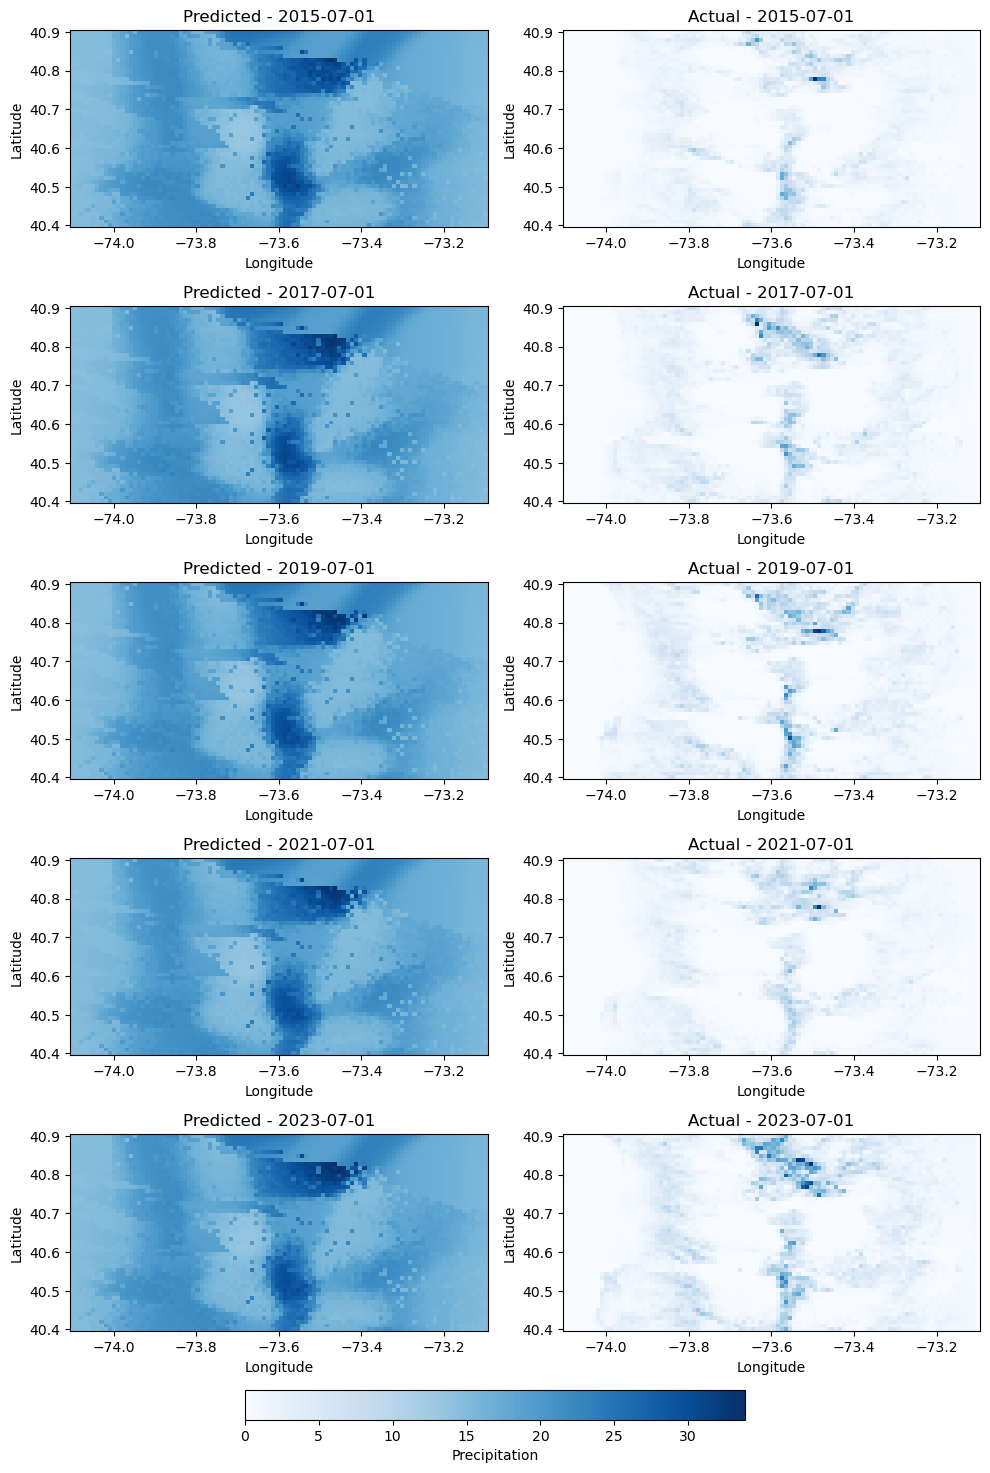

In [232]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# 选择几个代表性的时间点
selected_times = results_combined.time.values[::24]
selected_times = selected_times[:5]

# 提取预测与真实值
tp_pred = results_combined['predicted_precipitation'].sel(time=selected_times)-5
tp_actual = results_combined['actual_precipitation'].sel(time=selected_times)

# 开始绘图
fig, axes = plt.subplots(len(selected_times), 2, figsize=(10, 3 * len(selected_times)))

for i, t in enumerate(selected_times):
    # 不使用 transpose，保持 lon 为 x，lat 为 y
    im0 = tp_pred.sel(time=t).plot(ax=axes[i, 0], cmap="Blues", add_colorbar=False,x='lon', y='lat')
    axes[i, 0].set_title(f"Predicted - {np.datetime_as_string(t, unit='D')}")
    axes[i, 0].set_xlabel("Longitude")
    axes[i, 0].set_ylabel("Latitude")

    im1 = tp_actual.sel(time=t).plot(ax=axes[i, 1], cmap="Blues", add_colorbar=False,x='lon', y='lat')
    axes[i, 1].set_title(f"Actual - {np.datetime_as_string(t, unit='D')}")
    axes[i, 1].set_xlabel("Longitude")
    axes[i, 1].set_ylabel("Latitude")

# 添加统一 colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])
plt.colorbar(im1, cax=cbar_ax, orientation='horizontal', label='Precipitation')

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()


In [233]:
from sklearn.metrics import r2_score
import numpy as np

# 存储结果
correlations = []
r2_scores = []
time_labels = []

# 遍历每个时间点计算对应指标
for t in selected_times:
    pred_values = tp_pred.sel(time=t).values.flatten()
    actual_values = tp_actual.sel(time=t).values.flatten()
    
    # 去除 NaN 对应位置
    valid_mask = (~np.isnan(pred_values)) & (~np.isnan(actual_values))
    y_pred = pred_values[valid_mask]
    y_true = actual_values[valid_mask]
    
    # Pearson 相关系数
    if len(y_true) > 0:
        corr = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = r2_score(y_true, y_pred)
    else:
        corr = np.nan
        r2 = np.nan

    correlations.append(corr)
    r2_scores.append(r2)
    time_labels.append(str(np.datetime_as_string(t, unit='D')))

correlations, r2_scores

metrics_df = pd.DataFrame({
    "Time": time_labels,
    "Pearson Correlation": correlations,
    "R² Score": r2_scores
})

metrics_df


Time  Pearson Correlation  R² Score
0  2015-07-01             0.578292 -1.175498
1  2017-07-01             0.588263 -1.289037
2  2019-07-01             0.573974 -1.709199
3  2021-07-01             0.604569 -1.237186
4  2023-07-01             0.623345 -1.105613

## Post Calibration

Linear Regression Calibration

Quantile Mapping

Scaling Only

### Linear Regression Calibration

In [239]:
# 用weather station数据对齐
results_df = pd.read_csv('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/predicted_precipitation_results.csv')
results_df

time        lat        lon  actual_precipitation  \
0       2015-07-01  40.400002 -74.099998                   0.0   
1       2015-08-01  40.400002 -74.099998                   0.0   
2       2015-09-01  40.400002 -74.099998                   0.0   
3       2015-10-01  40.400002 -74.099998                   0.0   
4       2015-11-01  40.400002 -74.099998                   0.0   
...            ...        ...        ...                   ...   
564995  2024-07-01  40.900002 -73.099998                   0.0   
564996  2024-08-01  40.900002 -73.099998                   0.0   
564997  2024-09-01  40.900002 -73.099998                   0.0   
564998  2024-10-01  40.900002 -73.099998                   0.0   
564999  2024-11-01  40.900002 -73.099998                   0.0   

        predicted_precipitation  
0                      1.203645  
1                      1.111527  
2                      1.021091  
3                      0.902149  
4                      0.855164  
...                         ...  
564995                 2.779130  
564996                 2.779130  
564997                 2.779130  
564998                 2.779130  
564999                 2.779130  

[565000 rows x 5 columns]

In [240]:
import pandas as pd
import numpy as np

# 处理station数据（日均值要用非0值求）
cali_precip = pd.read_csv("D:/Desktop/mentor_research/data_station/nyc_central_park_precipitation.csv")
cali_precip['time'] = pd.to_datetime(cali_precip['time'])
cali_precip['month'] = cali_precip['time'].dt.to_period('M').dt.to_timestamp()

# 获取所有唯一组合
all_combinations = (
    cali_precip[['month', 'lat', 'lon']]
    .drop_duplicates()
    .sort_values(['month', 'lat', 'lon'])
)

# 对非零值做均值
nonzero_mean = (
    cali_precip[cali_precip['precipitation'] > 0]
    .groupby(['month', 'lat', 'lon'])['precipitation']
    .mean()
    .reset_index(name='cali_precipitation')
)

# 与所有组合进行 merge（保留所有格点）
cali_precip = pd.merge(
    all_combinations,
    nonzero_mean,
    how='left',
    on=['month', 'lat', 'lon']
)

# 如果你希望全为 0 的情况设为 0（而不是 NaN），加这一步：
cali_precip['cali_precipitation'] = cali_precip['cali_precipitation'].fillna(0)

# 最后统一列名
cali_precip.rename(columns={'month': 'time'}, inplace=True)
cali_precip
cali_precip.to_csv('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/cali_precipitation.csv')

In [241]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# 保证时间格式正确
cali_precip['time'] = pd.to_datetime(cali_precip['time'])
results_df['time'] = pd.to_datetime(results_df['time'])

# 提取 results_df 中可用时间点
valid_times = results_df['time'].unique()

# 筛选 cali_precip 中在有效时间点范围内的数据
cali_in_range = cali_precip[cali_precip['time'].isin(valid_times)].copy()
cali_in_range.sort_values(by=['time', 'lat', 'lon'], inplace=True)

# 添加新列用于填入预测值
cali_in_range['matched_prediction'] = np.nan

# 对每一个时间点，匹配最近 (lat, lon)
for t in cali_in_range['time'].unique():
    cali_t = cali_in_range[cali_in_range['time'] == t]
    results_t = results_df[results_df['time'] == t]

    if results_t.empty:
        continue

    # 构建 KDTree 匹配空间最近点
    tree = cKDTree(results_t[['lat', 'lon']].values)
    distances, indices = tree.query(cali_t[['lat', 'lon']].values)

    # 获取对应预测值
    matched_preds = results_t.iloc[indices]['predicted_precipitation'].values

    # 写入结果
    cali_in_range.loc[cali_t.index, 'matched_prediction'] = matched_preds

print(cali_in_range.head())
# 准备训练数据，去掉 NaN
calibration_df = cali_in_range.dropna(subset=['cali_precipitation', 'matched_prediction'])

X = calibration_df[['matched_prediction']].values
y = calibration_df['cali_precipitation'].values


         time      lat      lon  cali_precipitation  matched_prediction
12 2015-07-01  40.6386 -73.7622            0.651933            8.421680
13 2015-07-01  40.6825 -74.1694            0.759178            1.588196
14 2015-08-01  40.6386 -73.7622            2.305050            8.394139
15 2015-08-01  40.6825 -74.1694            0.889000            1.571221
16 2015-09-01  40.6386 -73.7622            0.819150            8.523549


In [242]:

from sklearn.linear_model import LinearRegression
import numpy as np
# 筛选非零降水数据进行校准
mask = y > 0
X_filtered = X[mask]
y_filtered = y[mask]

# 拟合线性回归
lr_model = LinearRegression()
lr_model.fit(X_filtered, y_filtered)

beta_0 = lr_model.intercept_
beta_1 = lr_model.coef_[0]

print("Linear regression calibration formula (y > 0):")
print(f"calibrated_prediction = {beta_0:.12f} + {beta_1:.12f} × matched_prediction")



Linear regression calibration formula (y > 0):
calibrated_prediction = 0.976033132693 + -0.004637235560 × matched_prediction


In [215]:
np.mean(X_filtered-y_filtered)

6.230882516605253

In [ ]:
# from scipy.stats import rankdata
# import numpy as np

# def quantile_mapping(predicted, actual):
#     # 排序，计算分位数
#     pred_sorted = np.sort(predicted)
#     actual_sorted = np.sort(actual)
    
#     # 获取预测值的排名（分位）
#     quantiles = rankdata(predicted, method='average') / len(predicted)
    
#     # 映射每个预测值到真实值对应分位
#     calibrated = np.quantile(actual_sorted, quantiles)
#     return calibrated
# calibrated_predictions = quantile_mapping(X, y)


In [249]:
# 创建副本并进行校准
results_combined = results_df.copy()
beta_0 = -6.230882516605253
beta_1 = 1.0
results_combined['calibrated_precipitation'] = beta_0 + beta_1 * results_combined['predicted_precipitation']
results_combined['calibrated_precipitation'] = np.where(results_combined['calibrated_precipitation'] < 0, 0, results_combined['calibrated_precipitation'])
results_combined['time'] = pd.to_datetime(results_combined['time'])

# 设置三维索引
results_indexed = results_combined.set_index(['time', 'lat', 'lon'])

# 转换为 xarray Dataset
results_combined = xr.Dataset.from_dataframe(results_indexed)

# 查看结果结构
print(results_combined)


<xarray.Dataset>
Dimensions:                   (time: 113, lat: 50, lon: 100)
Coordinates:
  * time                      (time) datetime64[ns] 2015-07-01 ... 2024-11-01
  * lat                       (lat) float64 40.4 40.41 40.42 ... 40.89 40.9
  * lon                       (lon) float64 -74.1 -74.09 -74.08 ... -73.11 -73.1
Data variables:
    actual_precipitation      (time, lat, lon) float64 0.0 0.0 ... 0.01102 0.0
    predicted_precipitation   (time, lat, lon) float64 1.204 1.235 ... 2.779
    calibrated_precipitation  (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0


In [ ]:
# 用真实值做calibration
results_df = pd.read_csv('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/predicted_precipitation_results.csv')
results_df
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# 假设你的 DataFrame 名为 results_df
# 确保时间列为 datetime 类型
results_df['time'] = pd.to_datetime(results_df['time'])

# 取出非缺失值进行拟合（排除NaN和全为0的情况）
valid = (results_df['actual_precipitation'].notna()) & (results_df['predicted_precipitation'].notna())

X = results_df.loc[valid, 'predicted_precipitation'].values.reshape(-1, 1)
y = results_df.loc[valid, 'actual_precipitation'].values

# 拟合线性模型
calibrator = LinearRegression()
calibrator.fit(X, y)

# 输出回归参数
print(f"Calibration equation: y = {calibrator.coef_[0]:.4f} * x + {calibrator.intercept_:.4f}")

# 应用校准（对所有数据进行转换，包括原本为0的行）
results_df['calibrated_precipitation'] = calibrator.predict(
    results_df['predicted_precipitation'].values.reshape(-1, 1)
)

# 可选：将校准后的负值设为0（如果降水量不可能为负）
results_df['calibrated_precipitation'] = results_df['calibrated_precipitation'].clip(lower=0)

# 显示前几行查看效果
print(results_df.head())

# Step 1: 转换 time 列为 datetime 类型
results_df['time'] = pd.to_datetime(results_df['time'])

# Step 2: 设置 MultiIndex 并排序（确保唯一性和可reshape）
results_df = results_df.set_index(['time', 'lon', 'lat']).sort_index()

# Step 3: 转换为 xarray Dataset
results_combined = results_df.to_xarray()

# 显示 Dataset 的结构
results_combined


Calibration equation: y = 0.2981 * x + 0.1679
        time        lat        lon  actual_precipitation  \
0 2015-07-01 -74.099998  40.400002                   0.0   
1 2015-08-01 -74.099998  40.400002                   0.0   
2 2015-09-01 -74.099998  40.400002                   0.0   
3 2015-10-01 -74.099998  40.400002                   0.0   
4 2015-11-01 -74.099998  40.400002                   0.0   

   predicted_precipitation  calibrated_precipitation  
0                 0.354370                  0.273573  
1                 0.202335                  0.228250  
2                 0.053494                  0.183879  
3                -0.051957                  0.152444  
4                -0.062927                  0.149174  


<xarray.Dataset>
Dimensions:                   (time: 113, lon: 50, lat: 100)
Coordinates:
  * time                      (time) datetime64[ns] 2015-07-01 ... 2024-11-01
  * lon                       (lon) float64 40.4 40.41 40.42 ... 40.89 40.9
  * lat                       (lat) float64 -74.1 -74.09 -74.08 ... -73.11 -73.1
Data variables:
    actual_precipitation      (time, lon, lat) float64 0.0 0.0 ... 0.01102 0.0
    predicted_precipitation   (time, lon, lat) float64 0.3544 0.407 ... 1.842
    calibrated_precipitation  (time, lon, lat) float64 0.2736 0.2893 ... 0.7171

C:\Users\18857\AppData\Local\Temp\ipykernel_108576\801141568.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.07, 1, 1])


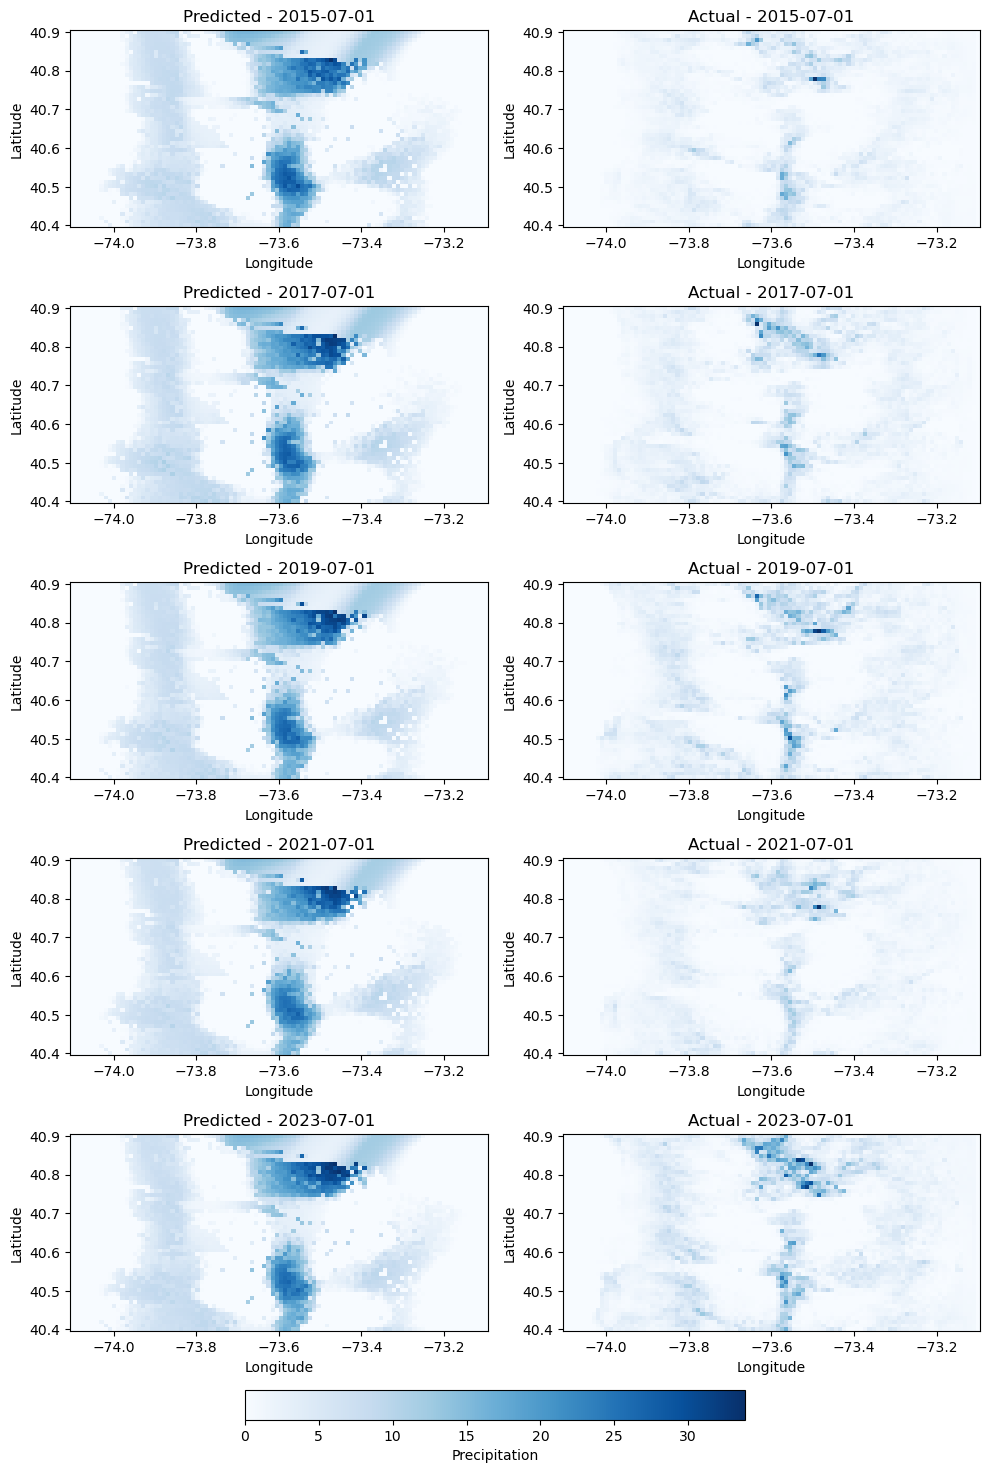

In [250]:
import matplotlib.pyplot as plt
import xarray as xr

# 选择几个代表性的时间点（例如每年年中）
selected_times = results_combined.time.values[::24]  # 每两年取一个（119个时间点中取5个）
selected_times = selected_times[:5]  # 限制前5个时间点作为演示

# 提取预测与真实值
tp_pred = results_combined['calibrated_precipitation'].sel(time=selected_times)
tp_actual = results_combined['actual_precipitation'].sel(time=selected_times)

# 开始绘图
fig, axes = plt.subplots(len(selected_times), 2, figsize=(10, 3 * len(selected_times)))

for i, t in enumerate(selected_times):
    # 预测图
    im0 = tp_pred.sel(time=t).plot(ax=axes[i, 0], cmap="Blues", add_colorbar=False)
    axes[i, 0].set_title(f"Predicted - {str(np.datetime_as_string(t, unit='D'))}")
    axes[i, 0].set_xlabel("Longitude")
    axes[i, 0].set_ylabel("Latitude")

    # 真实图
    im1 = tp_actual.sel(time=t).plot(ax=axes[i, 1], cmap="Blues", add_colorbar=False)
    axes[i, 1].set_title(f"Actual - {str(np.datetime_as_string(t, unit='D'))}")
    axes[i, 1].set_xlabel("Longitude")
    axes[i, 1].set_ylabel("Latitude")

# 调整布局并添加统一的 colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])
plt.colorbar(im1, cax=cbar_ax, orientation='horizontal', label='Precipitation')
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()


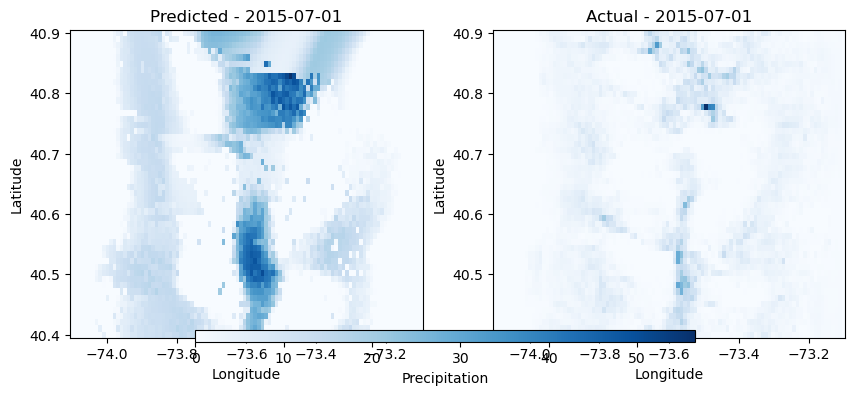

In [251]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import xarray as xr
from IPython.display import HTML

# 提取数据
# 替代 np.where，保持 xarray 的坐标结构
tp_pred = results_combined['calibrated_precipitation'].where(
    results_combined['calibrated_precipitation'] >= 0, 0
)

tp_actual = results_combined['actual_precipitation']
times = results_combined.time.values

# 设置图形基础
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])

# 初始化首帧
tp_pred.isel(time=0).plot(ax=axes[0], cmap="Blues", add_colorbar=False)
img1 = tp_actual.isel(time=0).plot(ax=axes[1], cmap="Blues", add_colorbar=False)

axes[0].set_title("Predicted")
axes[1].set_title("Actual")
for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# 添加 colorbar
plt.colorbar(img1, cax=cbar_ax, orientation='horizontal', label='Precipitation')

# 更新函数
def update(i):
    axes[0].clear()
    axes[1].clear()
    tp_pred.isel(time=i).plot(ax=axes[0], cmap="Blues", add_colorbar=False)
    tp_actual.isel(time=i).plot(ax=axes[1], cmap="Blues", add_colorbar=False)
    axes[0].set_title(f"Predicted - {np.datetime_as_string(times[i], unit='D')}")
    axes[1].set_title(f"Actual - {np.datetime_as_string(times[i], unit='D')}")
    for ax in axes:
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=len(times), interval=300)

# ✅ Jupyter 中播放动画：
HTML(ani.to_jshtml())

ani.save("precipitation_comparison.gif", writer="pillow", fps=3)



In [253]:
from sklearn.metrics import r2_score
import numpy as np

# 存储结果
correlations = []
r2_scores = []
time_labels = []

tp_pred = results_combined['calibrated_precipitation']
tp_actual = results_combined['actual_precipitation']
# 遍历每个时间点计算对应指标
for t in selected_times:
    pred_values = tp_pred.sel(time=t).values.flatten()
    actual_values = tp_actual.sel(time=t).values.flatten()
    
    # 去除 NaN 对应位置
    valid_mask = (~np.isnan(pred_values)) & (~np.isnan(actual_values))
    y_pred = pred_values[valid_mask]
    y_true = actual_values[valid_mask]
    
    # Pearson 相关系数
    if len(y_true) > 0:
        corr = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = r2_score(y_true, y_pred)
    else:
        corr = np.nan
        r2 = np.nan

    correlations.append(corr)
    r2_scores.append(r2)
    time_labels.append(str(np.datetime_as_string(t, unit='D')))

correlations, r2_scores

metrics_df = pd.DataFrame({
    "Time": time_labels,
    "Pearson Correlation": correlations,
    "R² Score": r2_scores
})

metrics_df


Time  Pearson Correlation  R² Score
0  2015-07-01             0.574463 -0.466586
1  2017-07-01             0.570580 -0.575371
2  2019-07-01             0.553777 -0.873788
3  2021-07-01             0.587945 -0.539524
4  2023-07-01             0.611363 -0.435120

### Quantile mapping

In [ ]:

results_df = pd.read_csv('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/predicted_precipitation_results.csv')
results_df
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# 假设你的 DataFrame 名为 results_df
# 确保时间列为 datetime 类型
results_df['time'] = pd.to_datetime(results_df['time'])

# 取出非缺失值进行拟合（排除NaN和全为0的情况）
valid = (results_df['actual_precipitation'].notna()) & (results_df['predicted_precipitation'].notna())

X = results_df.loc[valid, 'predicted_precipitation'].values.reshape(-1, 1)
y = results_df.loc[valid, 'actual_precipitation'].values

# 拟合线性模型
calibrator = LinearRegression()
calibrator.fit(X, y)

# 输出回归参数
print(f"Calibration equation: y = {calibrator.coef_[0]:.4f} * x + {calibrator.intercept_:.4f}")

# 应用校准（对所有数据进行转换，包括原本为0的行）
results_df['calibrated_precipitation'] = calibrator.predict(
    results_df['predicted_precipitation'].values.reshape(-1, 1)
)

# 可选：将校准后的负值设为0（如果降水量不可能为负）
results_df['calibrated_precipitation'] = results_df['calibrated_precipitation'].clip(lower=0)

# 显示前几行查看效果
print(results_df.head())

# Step 1: 转换 time 列为 datetime 类型
results_df['time'] = pd.to_datetime(results_df['time'])

# Step 2: 设置 MultiIndex 并排序（确保唯一性和可reshape）
results_df = results_df.set_index(['time', 'lon', 'lat']).sort_index()

# Step 3: 转换为 xarray Dataset
results_combined = results_df.to_xarray()

# 显示 Dataset 的结构
results_combined


# no lonlat as input: LSTM

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
import xarray as xr
import os
from tqdm import tqdm
import time
# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

# Create sequence data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

# Train LSTM model for all grid points
def train_multipoint_lstm(data025, features=None, seq_length=12, output_dir='lstm_models'):
    """
    Train LSTM models for all latitude and longitude points in the dataset
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if features is None:
        features = [var for var in data025.data_vars if var != 'tp']

    target = 'precipitation'
    lat_indices = range(len(data025.lat))
    lon_indices = range(len(data025.lon))

    results = {}
    total_points = len(lat_indices) * len(lon_indices)

    print(f"Starting training for {total_points} grid points")
    print(f"Selected features: {features}")
    print(f"Target variable: {target}")
    print(f"Sequence length: {seq_length} months")

    start_time = time.time()
    point_count = 0

    for lat_idx in lat_indices:
        for lon_idx in lon_indices:
            point_count += 1
            lat_value = float(data025.lat.values[lat_idx])
            lon_value = float(data025.lon.values[lon_idx])
            point_key = f"lat{lat_value:.2f}_lon{lon_value:.2f}"

            print(f"\nProcessing point {point_count}/{total_points}: Latitude={lat_value:.2f}, Longitude={lon_value:.2f}")

            df = pd.DataFrame(index=data025.time.values)

            for feature in features:
                if feature in data025:
                    df[feature] = data025[feature].isel(lat=lat_idx, lon=lon_idx).values

            df[target] = data025[target].isel(lat=lat_idx, lon=lon_idx).values
            df_clean = df.dropna()

            if len(df_clean) <= seq_length + 10:
                print(f"  Warning: Not enough data, skipping (valid points: {len(df_clean)})")
                results[point_key] = {
                    'status': 'skipped',
                    'reason': 'insufficient_data',
                    'data_points': len(df_clean)
                }
                continue

            print(f"  Data shape: {df_clean.shape}")

            try:
                scaler = MinMaxScaler()
                scaled_data = scaler.fit_transform(df_clean)
                X, y = create_sequences(scaled_data, seq_length)
                print(f"  Sequence shapes - X: {X.shape}, y: {y.shape}")

                train_size = int(len(X) * 0.8)
                X_train, X_test = X[:train_size], X[train_size:]
                y_train, y_test = y[:train_size], y[train_size:]

                if len(X_train) < 10 or len(X_test) < 5:
                    print(f"  Warning: Not enough training/testing data, skipping (train: {len(X_train)}, test: {len(X_test)})")
                    results[point_key] = {
                        'status': 'skipped',
                        'reason': 'insufficient_train_test_split',
                        'train_size': len(X_train),
                        'test_size': len(X_test)
                    }
                    continue

                input_shape = (seq_length, X.shape[2])
                model = build_lstm_model(input_shape)

                history = model.fit(
                    X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=10,
                            restore_best_weights=True
                        )
                    ]
                )

                loss, mae = model.evaluate(X_test, y_test, verbose=0)
                print(f"  Test loss: {loss:.4f}")
                print(f"  Test MAE: {mae:.4f}")

                y_pred = model.predict(X_test, verbose=0)

                y_test_inv = np.zeros((len(y_test), df_clean.shape[1]))
                y_test_inv[:, -1] = y_test
                y_test_inv = scaler.inverse_transform(y_test_inv)[:, -1]

                y_pred_inv = np.zeros((len(y_pred), df_clean.shape[1]))
                y_pred_inv[:, -1] = y_pred.flatten()
                y_pred_inv = scaler.inverse_transform(y_pred_inv)[:, -1]

                rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
                mae_orig = mean_absolute_error(y_test_inv, y_pred_inv)
                print(f"  RMSE: {rmse:.4f}")
                print(f"  MAE: {mae_orig:.4f}")

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

                ax1.plot(history.history['loss'], label='Training Loss')
                ax1.plot(history.history['val_loss'], label='Validation Loss')
                ax1.set_title(f'Training and Validation Loss ({point_key})')
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Loss')
                ax1.legend()

                ax2.plot(y_test_inv, label='Actual')
                ax2.plot(y_pred_inv, label='Predicted')
                ax2.set_title(f'Precipitation Prediction ({point_key})')
                ax2.set_xlabel('Time Step')
                ax2.set_ylabel('Precipitation')
                ax2.legend()

                plt.tight_layout()
                plt.savefig(f'{output_dir}/{point_key}_results.png')
                plt.close()

                model.save(f'{output_dir}/{point_key}_model')

                results[point_key] = {
                    'status': 'success',
                    'metrics': {
                        'loss': float(loss),
                        'mae': float(mae),
                        'rmse': float(rmse),
                        'mae_orig': float(mae_orig)
                    },
                    'epochs_trained': len(history.history['loss']),
                    'data_points': len(df_clean),
                    'train_size': len(X_train),
                    'test_size': len(X_test)
                }
                # 计算残差
                residuals = y_test_inv - y_pred_inv

                # 获取对应的时间索引（与 y_test 对应）
                time_index = df_clean.index[-len(y_test_inv):]  # 最后 len(y_test) 个时间点

                # 创建 xarray 数据集
                ds = xr.Dataset(
                    data_vars={
                        'actual_precip': (('time',), y_test_inv),
                        'predicted_precip': (('time',), y_pred_inv),
                        'residual_precip': (('time',), residuals),
                    },
                    coords={
                        'time': time_index,
                        'latitude': lat_value,
                        'longitude': lon_value
                    },
                    attrs={
                        'description': f'LSTM prediction results for lat={lat_value:.2f}, lon={lon_value:.2f}',
                        'model': 'LSTM'
                    }
                )

                # 保存为 NetCDF 文件
                ds.to_netcdf(f'{output_dir}/{point_key}_predictions.nc')

                pd.DataFrame({
                    'actual': y_test_inv,
                    'predicted': y_pred_inv
                }).to_csv(f'{output_dir}/{point_key}_predictions.csv')

                tf.keras.backend.clear_session()

            except Exception as e:
                print(f"  Error: Exception occurred while processing this point: {str(e)}")
                results[point_key] = {
                    'status': 'error',
                    'error': str(e)
                }

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTraining completed!")
    print(f"Total time: {total_time:.2f} seconds")
    print(f"Average time per point: {total_time/point_count:.2f} seconds")

    success_count = sum(1 for v in results.values() if v.get('status') == 'success')
    error_count = sum(1 for v in results.values() if v.get('status') == 'error')
    skipped_count = sum(1 for v in results.values() if v.get('status') == 'skipped')

    print(f"Successful models: {success_count}/{point_count} ({success_count/point_count*100:.1f}%)")
    print(f"Failed models: {error_count}/{point_count} ({error_count/point_count*100:.1f}%)")
    print(f"Skipped models: {skipped_count}/{point_count} ({skipped_count/point_count*100:.1f}%)")

    if success_count > 0:
        rmse_values = [v['metrics']['rmse'] for v in results.values() if v.get('status') == 'success']
        mae_values = [v['metrics']['mae_orig'] for v in results.values() if v.get('status') == 'success']

        print(f"\nPerformance summary:")
        print(f"Average RMSE: {np.mean(rmse_values):.4f}")
        print(f"Average MAE: {np.mean(mae_values):.4f}")
        print(f"Min RMSE: {np.min(rmse_values):.4f}")
        print(f"Max RMSE: {np.max(rmse_values):.4f}")

    results_df = pd.DataFrame()
    for key, value in results.items():
        row = {'point': key}
        if value.get('status') == 'success':
            row.update({
                'status': 'success',
                'rmse': value['metrics']['rmse'],
                'mae': value['metrics']['mae_orig'],
                'loss': value['metrics']['loss'],
                'data_points': value['data_points'],
                'epochs': value['epochs_trained']
            })
        else:
            row.update({
                'status': value.get('status', 'unknown'),
                'reason': value.get('reason', value.get('error', 'unknown'))
            })
        results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

    results_df.to_csv(f'{output_dir}/all_points_results.csv', index=False)
    print(f"Results saved to {output_dir}/all_points_results.csv")

    if success_count > 0:
        rmse_heatmap = np.full((len(lat_indices), len(lon_indices)), np.nan)
        mae_heatmap = np.full((len(lat_indices), len(lon_indices)), np.nan)

        for lat_idx in lat_indices:
            for lon_idx in lon_indices:
                lat_value = float(data025.lat.values[lat_idx])
                lon_value = float(data025.lon.values[lon_idx])
                point_key = f"lat{lat_value:.2f}_lon{lon_value:.2f}"

                if point_key in results and results[point_key].get('status') == 'success':
                    rmse_heatmap[lat_idx, lon_idx] = results[point_key]['metrics']['rmse']
                    mae_heatmap[lat_idx, lon_idx] = results[point_key]['metrics']['mae_orig']

        plt.figure(figsize=(12, 8))
        plt.imshow(rmse_heatmap, aspect='auto', cmap='viridis_r')
        plt.colorbar(label='RMSE')
        plt.title('RMSE by Location')
        plt.xlabel('Longitude Index')
        plt.ylabel('Latitude Index')
        plt.savefig(f'{output_dir}/rmse_heatmap.png')
        plt.close()

        plt.figure(figsize=(12, 8))
        plt.imshow(mae_heatmap, aspect='auto', cmap='viridis_r')
        plt.colorbar(label='MAE')
        plt.title('MAE by Location')
        plt.xlabel('Longitude Index')
        plt.ylabel('Latitude Index')
        plt.savefig(f'{output_dir}/mae_heatmap.png')
        plt.close()

    return results


In [12]:
# 1. 基本用法 - 训练所有点位的模型
results = train_multipoint_lstm(combined005, output_dir='lstm_results')

# # 2. 使用特定特征集
# selected_features = ['t2m', 'tcc', 'u10', 'v10', 'wind_speed', 'wind_direction', 'ewss', 'nsss', 'stress_magnitude']
# results = train_multipoint_lstm(data025, features=selected_features, output_dir='lstm_results_selected')

# 3. 对新数据进行预测
# prediction_ds = predict_all_points(data025_new, models_dir='lstm_results')

Starting training for 200 grid points
Selected features: ['surface_temperature', 'vegetation_index', 'evapotranspiration', 'burned_area', 'precipitation']
Target variable: precipitation
Sequence length: 12 months

Processing point 1/200: Latitude=40.42, Longitude=-74.08
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0024
  Test MAE: 0.0258
  RMSE: 0.0040
  MAE: 0.0021
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-74.08_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-74.08_model\assets



Processing point 2/200: Latitude=40.42, Longitude=-74.03
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0622
  Test MAE: 0.1562
  RMSE: 0.2407
  MAE: 0.1508
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-74.03_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-74.03_model\assets



Processing point 3/200: Latitude=40.42, Longitude=-73.98
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.1460
  Test MAE: 0.3040
  RMSE: 1.0286
  MAE: 0.8184
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.98_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.98_model\assets



Processing point 4/200: Latitude=40.42, Longitude=-73.93
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0521
  Test MAE: 0.1938
  RMSE: 0.8197
  MAE: 0.6961
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.93_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.93_model\assets



Processing point 5/200: Latitude=40.42, Longitude=-73.88
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0412
  Test MAE: 0.1610


  RMSE: 0.6568
  MAE: 0.5213
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.88_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.88_model\assets



Processing point 6/200: Latitude=40.42, Longitude=-73.83
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0390
  Test MAE: 0.1553


  RMSE: 0.7932
  MAE: 0.6236
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.83_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.83_model\assets



Processing point 7/200: Latitude=40.42, Longitude=-73.78
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0723
  Test MAE: 0.2335
  RMSE: 1.6896
  MAE: 1.4676
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.78_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.78_model\assets



Processing point 8/200: Latitude=40.42, Longitude=-73.73
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0292
  Test MAE: 0.1412
  RMSE: 1.5505
  MAE: 1.2816
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.73_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.73_model\assets



Processing point 9/200: Latitude=40.42, Longitude=-73.68
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0158
  Test MAE: 0.0844
  RMSE: 1.8256
  MAE: 1.2257
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.68_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.68_model\assets



Processing point 10/200: Latitude=40.42, Longitude=-73.63
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0083
  Test MAE: 0.0690
  RMSE: 1.5404
  MAE: 1.1704
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.63_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.63_model\assets



Processing point 11/200: Latitude=40.42, Longitude=-73.57
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0456
  Test MAE: 0.1584
  RMSE: 3.1650
  MAE: 2.3464
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.57_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.57_model\assets



Processing point 12/200: Latitude=40.42, Longitude=-73.52
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0297
  Test MAE: 0.1356
  RMSE: 1.2769
  MAE: 1.0052
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.52_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.52_model\assets



Processing point 13/200: Latitude=40.42, Longitude=-73.47
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0371
  Test MAE: 0.1599
  RMSE: 0.9204
  MAE: 0.7646
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.47_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.47_model\assets



Processing point 14/200: Latitude=40.42, Longitude=-73.42
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0345
  Test MAE: 0.1509
  RMSE: 1.1927
  MAE: 0.9695
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.42_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.42_model\assets



Processing point 15/200: Latitude=40.42, Longitude=-73.37
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0264
  Test MAE: 0.1369
  RMSE: 1.2491
  MAE: 1.0520
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.37_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.37_model\assets



Processing point 16/200: Latitude=40.42, Longitude=-73.32
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0328
  Test MAE: 0.1356
  RMSE: 0.7968
  MAE: 0.5963
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.32_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.32_model\assets



Processing point 17/200: Latitude=40.42, Longitude=-73.27
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0182
  Test MAE: 0.1009
  RMSE: 0.6351
  MAE: 0.4747
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.27_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.27_model\assets



Processing point 18/200: Latitude=40.42, Longitude=-73.22
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0315
  Test MAE: 0.1342
  RMSE: 0.4522
  MAE: 0.3420
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.22_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.22_model\assets



Processing point 19/200: Latitude=40.42, Longitude=-73.17
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0299
  Test MAE: 0.1389
  RMSE: 0.3385
  MAE: 0.2717
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.17_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.17_model\assets



Processing point 20/200: Latitude=40.42, Longitude=-73.12
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0290
  Test MAE: 0.1177
  RMSE: 0.2478
  MAE: 0.1711
INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.12_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.42_lon-73.12_model\assets



Processing point 21/200: Latitude=40.47, Longitude=-74.08
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0015
  Test MAE: 0.0224
  RMSE: 0.0035
  MAE: 0.0020
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-74.08_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-74.08_model\assets



Processing point 22/200: Latitude=40.47, Longitude=-74.03
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0916
  Test MAE: 0.2419
  RMSE: 0.2256
  MAE: 0.1803
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-74.03_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-74.03_model\assets



Processing point 23/200: Latitude=40.47, Longitude=-73.98
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0316
  Test MAE: 0.1321
  RMSE: 0.7350
  MAE: 0.5466
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.98_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.98_model\assets



Processing point 24/200: Latitude=40.47, Longitude=-73.93
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0267
  Test MAE: 0.1272
  RMSE: 0.6322
  MAE: 0.4920
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.93_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.93_model\assets



Processing point 25/200: Latitude=40.47, Longitude=-73.88
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0454
  Test MAE: 0.1754
  RMSE: 0.8831
  MAE: 0.7270
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.88_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.88_model\assets



Processing point 26/200: Latitude=40.47, Longitude=-73.83
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0239
  Test MAE: 0.1245
  RMSE: 0.6992
  MAE: 0.5627
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.83_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.83_model\assets



Processing point 27/200: Latitude=40.47, Longitude=-73.78
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0456
  Test MAE: 0.1758
  RMSE: 1.4236
  MAE: 1.1718
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.78_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.78_model\assets



Processing point 28/200: Latitude=40.47, Longitude=-73.73
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0681
  Test MAE: 0.2141
  RMSE: 1.3253
  MAE: 1.0874
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.73_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.73_model\assets



Processing point 29/200: Latitude=40.47, Longitude=-73.68
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0253
  Test MAE: 0.0906
  RMSE: 0.6551
  MAE: 0.3733
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.68_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.68_model\assets



Processing point 30/200: Latitude=40.47, Longitude=-73.63
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0425
  Test MAE: 0.1190
  RMSE: 1.0330
  MAE: 0.5962
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.63_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.63_model\assets



Processing point 31/200: Latitude=40.47, Longitude=-73.57
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0695
  Test MAE: 0.1920
  RMSE: 3.2234
  MAE: 2.3485
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.57_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.57_model\assets



Processing point 32/200: Latitude=40.47, Longitude=-73.52
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0378
  Test MAE: 0.1588
  RMSE: 2.1848
  MAE: 1.7838
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.52_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.52_model\assets



Processing point 33/200: Latitude=40.47, Longitude=-73.47
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0120
  Test MAE: 0.0917
  RMSE: 0.4253
  MAE: 0.3566
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.47_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.47_model\assets



Processing point 34/200: Latitude=40.47, Longitude=-73.42
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0239
  Test MAE: 0.0977
  RMSE: 0.5776
  MAE: 0.3653
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.42_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.42_model\assets



Processing point 35/200: Latitude=40.47, Longitude=-73.37
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0165
  Test MAE: 0.1074
  RMSE: 0.8012
  MAE: 0.6690
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.37_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.37_model\assets



Processing point 36/200: Latitude=40.47, Longitude=-73.32
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0252
  Test MAE: 0.1319
  RMSE: 0.8979
  MAE: 0.7456
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.32_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.32_model\assets



Processing point 37/200: Latitude=40.47, Longitude=-73.27
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0280
  Test MAE: 0.1327
  RMSE: 0.4521
  MAE: 0.3584
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.27_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.27_model\assets



Processing point 38/200: Latitude=40.47, Longitude=-73.22
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0212
  Test MAE: 0.1129
  RMSE: 0.2245
  MAE: 0.1743
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.22_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.22_model\assets



Processing point 39/200: Latitude=40.47, Longitude=-73.17
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0495
  Test MAE: 0.1524
  RMSE: 0.4276
  MAE: 0.2929
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.17_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.17_model\assets



Processing point 40/200: Latitude=40.47, Longitude=-73.12
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0396
  Test MAE: 0.1433
  RMSE: 0.2439
  MAE: 0.1756
INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.12_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.47_lon-73.12_model\assets



Processing point 41/200: Latitude=40.52, Longitude=-74.08
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0447
  Test MAE: 0.1050
  RMSE: 0.0200
  MAE: 0.0099
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-74.08_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-74.08_model\assets



Processing point 42/200: Latitude=40.52, Longitude=-74.03
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0405
  Test MAE: 0.1686
  RMSE: 0.1229
  MAE: 0.1029
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-74.03_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-74.03_model\assets



Processing point 43/200: Latitude=40.52, Longitude=-73.98
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0289
  Test MAE: 0.1272
  RMSE: 0.7588
  MAE: 0.5675
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.98_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.98_model\assets



Processing point 44/200: Latitude=40.52, Longitude=-73.93
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0392
  Test MAE: 0.1579
  RMSE: 0.8340
  MAE: 0.6653
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.93_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.93_model\assets



Processing point 45/200: Latitude=40.52, Longitude=-73.88
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0433
  Test MAE: 0.1698
  RMSE: 0.7664
  MAE: 0.6257
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.88_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.88_model\assets



Processing point 46/200: Latitude=40.52, Longitude=-73.83
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0980
  Test MAE: 0.2674
  RMSE: 1.5307
  MAE: 1.3073
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.83_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.83_model\assets



Processing point 47/200: Latitude=40.52, Longitude=-73.78
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.1159
  Test MAE: 0.2859
  RMSE: 1.3344
  MAE: 1.1204
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.78_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.78_model\assets



Processing point 48/200: Latitude=40.52, Longitude=-73.73
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0562
  Test MAE: 0.1352
  RMSE: 0.3072
  MAE: 0.1752
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.73_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.73_model\assets



Processing point 49/200: Latitude=40.52, Longitude=-73.68
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0187
  Test MAE: 0.0617
  RMSE: 0.1594
  MAE: 0.0720
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.68_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.68_model\assets



Processing point 50/200: Latitude=40.52, Longitude=-73.63
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0336
  Test MAE: 0.1227
  RMSE: 1.1270
  MAE: 0.7537
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.63_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.63_model\assets



Processing point 51/200: Latitude=40.52, Longitude=-73.57
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0477
  Test MAE: 0.1617
  RMSE: 2.2364
  MAE: 1.6560
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.57_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.57_model\assets



Processing point 52/200: Latitude=40.52, Longitude=-73.52
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0264
  Test MAE: 0.1243
  RMSE: 2.1634
  MAE: 1.6539
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.52_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.52_model\assets



Processing point 53/200: Latitude=40.52, Longitude=-73.47
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0247
  Test MAE: 0.1181
  RMSE: 0.9674
  MAE: 0.7275
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.47_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.47_model\assets



Processing point 54/200: Latitude=40.52, Longitude=-73.42
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0393
  Test MAE: 0.1222
  RMSE: 1.1934
  MAE: 0.7357
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.42_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.42_model\assets



Processing point 55/200: Latitude=40.52, Longitude=-73.37
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0539
  Test MAE: 0.1857
  RMSE: 0.9073
  MAE: 0.7257
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.37_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.37_model\assets



Processing point 56/200: Latitude=40.52, Longitude=-73.32
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0170
  Test MAE: 0.1096
  RMSE: 0.5116
  MAE: 0.4300
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.32_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.32_model\assets



Processing point 57/200: Latitude=40.52, Longitude=-73.27
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0081
  Test MAE: 0.0755
  RMSE: 0.3545
  MAE: 0.2979
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.27_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.27_model\assets



Processing point 58/200: Latitude=40.52, Longitude=-73.22
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0271
  Test MAE: 0.0887
  RMSE: 0.4328
  MAE: 0.2333
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.22_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.22_model\assets



Processing point 59/200: Latitude=40.52, Longitude=-73.17
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0801
  Test MAE: 0.1820
  RMSE: 0.4339
  MAE: 0.2790
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.17_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.17_model\assets



Processing point 60/200: Latitude=40.52, Longitude=-73.12
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0205
  Test MAE: 0.0951
  RMSE: 0.1686
  MAE: 0.1118
INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.12_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.52_lon-73.12_model\assets



Processing point 61/200: Latitude=40.57, Longitude=-74.08
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0012
  Test MAE: 0.0341
  RMSE: 0.0017
  MAE: 0.0016
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-74.08_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-74.08_model\assets



Processing point 62/200: Latitude=40.57, Longitude=-74.03
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0237
  Test MAE: 0.1386
  RMSE: 0.1007
  MAE: 0.0906
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-74.03_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-74.03_model\assets



Processing point 63/200: Latitude=40.57, Longitude=-73.98
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0695
  Test MAE: 0.2180
  RMSE: 0.3649
  MAE: 0.3018
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.98_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.98_model\assets



Processing point 64/200: Latitude=40.57, Longitude=-73.93
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0244
  Test MAE: 0.1263
  RMSE: 0.6048
  MAE: 0.4887
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.93_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.93_model\assets



Processing point 65/200: Latitude=40.57, Longitude=-73.88
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0275
  Test MAE: 0.1297
  RMSE: 0.4734
  MAE: 0.3704
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.88_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.88_model\assets



Processing point 66/200: Latitude=40.57, Longitude=-73.83
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0377
  Test MAE: 0.1628
  RMSE: 0.7813
  MAE: 0.6555
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.83_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.83_model\assets



Processing point 67/200: Latitude=40.57, Longitude=-73.78
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0576
  Test MAE: 0.1762
  RMSE: 1.2349
  MAE: 0.9062
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.78_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.78_model\assets



Processing point 68/200: Latitude=40.57, Longitude=-73.73
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0168
  Test MAE: 0.1071
  RMSE: 0.7072
  MAE: 0.5852
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.73_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.73_model\assets



Processing point 69/200: Latitude=40.57, Longitude=-73.68
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0121
  Test MAE: 0.0861
  RMSE: 1.1577
  MAE: 0.9068
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.68_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.68_model\assets



Processing point 70/200: Latitude=40.57, Longitude=-73.63
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0071
  Test MAE: 0.0686
  RMSE: 0.8520
  MAE: 0.6929
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.63_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.63_model\assets



Processing point 71/200: Latitude=40.57, Longitude=-73.57
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0651
  Test MAE: 0.2120
  RMSE: 2.3194
  MAE: 1.9279
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.57_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.57_model\assets



Processing point 72/200: Latitude=40.57, Longitude=-73.52
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0170
  Test MAE: 0.0933
  RMSE: 0.7469
  MAE: 0.5341
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.52_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.52_model\assets



Processing point 73/200: Latitude=40.57, Longitude=-73.47
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0676
  Test MAE: 0.1994
  RMSE: 1.2136
  MAE: 0.9305
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.47_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.47_model\assets



Processing point 74/200: Latitude=40.57, Longitude=-73.42
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0616
  Test MAE: 0.1913
  RMSE: 1.6955
  MAE: 1.3074
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.42_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.42_model\assets



Processing point 75/200: Latitude=40.57, Longitude=-73.37
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0194
  Test MAE: 0.1156
  RMSE: 0.9010
  MAE: 0.7474
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.37_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.37_model\assets



Processing point 76/200: Latitude=40.57, Longitude=-73.32
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0378
  Test MAE: 0.1664
  RMSE: 0.7834
  MAE: 0.6704
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.32_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.32_model\assets



Processing point 77/200: Latitude=40.57, Longitude=-73.27
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0200
  Test MAE: 0.1173
  RMSE: 0.5106
  MAE: 0.4236
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.27_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.27_model\assets



Processing point 78/200: Latitude=40.57, Longitude=-73.22
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0231
  Test MAE: 0.1054
  RMSE: 0.3820
  MAE: 0.2647
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.22_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.22_model\assets



Processing point 79/200: Latitude=40.57, Longitude=-73.17
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0278
  Test MAE: 0.1046
  RMSE: 0.1611
  MAE: 0.1011
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.17_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.17_model\assets



Processing point 80/200: Latitude=40.57, Longitude=-73.12
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0212
  Test MAE: 0.0985
  RMSE: 0.1653
  MAE: 0.1119
INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.12_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.57_lon-73.12_model\assets



Processing point 81/200: Latitude=40.62, Longitude=-74.08
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0098
  Test MAE: 0.0573
  RMSE: 0.0000
  MAE: 0.0000
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-74.08_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-74.08_model\assets



Processing point 82/200: Latitude=40.62, Longitude=-74.03
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0263
  Test MAE: 0.1008
  RMSE: 0.1126
  MAE: 0.0699
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-74.03_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-74.03_model\assets



Processing point 83/200: Latitude=40.62, Longitude=-73.98
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0311
  Test MAE: 0.1394
  RMSE: 0.3348
  MAE: 0.2646
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.98_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.98_model\assets



Processing point 84/200: Latitude=40.62, Longitude=-73.93
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0224
  Test MAE: 0.1107
  RMSE: 0.5853
  MAE: 0.4325
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.93_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.93_model\assets



Processing point 85/200: Latitude=40.62, Longitude=-73.88
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0331
  Test MAE: 0.1540
  RMSE: 0.7009
  MAE: 0.5932
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.88_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.88_model\assets



Processing point 86/200: Latitude=40.62, Longitude=-73.83
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0623
  Test MAE: 0.1964
  RMSE: 1.3412
  MAE: 1.0558
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.83_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.83_model\assets



Processing point 87/200: Latitude=40.62, Longitude=-73.78
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0294
  Test MAE: 0.1389
  RMSE: 0.7512
  MAE: 0.6079
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.78_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.78_model\assets



Processing point 88/200: Latitude=40.62, Longitude=-73.73
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0371
  Test MAE: 0.1485
  RMSE: 0.7499
  MAE: 0.5779
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.73_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.73_model\assets



Processing point 89/200: Latitude=40.62, Longitude=-73.68
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0459
  Test MAE: 0.1935
  RMSE: 0.1466
  MAE: 0.1325
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.68_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.68_model\assets



Processing point 90/200: Latitude=40.62, Longitude=-73.63
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0280
  Test MAE: 0.1040
  RMSE: 1.1833
  MAE: 0.7354
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.63_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.63_model\assets



Processing point 91/200: Latitude=40.62, Longitude=-73.57
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0337
  Test MAE: 0.1564
  RMSE: 1.8744
  MAE: 1.5984
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.57_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.57_model\assets



Processing point 92/200: Latitude=40.62, Longitude=-73.52
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0058
  Test MAE: 0.0457
  RMSE: 0.5546
  MAE: 0.3330
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.52_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.52_model\assets



Processing point 93/200: Latitude=40.62, Longitude=-73.47
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0181
  Test MAE: 0.1156
  RMSE: 0.1850
  MAE: 0.1590
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.47_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.47_model\assets



Processing point 94/200: Latitude=40.62, Longitude=-73.42
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0355
  Test MAE: 0.1327
  RMSE: 0.5023
  MAE: 0.3535
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.42_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.42_model\assets



Processing point 95/200: Latitude=40.62, Longitude=-73.37
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0143
  Test MAE: 0.0847
  RMSE: 0.7621
  MAE: 0.5405
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.37_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.37_model\assets



Processing point 96/200: Latitude=40.62, Longitude=-73.32
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0165
  Test MAE: 0.0982
  RMSE: 0.9544
  MAE: 0.7288
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.32_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.32_model\assets



Processing point 97/200: Latitude=40.62, Longitude=-73.27
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0262
  Test MAE: 0.1419
  RMSE: 1.0478
  MAE: 0.9186
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.27_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.27_model\assets



Processing point 98/200: Latitude=40.62, Longitude=-73.22
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0374
  Test MAE: 0.1635
  RMSE: 0.7470
  MAE: 0.6316
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.22_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.22_model\assets



Processing point 99/200: Latitude=40.62, Longitude=-73.17
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0314
  Test MAE: 0.1262
  RMSE: 0.4106
  MAE: 0.2923
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.17_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.17_model\assets



Processing point 100/200: Latitude=40.62, Longitude=-73.12
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0296
  Test MAE: 0.1267
  RMSE: 0.1848
  MAE: 0.1360
INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.12_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.62_lon-73.12_model\assets



Processing point 101/200: Latitude=40.68, Longitude=-74.08
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0000
  Test MAE: 0.0027
  RMSE: 0.0000
  MAE: 0.0000
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-74.08_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-74.08_model\assets



Processing point 102/200: Latitude=40.68, Longitude=-74.03
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0001
  Test MAE: 0.0083
  RMSE: 0.0000
  MAE: 0.0000
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-74.03_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-74.03_model\assets



Processing point 103/200: Latitude=40.68, Longitude=-73.98
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0691
  Test MAE: 0.2188
  RMSE: 0.4040
  MAE: 0.3362
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.98_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.98_model\assets



Processing point 104/200: Latitude=40.68, Longitude=-73.93
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0178
  Test MAE: 0.1005
  RMSE: 0.5613
  MAE: 0.4227
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.93_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.93_model\assets



Processing point 105/200: Latitude=40.68, Longitude=-73.88
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0254
  Test MAE: 0.1413
  RMSE: 0.5042
  MAE: 0.4472
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.88_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.88_model\assets



Processing point 106/200: Latitude=40.68, Longitude=-73.83
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.1478
  Test MAE: 0.3154
  RMSE: 1.4779
  MAE: 1.2123
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.83_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.83_model\assets



Processing point 107/200: Latitude=40.68, Longitude=-73.78
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0463
  Test MAE: 0.1642
  RMSE: 0.5445
  MAE: 0.4158
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.78_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.78_model\assets



Processing point 108/200: Latitude=40.68, Longitude=-73.73
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0232
  Test MAE: 0.0853
  RMSE: 0.6573
  MAE: 0.3683
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.73_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.73_model\assets



Processing point 109/200: Latitude=40.68, Longitude=-73.68
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0065
  Test MAE: 0.0540
  RMSE: 0.3798
  MAE: 0.2554
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.68_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.68_model\assets



Processing point 110/200: Latitude=40.68, Longitude=-73.63
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0291
  Test MAE: 0.1173
  RMSE: 1.1783
  MAE: 0.8098
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.63_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.63_model\assets



Processing point 111/200: Latitude=40.68, Longitude=-73.57
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0245
  Test MAE: 0.1283
  RMSE: 1.1658
  MAE: 0.9550
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.57_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.57_model\assets



Processing point 112/200: Latitude=40.68, Longitude=-73.52
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0061
  Test MAE: 0.0548
  RMSE: 0.4332
  MAE: 0.3039
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.52_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.52_model\assets



Processing point 113/200: Latitude=40.68, Longitude=-73.47
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0493
  Test MAE: 0.0983
  RMSE: 0.1509
  MAE: 0.0668
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.47_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.47_model\assets



Processing point 114/200: Latitude=40.68, Longitude=-73.42
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0185
  Test MAE: 0.1132
  RMSE: 0.2623
  MAE: 0.2180
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.42_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.42_model\assets



Processing point 115/200: Latitude=40.68, Longitude=-73.37
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0180
  Test MAE: 0.1106
  RMSE: 0.6541
  MAE: 0.5392
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.37_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.37_model\assets



Processing point 116/200: Latitude=40.68, Longitude=-73.32
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0520
  Test MAE: 0.1878
  RMSE: 0.7237
  MAE: 0.5961
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.32_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.32_model\assets



Processing point 117/200: Latitude=40.68, Longitude=-73.27
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0317
  Test MAE: 0.1404
  RMSE: 0.6358
  MAE: 0.5014
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.27_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.27_model\assets



Processing point 118/200: Latitude=40.68, Longitude=-73.22
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0451
  Test MAE: 0.1825
  RMSE: 0.6760
  MAE: 0.5809
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.22_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.22_model\assets



Processing point 119/200: Latitude=40.68, Longitude=-73.17
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0433
  Test MAE: 0.1629
  RMSE: 0.4793
  MAE: 0.3751
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.17_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.17_model\assets



Processing point 120/200: Latitude=40.68, Longitude=-73.12
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0312
  Test MAE: 0.1356
  RMSE: 0.3176
  MAE: 0.2437
INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.12_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.68_lon-73.12_model\assets



Processing point 121/200: Latitude=40.73, Longitude=-74.08
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0000
  Test MAE: 0.0015
  RMSE: 0.0017
  MAE: 0.0015
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-74.08_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-74.08_model\assets



Processing point 122/200: Latitude=40.73, Longitude=-74.03
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0016
  Test MAE: 0.0242
  RMSE: 0.0000
  MAE: 0.0000
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-74.03_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-74.03_model\assets



Processing point 123/200: Latitude=40.73, Longitude=-73.98
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0416
  Test MAE: 0.1603
  RMSE: 0.2507
  MAE: 0.1970
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.98_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.98_model\assets



Processing point 124/200: Latitude=40.73, Longitude=-73.93
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0362
  Test MAE: 0.1386
  RMSE: 0.6237
  MAE: 0.4542
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.93_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.93_model\assets



Processing point 125/200: Latitude=40.73, Longitude=-73.88
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0322
  Test MAE: 0.1508
  RMSE: 0.6038
  MAE: 0.5074
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.88_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.88_model\assets



Processing point 126/200: Latitude=40.73, Longitude=-73.83
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0285
  Test MAE: 0.1278
  RMSE: 0.8729
  MAE: 0.6606
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.83_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.83_model\assets



Processing point 127/200: Latitude=40.73, Longitude=-73.78
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0649
  Test MAE: 0.2130
  RMSE: 1.0536
  MAE: 0.8805
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.78_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.78_model\assets



Processing point 128/200: Latitude=40.73, Longitude=-73.73
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0192
  Test MAE: 0.0965
  RMSE: 0.9282
  MAE: 0.6472
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.73_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.73_model\assets



Processing point 129/200: Latitude=40.73, Longitude=-73.68
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0186
  Test MAE: 0.0900
  RMSE: 1.7736
  MAE: 1.1718
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.68_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.68_model\assets



Processing point 130/200: Latitude=40.73, Longitude=-73.63
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0763
  Test MAE: 0.1912
  RMSE: 2.8477
  MAE: 1.9706
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.63_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.63_model\assets



Processing point 131/200: Latitude=40.73, Longitude=-73.57
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0824
  Test MAE: 0.1984
  RMSE: 2.2097
  MAE: 1.5268
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.57_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.57_model\assets



Processing point 132/200: Latitude=40.73, Longitude=-73.52
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0279
  Test MAE: 0.1326
  RMSE: 0.9461
  MAE: 0.7515
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.52_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.52_model\assets



Processing point 133/200: Latitude=40.73, Longitude=-73.47
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0355
  Test MAE: 0.1361
  RMSE: 0.7301
  MAE: 0.5276
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.47_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.47_model\assets



Processing point 134/200: Latitude=40.73, Longitude=-73.42
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0467
  Test MAE: 0.1693
  RMSE: 0.3938
  MAE: 0.3085
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.42_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.42_model\assets



Processing point 135/200: Latitude=40.73, Longitude=-73.37
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0345
  Test MAE: 0.1301
  RMSE: 0.3928
  MAE: 0.2752
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.37_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.37_model\assets



Processing point 136/200: Latitude=40.73, Longitude=-73.32
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0653
  Test MAE: 0.1881
  RMSE: 0.5046
  MAE: 0.3714
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.32_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.32_model\assets



Processing point 137/200: Latitude=40.73, Longitude=-73.27
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0236
  Test MAE: 0.1311
  RMSE: 0.6071
  MAE: 0.5182
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.27_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.27_model\assets



Processing point 138/200: Latitude=40.73, Longitude=-73.22
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0169
  Test MAE: 0.0996
  RMSE: 0.3303
  MAE: 0.2532
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.22_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.22_model\assets



Processing point 139/200: Latitude=40.73, Longitude=-73.17
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0396
  Test MAE: 0.1615
  RMSE: 0.4938
  MAE: 0.4008
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.17_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.17_model\assets



Processing point 140/200: Latitude=40.73, Longitude=-73.12
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0234
  Test MAE: 0.1136
  RMSE: 0.3703
  MAE: 0.2748
INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.12_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.73_lon-73.12_model\assets



Processing point 141/200: Latitude=40.78, Longitude=-74.08
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0000
  Test MAE: 0.0007
  RMSE: 0.0008
  MAE: 0.0007
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-74.08_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-74.08_model\assets



Processing point 142/200: Latitude=40.78, Longitude=-74.03
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0022
  Test MAE: 0.0462
  RMSE: 0.0000
  MAE: 0.0000
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-74.03_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-74.03_model\assets



Processing point 143/200: Latitude=40.78, Longitude=-73.98
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0379
  Test MAE: 0.1613
  RMSE: 0.1440
  MAE: 0.1194
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.98_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.98_model\assets



Processing point 144/200: Latitude=40.78, Longitude=-73.93
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0727
  Test MAE: 0.2326
  RMSE: 0.7148
  MAE: 0.6168
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.93_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.93_model\assets



Processing point 145/200: Latitude=40.78, Longitude=-73.88
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0365
  Test MAE: 0.1635
  RMSE: 0.5614
  MAE: 0.4801
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.88_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.88_model\assets



Processing point 146/200: Latitude=40.78, Longitude=-73.83
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0434
  Test MAE: 0.1675
  RMSE: 0.8509
  MAE: 0.6841
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.83_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.83_model\assets



Processing point 147/200: Latitude=40.78, Longitude=-73.78
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0524
  Test MAE: 0.1965
  RMSE: 0.6573
  MAE: 0.5642
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.78_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.78_model\assets



Processing point 148/200: Latitude=40.78, Longitude=-73.73
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0445
  Test MAE: 0.1674
  RMSE: 0.7618
  MAE: 0.6047
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.73_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.73_model\assets



Processing point 149/200: Latitude=40.78, Longitude=-73.68
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0625
  Test MAE: 0.2268
  RMSE: 2.6922
  MAE: 2.4427
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.68_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.68_model\assets



Processing point 150/200: Latitude=40.78, Longitude=-73.63
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0613
  Test MAE: 0.1945
  RMSE: 3.4295
  MAE: 2.6943
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.63_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.63_model\assets



Processing point 151/200: Latitude=40.78, Longitude=-73.57
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0708
  Test MAE: 0.2289
  RMSE: 2.8767
  MAE: 2.4734
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.57_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.57_model\assets



Processing point 152/200: Latitude=40.78, Longitude=-73.52
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0371
  Test MAE: 0.1480
  RMSE: 2.5787
  MAE: 1.9822
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.52_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.52_model\assets



Processing point 153/200: Latitude=40.78, Longitude=-73.47
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0111
  Test MAE: 0.0775
  RMSE: 1.4672
  MAE: 1.0808
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.47_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.47_model\assets



Processing point 154/200: Latitude=40.78, Longitude=-73.42
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0194
  Test MAE: 0.1059
  RMSE: 0.9690
  MAE: 0.7361
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.42_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.42_model\assets



Processing point 155/200: Latitude=40.78, Longitude=-73.37
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0268
  Test MAE: 0.1134
  RMSE: 0.2509
  MAE: 0.1737
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.37_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.37_model\assets



Processing point 156/200: Latitude=40.78, Longitude=-73.32
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0935
  Test MAE: 0.2209
  RMSE: 0.8423
  MAE: 0.6085
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.32_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.32_model\assets



Processing point 157/200: Latitude=40.78, Longitude=-73.27
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0323
  Test MAE: 0.1314
  RMSE: 0.5639
  MAE: 0.4119
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.27_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.27_model\assets



Processing point 158/200: Latitude=40.78, Longitude=-73.22
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.1225
  Test MAE: 0.2828
  RMSE: 0.9218
  MAE: 0.7448
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.22_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.22_model\assets



Processing point 159/200: Latitude=40.78, Longitude=-73.17
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0997
  Test MAE: 0.2422
  RMSE: 0.7349
  MAE: 0.5635
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.17_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.17_model\assets



Processing point 160/200: Latitude=40.78, Longitude=-73.12
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0604
  Test MAE: 0.1938
  RMSE: 0.5340
  MAE: 0.4212
INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.12_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.78_lon-73.12_model\assets



Processing point 161/200: Latitude=40.83, Longitude=-74.08
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0000
  Test MAE: 0.0012
  RMSE: 0.0015
  MAE: 0.0012
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-74.08_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-74.08_model\assets



Processing point 162/200: Latitude=40.83, Longitude=-74.03
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0000
  Test MAE: 0.0069
  RMSE: 0.0000
  MAE: 0.0000
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-74.03_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-74.03_model\assets



Processing point 163/200: Latitude=40.83, Longitude=-73.98
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0357
  Test MAE: 0.1617
  RMSE: 0.3286
  MAE: 0.2814
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.98_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.98_model\assets



Processing point 164/200: Latitude=40.83, Longitude=-73.93
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0371
  Test MAE: 0.1609
  RMSE: 0.5473
  MAE: 0.4570
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.93_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.93_model\assets



Processing point 165/200: Latitude=40.83, Longitude=-73.88
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0678
  Test MAE: 0.2074
  RMSE: 0.7409
  MAE: 0.5900
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.88_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.88_model\assets



Processing point 166/200: Latitude=40.83, Longitude=-73.83
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0655
  Test MAE: 0.2172
  RMSE: 0.9597
  MAE: 0.8143
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.83_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.83_model\assets



Processing point 167/200: Latitude=40.83, Longitude=-73.78
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0456
  Test MAE: 0.1817
  RMSE: 0.5561
  MAE: 0.4734
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.78_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.78_model\assets



Processing point 168/200: Latitude=40.83, Longitude=-73.73
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0192
  Test MAE: 0.1097
  RMSE: 0.6875
  MAE: 0.5438
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.73_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.73_model\assets



Processing point 169/200: Latitude=40.83, Longitude=-73.68
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0199
  Test MAE: 0.0995
  RMSE: 1.8571
  MAE: 1.3113
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.68_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.68_model\assets



Processing point 170/200: Latitude=40.83, Longitude=-73.63
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0494
  Test MAE: 0.1876
  RMSE: 2.1966
  MAE: 1.8546
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.63_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.63_model\assets



Processing point 171/200: Latitude=40.83, Longitude=-73.57
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0536
  Test MAE: 0.1900
  RMSE: 2.6956
  MAE: 2.2109
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.57_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.57_model\assets



Processing point 172/200: Latitude=40.83, Longitude=-73.52
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0317
  Test MAE: 0.1504
  RMSE: 3.1050
  MAE: 2.6241
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.52_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.52_model\assets



Processing point 173/200: Latitude=40.83, Longitude=-73.47
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0210
  Test MAE: 0.1158
  RMSE: 1.6009
  MAE: 1.2807
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.47_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.47_model\assets



Processing point 174/200: Latitude=40.83, Longitude=-73.42
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0421
  Test MAE: 0.1648
  RMSE: 1.9257
  MAE: 1.5463
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.42_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.42_model\assets



Processing point 175/200: Latitude=40.83, Longitude=-73.37
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0112
  Test MAE: 0.0844
  RMSE: 0.8119
  MAE: 0.6470
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.37_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.37_model\assets



Processing point 176/200: Latitude=40.83, Longitude=-73.32
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0061
  Test MAE: 0.0633
  RMSE: 0.5003
  MAE: 0.4037
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.32_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.32_model\assets



Processing point 177/200: Latitude=40.83, Longitude=-73.27
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0480
  Test MAE: 0.1895
  RMSE: 0.8544
  MAE: 0.7391
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.27_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.27_model\assets



Processing point 178/200: Latitude=40.83, Longitude=-73.22
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0644
  Test MAE: 0.2224
  RMSE: 0.5008
  MAE: 0.4388
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.22_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.22_model\assets



Processing point 179/200: Latitude=40.83, Longitude=-73.17
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0742
  Test MAE: 0.2381
  RMSE: 0.4803
  MAE: 0.4197
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.17_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.17_model\assets



Processing point 180/200: Latitude=40.83, Longitude=-73.12
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0401
  Test MAE: 0.1670
  RMSE: 0.3738
  MAE: 0.3120
INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.12_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.83_lon-73.12_model\assets



Processing point 181/200: Latitude=40.88, Longitude=-74.08
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0107
  Test MAE: 0.0657
  RMSE: 0.0018
  MAE: 0.0011
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-74.08_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-74.08_model\assets



Processing point 182/200: Latitude=40.88, Longitude=-74.03
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0097
  Test MAE: 0.0756
  RMSE: 0.0332
  MAE: 0.0255
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-74.03_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-74.03_model\assets



Processing point 183/200: Latitude=40.88, Longitude=-73.98
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0802
  Test MAE: 0.2065
  RMSE: 0.7352
  MAE: 0.5359
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.98_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.98_model\assets



Processing point 184/200: Latitude=40.88, Longitude=-73.93
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0501
  Test MAE: 0.1820
  RMSE: 0.7611
  MAE: 0.6191
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.93_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.93_model\assets



Processing point 185/200: Latitude=40.88, Longitude=-73.88
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0283
  Test MAE: 0.1468
  RMSE: 0.7004
  MAE: 0.6109
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.88_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.88_model\assets



Processing point 186/200: Latitude=40.88, Longitude=-73.83
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0376
  Test MAE: 0.1543
  RMSE: 0.8080
  MAE: 0.6428
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.83_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.83_model\assets



Processing point 187/200: Latitude=40.88, Longitude=-73.78
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0657
  Test MAE: 0.2303
  RMSE: 1.4962
  MAE: 1.3443
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.78_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.78_model\assets



Processing point 188/200: Latitude=40.88, Longitude=-73.73
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0806
  Test MAE: 0.2571
  RMSE: 2.0218
  MAE: 1.8308
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.73_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.73_model\assets



Processing point 189/200: Latitude=40.88, Longitude=-73.68
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0227
  Test MAE: 0.1152
  RMSE: 1.8811
  MAE: 1.4370
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.68_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.68_model\assets



Processing point 190/200: Latitude=40.88, Longitude=-73.63
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.1171
  Test MAE: 0.3029
  RMSE: 5.0184
  MAE: 4.4432
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.63_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.63_model\assets



Processing point 191/200: Latitude=40.88, Longitude=-73.57
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0706
  Test MAE: 0.2270
  RMSE: 3.3216
  MAE: 2.8366
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.57_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.57_model\assets



Processing point 192/200: Latitude=40.88, Longitude=-73.52
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0629
  Test MAE: 0.1880
  RMSE: 2.3370
  MAE: 1.7508
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.52_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.52_model\assets



Processing point 193/200: Latitude=40.88, Longitude=-73.47
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0338
  Test MAE: 0.1368
  RMSE: 1.8012
  MAE: 1.3404
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.47_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.47_model\assets



Processing point 194/200: Latitude=40.88, Longitude=-73.42
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0583
  Test MAE: 0.1995
  RMSE: 1.4901
  MAE: 1.2308
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.42_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.42_model\assets



Processing point 195/200: Latitude=40.88, Longitude=-73.37
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0756
  Test MAE: 0.2276
  RMSE: 1.9731
  MAE: 1.6332
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.37_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.37_model\assets



Processing point 196/200: Latitude=40.88, Longitude=-73.32
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0926
  Test MAE: 0.2400
  RMSE: 1.5428
  MAE: 1.2170
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.32_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.32_model\assets



Processing point 197/200: Latitude=40.88, Longitude=-73.27
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0912
  Test MAE: 0.2210
  RMSE: 1.1864
  MAE: 0.8680
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.27_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.27_model\assets



Processing point 198/200: Latitude=40.88, Longitude=-73.22
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0423
  Test MAE: 0.1753
  RMSE: 0.5205
  MAE: 0.4435
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.22_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.22_model\assets



Processing point 199/200: Latitude=40.88, Longitude=-73.17
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0395
  Test MAE: 0.1621
  RMSE: 0.3624
  MAE: 0.2956
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.17_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.17_model\assets



Processing point 200/200: Latitude=40.88, Longitude=-73.12
  Data shape: (119, 5)
  Sequence shapes - X: (107, 12, 4), y: (107,)
  Test loss: 0.0511
  Test MAE: 0.1630
  RMSE: 0.3675
  MAE: 0.2651
INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.12_model\assets


INFO:tensorflow:Assets written to: lstm_results/lat40.88_lon-73.12_model\assets



Training completed!
Total time: 1608.53 seconds
Average time per point: 8.04 seconds
Successful models: 200/200 (100.0%)
Failed models: 0/200 (0.0%)
Skipped models: 0/200 (0.0%)

Performance summary:
Average RMSE: 0.8994
Average MAE: 0.7073
Min RMSE: 0.0000
Max RMSE: 5.0184
Results saved to lstm_results/all_points_results.csv


## residual025

In [13]:
def merge_nc_predictions(input_dir='lstm_models', output_file='merged_predictions.nc'):
    import xarray as xr
    import os

    ds_list = []

    for filename in os.listdir(input_dir):
        if filename.endswith('_predictions.nc'):
            path = os.path.join(input_dir, filename)
            try:
                ds = xr.open_dataset(path)

                # 将标量 lat/lon 扩展为维度
                ds = ds.expand_dims({
                    'latitude': [ds.latitude.item()],
                    'longitude': [ds.longitude.item()]
                })

                ds_list.append(ds)

            except Exception as e:
                print(f"Failed to read {filename}: {e}")

    if not ds_list:
        print("No valid .nc files found.")
        return

    # 合并时忽略冲突属性
    merged = xr.combine_by_coords(ds_list, combine_attrs='drop')

    merged.to_netcdf(output_file)
    print(f"Saved merged file to {output_file}")


merge_nc_predictions(input_dir='D:/Desktop/mentor_research/clean/LSTM/lstm_results', output_file='D:/Desktop/mentor_research/clean/LSTM/test_merged_predictions1.nc')



Saved merged file to D:/Desktop/mentor_research/clean/LSTM/test_merged_predictions1.nc


In [14]:
result_data = xr.open_dataset('D:/Desktop/mentor_research/clean/LSTM/test_merged_predictions1.nc')
result_data

<xarray.Dataset>
Dimensions:           (time: 22, longitude: 20, latitude: 10)
Coordinates:
  * time              (time) datetime64[ns] 2023-02-01 2023-03-01 ... 2024-11-01
  * longitude         (longitude) float64 -74.08 -74.03 -73.98 ... -73.17 -73.12
  * latitude          (latitude) float64 40.42 40.47 40.52 ... 40.78 40.83 40.88
Data variables:
    actual_precip     (latitude, longitude, time) float64 ...
    predicted_precip  (latitude, longitude, time) float64 ...
    residual_precip   (latitude, longitude, time) float64 ...

In [15]:
import numpy as np
import xarray as xr


# 创建新的 finer 分辨率网格（0.1°）
new_lat = combined001.lat.values
new_lon = combined001.lon.values

# 插值 residual_precip 到新网格上（线性默认，后面我们改成 spline）
residual_interp = result_data['residual_precip'].interp(
    latitude=new_lat,
    longitude=new_lon,
    method='linear'  # 或 method='cubic'
)
# ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'polynomial')
residual_ds = residual_interp.to_dataset(name='residual_precip')
residual_ds

<xarray.Dataset>
Dimensions:          (time: 22, latitude: 50, longitude: 100)
Coordinates:
  * time             (time) datetime64[ns] 2023-02-01 2023-03-01 ... 2024-11-01
  * latitude         (latitude) float32 40.4 40.41 40.42 ... 40.88 40.89 40.9
  * longitude        (longitude) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
Data variables:
    residual_precip  (latitude, longitude, time) float64 nan nan nan ... nan nan

In [19]:
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def predict_high_resolution(data025_low, data_high_res, models_dir='lstm_results', 
                           features=None, seq_length=6):
    """
    使用低分辨率训练好的模型对高分辨率数据进行预测
    对每个高分辨率点，找到最近的低分辨率训练好的模型进行预测

    参数:
    - data025_low: 用于训练模型的低分辨率xarray Dataset
    - data_high_res: 需要预测的高分辨率xarray Dataset
    - models_dir: 训练好的模型所在目录
    - features: 特征列表（与训练时相同）
    - seq_length: 序列长度

    返回:
    - 高分辨率预测结果的xarray Dataset
    """
    # 确保输出目录存在
    output_dir = os.path.join(models_dir, 'high_res_predictions')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if features is None:
        features = [var for var in data025_low.data_vars if var != 'tp']

    target = 'precipitation'

    # 获取低分辨率和高分辨率的经纬度点
    low_res_lats = data025_low.lat.values
    low_res_lons = data025_low.lon.values
    high_res_lats = data_high_res.lat.values
    high_res_lons = data_high_res.lon.values

    print(f"低分辨率数据: {len(low_res_lats)}个纬度点, {len(low_res_lons)}个经度点")
    print(f"高分辨率数据: {len(high_res_lats)}个纬度点, {len(high_res_lons)}个经度点")

    # 创建结果存储数组
    predictions = np.full((len(data_high_res.time), len(high_res_lats), len(high_res_lons)), np.nan)

    # 为每个高分辨率点找到最近的低分辨率点及其模型
    start_time = time.time()
    total_points = len(high_res_lats) * len(high_res_lons)
    point_count = 0
    success_count = 0

    print("开始对高分辨率数据进行预测...")

    # 创建进度条
    for h_lat_idx, h_lat in enumerate(high_res_lats):
        for h_lon_idx, h_lon in enumerate(high_res_lons):
            point_count += 1

            if point_count % 100 == 0 or point_count == total_points:
                elapsed_time = time.time() - start_time
                eta = (elapsed_time / point_count) * (total_points - point_count)
                print(f"处理进度: {point_count}/{total_points} ({point_count/total_points*100:.1f}%) - 已用时: {elapsed_time:.1f}秒, 预计剩余: {eta:.1f}秒")

            # 找到最近的低分辨率点
            lat_diffs = np.abs(low_res_lats - h_lat)
            lon_diffs = np.abs(low_res_lons - h_lon)

            l_lat_idx = np.argmin(lat_diffs)
            l_lon_idx = np.argmin(lon_diffs)

            l_lat = low_res_lats[l_lat_idx]
            l_lon = low_res_lons[l_lon_idx]

            point_key = f"lat{l_lat:.2f}_lon{l_lon:.2f}"
            model_path = f'{models_dir}/{point_key}_model'

            # 检查是否存在该点位的模型
            if not os.path.exists(model_path):
                continue

            # 提取高分辨率点的时间序列数据
            df = pd.DataFrame(index=data_high_res.time.values)

            # 添加特征变量
            for feature in features:
                if feature in data_high_res:
                    df[feature] = data_high_res[feature].isel(lat=h_lat_idx, lon=h_lon_idx).values

            # 添加目标变量（如果有）
            if target in data_high_res:
                df[target] = data_high_res[target].isel(lat=h_lat_idx, lon=h_lon_idx).values
            else:
                # 如果没有目标变量，添加虚拟列
                df[target] = np.zeros(len(df))

            # 处理缺失值
            if df.isna().any().any():
                df = df.fillna(0)

            # 检查数据是否足够
            if len(df) < seq_length:
                continue

            try:
                # 加载模型
                model = tf.keras.models.load_model(model_path)

                # 归一化数据
                scaler = MinMaxScaler()
                scaler.fit(df)
                scaled_data = scaler.transform(df)

                # 预测每个时间点
                for i in range(seq_length, len(df)):
                    # 创建输入序列
                    X = scaled_data[i-seq_length:i, :-1].reshape(1, seq_length, -1)

                    # 预测
                    y_pred = model.predict(X, verbose=0)

                    # 还原归一化
                    y_pred_inv = np.zeros((1, df.shape[1]))
                    y_pred_inv[0, -1] = y_pred[0, 0]
                    y_pred_inv = scaler.inverse_transform(y_pred_inv)[0, -1]

                    # 存储预测结果
                    predictions[i, h_lat_idx, h_lon_idx] = y_pred_inv

                # 释放内存
                tf.keras.backend.clear_session()
                success_count += 1

            except Exception as e:
                print(f"预测高分辨率点 ({h_lat}, {h_lon}) 时出错: {str(e)}")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\n预测完成!")
    print(f"总运行时间: {total_time:.2f} 秒")
    print(f"平均每个点位用时: {total_time/point_count:.2f} 秒")
    print(f"成功预测点位: {success_count}/{point_count} ({success_count/point_count*100:.1f}%)")

    # 创建xarray Dataset存储预测结果
    prediction_da = xr.DataArray(
        data=predictions,
        dims=['time', 'latitude', 'longitude'],
        coords={
            'time': data_high_res.time,
            'latitude': high_res_lats,
            'longitude': high_res_lons
        },
        name='tp_predicted'
    )

    # 合并原始数据和预测结果
    prediction_ds = xr.Dataset({'tp_predicted': prediction_da})

    if target in data_high_res:
        prediction_ds['tp_actual'] = data_high_res[target]

    # 保存预测结果
    prediction_ds.to_netcdf(f'{output_dir}/high_res_predictions_seq6.nc')
    print(f"预测结果已保存到 {output_dir}/high_res_predictions_seq6.nc")

    # 创建预测结果的可视化
    # create_prediction_visualizations(prediction_ds, output_dir)

    return prediction_ds

# 使用示例 - 需要在脚本中配置正确的序列长度
seq_length = 12

# 使用训练好的模型对高分辨率数据进行预测
high_res_predictions = predict_high_resolution(
    combined005,  # 低分辨率数据（用于训练的数据）
    combined001,    # 高分辨率数据（需要预测的数据）
    models_dir='lstm_results',
    features=None,    # 使用与训练相同的特征
    seq_length=12     # 使用与训练相同的序列长度
)


低分辨率数据: 10个纬度点, 20个经度点
高分辨率数据: 50个纬度点, 100个经度点
开始对高分辨率数据进行预测...
处理进度: 100/5000 (2.0%) - 已用时: 541.8秒, 预计剩余: 26549.3秒
处理进度: 200/5000 (4.0%) - 已用时: 1088.2秒, 预计剩余: 26116.1秒
处理进度: 300/5000 (6.0%) - 已用时: 1640.1秒, 预计剩余: 25695.3秒
处理进度: 400/5000 (8.0%) - 已用时: 2209.2秒, 预计剩余: 25405.4秒
处理进度: 500/5000 (10.0%) - 已用时: 2765.1秒, 预计剩余: 24886.0秒
处理进度: 600/5000 (12.0%) - 已用时: 3331.9秒, 预计剩余: 24434.2秒
处理进度: 700/5000 (14.0%) - 已用时: 3900.5秒, 预计剩余: 23959.9秒
处理进度: 800/5000 (16.0%) - 已用时: 4473.2秒, 预计剩余: 23484.1秒
处理进度: 900/5000 (18.0%) - 已用时: 5021.3秒, 预计剩余: 22875.0秒
处理进度: 1000/5000 (20.0%) - 已用时: 5588.9秒, 预计剩余: 22355.7秒
处理进度: 1100/5000 (22.0%) - 已用时: 6154.6秒, 预计剩余: 21820.8秒
处理进度: 1200/5000 (24.0%) - 已用时: 6708.3秒, 预计剩余: 21242.9秒
处理进度: 1300/5000 (26.0%) - 已用时: 7265.1秒, 预计剩余: 20677.7秒
处理进度: 1400/5000 (28.0%) - 已用时: 7838.4秒, 预计剩余: 20155.9秒
处理进度: 1500/5000 (30.0%) - 已用时: 8397.7秒, 预计剩余: 19594.7秒
处理进度: 1600/5000 (32.0%) - 已用时: 8958.6秒, 预计剩余: 19036.9秒
处理进度: 1700/5000 (34.0%) - 已用时: 9495.9秒, 预计剩余: 18433.2秒
处理进度: 1800/5000

In [ ]:
# import numpy as np
# import pandas as pd
# import xarray as xr
# import tensorflow as tf
# from sklearn.preprocessing import MinMaxScaler
# import os
# import matplotlib.pyplot as plt
# import time
# from collections import defaultdict
# import gc

# # GPU配置与内存优化
# def configure_gpu():
#     """配置GPU使用和内存增长策略"""
#     gpus = tf.config.list_physical_devices('GPU')
#     if gpus:
#         try:
#             # 设置TensorFlow只使用第一个GPU
#             tf.config.set_visible_devices(gpus[0], 'GPU')
            
#             # 设置内存增长
#             for gpu in gpus:
#                 tf.config.experimental.set_memory_growth(gpu, True)
                
#             # 限制GPU内存使用量（可选，根据您的GPU内存大小调整）
#             # tf.config.experimental.set_virtual_device_configuration(
#             #     gpus[0],
#             #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
#             # )
                
#             print(f"成功配置GPU: {len(gpus)}个可用")
#             return True
#         except RuntimeError as e:
#             print(f"GPU配置错误: {e}")
    
#     print("未检测到GPU，将使用CPU")
#     return False

# def predict_high_resolution_gpu(data025_low, data_high_res, models_dir='lstm_results', 
#                                features=None, seq_length=12, batch_size=128):
#     """
#     使用低分辨率训练好的模型对高分辨率数据进行预测 - GPU加速版本
#     对高分辨率点进行分组批量处理，利用GPU并行计算能力
    
#     参数:
#     - data025_low: 用于训练模型的低分辨率xarray Dataset
#     - data_high_res: 需要预测的高分辨率xarray Dataset
#     - models_dir: 训练好的模型所在目录
#     - features: 特征列表（与训练时相同）
#     - seq_length: 序列长度
#     - batch_size: GPU批处理大小
    
#     返回:
#     - 高分辨率预测结果的xarray Dataset
#     """
#     # 配置GPU
#     has_gpu = configure_gpu()
#     if has_gpu:
#         print("将使用GPU加速预测")
#     else:
#         print("未检测到GPU，将使用CPU进行计算")
    
#     # 确保输出目录存在
#     output_dir = os.path.join(models_dir, 'high_res_predictions')
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
    
#     if features is None:
#         features = [var for var in data025_low.data_vars if var != 'tp']
    
#     target = 'tp'
    
#     # 获取低分辨率和高分辨率的经纬度点
#     low_res_lats = data025_low.latitude.values
#     low_res_lons = data025_low.longitude.values
#     high_res_lats = data_high_res.latitude.values
#     high_res_lons = data_high_res.longitude.values
    
#     print(f"低分辨率数据: {len(low_res_lats)}个纬度点, {len(low_res_lons)}个经度点")
#     print(f"高分辨率数据: {len(high_res_lats)}个纬度点, {len(high_res_lons)}个经度点")
    
#     # 创建结果存储数组
#     predictions = np.full((len(data_high_res.time), len(high_res_lats), len(high_res_lons)), np.nan)
    
#     # 为每个高分辨率点找到最近的低分辨率点
#     print("正在为高分辨率点匹配最近的低分辨率点...")
    
#     # 创建高分辨率点到低分辨率点的映射
#     point_mapping = {}
#     model_points = defaultdict(list)  # 每个模型对应的高分辨率点
    
#     for h_lat_idx, h_lat in enumerate(high_res_lats):
#         for h_lon_idx, h_lon in enumerate(high_res_lons):
#             # 找到最近的低分辨率点
#             lat_diffs = np.abs(low_res_lats - h_lat)
#             lon_diffs = np.abs(low_res_lons - h_lon)
            
#             l_lat_idx = np.argmin(lat_diffs)
#             l_lon_idx = np.argmin(lon_diffs)
            
#             l_lat = low_res_lats[l_lat_idx]
#             l_lon = low_res_lons[l_lon_idx]
            
#             point_key = f"lat{l_lat:.2f}_lon{l_lon:.2f}"
#             model_path = f'{models_dir}/{point_key}_model'
            
#             # 检查是否存在该点位的模型
#             if os.path.exists(model_path):
#                 point_mapping[(h_lat_idx, h_lon_idx)] = (point_key, model_path)
#                 model_points[model_path].append((h_lat_idx, h_lon_idx))
    
#     print(f"成功匹配点位数量: {len(point_mapping)}")
#     print(f"使用的模型数量: {len(model_points)}")
    
#     # 开始处理
#     start_time = time.time()
#     processed_points = 0
#     total_points = len(point_mapping)
    
#     # 按模型批量处理
#     for model_path, points in model_points.items():
#         print(f"\n处理模型: {os.path.basename(model_path)}, 共{len(points)}个点位")
        
#         try:
#             # 加载模型(只加载一次)
#             model = tf.keras.models.load_model(model_path)
            
#             # 为每个点位创建数据集
#             points_data = []
#             point_indices = []
            
#             for h_lat_idx, h_lon_idx in points:
#                 # 提取高分辨率点的时间序列数据
#                 df = pd.DataFrame(index=data_high_res.time.values)
                
#                 # 添加特征变量
#                 for feature in features:
#                     if feature in data_high_res:
#                         df[feature] = data_high_res[feature].isel(latitude=h_lat_idx, longitude=h_lon_idx).values
                
#                 # 添加目标变量（如果有）
#                 if target in data_high_res:
#                     df[target] = data_high_res[target].isel(latitude=h_lat_idx, longitude=h_lon_idx).values
#                 else:
#                     # 如果没有目标变量，添加虚拟列
#                     df[target] = np.zeros(len(df))
                
#                 # 处理缺失值
#                 if df.isna().any().any():
#                     df = df.fillna(0)
                
#                 # 检查数据是否足够
#                 if len(df) < seq_length:
#                     continue
                
#                 # 准备数据
#                 scaler = MinMaxScaler()
#                 scaler.fit(df)
#                 scaled_data = scaler.transform(df)
                
#                 # 存储数据和元信息
#                 points_data.append({
#                     'data': scaled_data,
#                     'scaler': scaler,
#                     'shape': df.shape
#                 })
#                 point_indices.append((h_lat_idx, h_lon_idx))
            
#             # 按批次处理数据预测
#             for i in range(seq_length, len(data_high_res.time)):
#                 batch_start_time = time.time()
                
#                 # 收集所有点的第i个时间步的输入数据
#                 batch_X = []
#                 for point_data in points_data:
#                     X = point_data['data'][i-seq_length:i, :-1].reshape(1, seq_length, -1)
#                     batch_X.append(X)
                
#                 # 合并为一个批次
#                 if batch_X:
#                     combined_X = np.vstack(batch_X)
                    
#                     # 批量预测
#                     batch_predictions = []
#                     for j in range(0, len(combined_X), batch_size):
#                         batch_predictions.append(model.predict(combined_X[j:j+batch_size], verbose=0))
                    
#                     # 合并预测结果
#                     combined_y_pred = np.vstack(batch_predictions)
                    
#                     # 反归一化并存储结果
#                     for idx, ((h_lat_idx, h_lon_idx), point_data) in enumerate(zip(point_indices, points_data)):
#                         y_pred_inv = np.zeros((1, point_data['shape'][1]))
#                         y_pred_inv[0, -1] = combined_y_pred[idx, 0]
#                         y_pred_inv = point_data['scaler'].inverse_transform(y_pred_inv)[0, -1]
                        
#                         # 存储预测结果
#                         predictions[i, h_lat_idx, h_lon_idx] = y_pred_inv
                
#                 # 打印进度
#                 batch_time = time.time() - batch_start_time
#                 print(f"时间步 {i}/{len(data_high_res.time)-1} 处理完成，耗时: {batch_time:.2f}秒")
            
#             # 更新处理的点位数
#             processed_points += len(point_indices)
            
#             # 打印进度
#             elapsed_time = time.time() - start_time
#             progress = processed_points / total_points * 100
#             eta = (elapsed_time / processed_points) * (total_points - processed_points) if processed_points > 0 else 0
            
#             print(f"总处理进度: {processed_points}/{total_points} ({progress:.1f}%) - 已用时: {elapsed_time:.1f}秒, 预计剩余: {eta:.1f}秒")
            
#             # 释放资源
#             tf.keras.backend.clear_session()
#             del model
#             gc.collect()
            
#         except Exception as e:
#             print(f"处理模型 {model_path} 时出错: {str(e)}")
    
#     end_time = time.time()
#     total_time = end_time - start_time
#     print(f"\n预测完成!")
#     print(f"总运行时间: {total_time:.2f} 秒")
#     print(f"平均每个点位用时: {total_time/processed_points:.2f} 秒")
    
#     # 创建xarray Dataset存储预测结果
#     prediction_da = xr.DataArray(
#         data=predictions,
#         dims=['time', 'latitude', 'longitude'],
#         coords={
#             'time': data_high_res.time,
#             'latitude': high_res_lats,
#             'longitude': high_res_lons
#         },
#         name='tp_predicted'
#     )
    
#     # 合并原始数据和预测结果
#     prediction_ds = xr.Dataset({'tp_predicted': prediction_da})
    
#     if target in data_high_res:
#         prediction_ds['tp_actual'] = data_high_res[target]
    
#     # 保存预测结果
#     prediction_ds.to_netcdf(f'{output_dir}/high_res_predictions_gpu.nc')
#     print(f"预测结果已保存到 {output_dir}/high_res_predictions_gpu.nc")
    
#     return prediction_ds

# def create_prediction_visualizations(prediction_ds, output_dir, seq_length=12):
#     """为预测结果创建可视化"""
#     print("正在创建预测结果可视化...")
    
#     # 为几个时间点创建预测图
#     times = prediction_ds.time.values
#     num_samples = min(4, len(times))
#     sample_indices = np.linspace(seq_length, len(times)-1, num_samples, dtype=int)
    
#     # 创建时间平均图
#     plt.figure(figsize=(12, 10))
#     prediction_ds['tp_predicted'].mean(dim='time').plot(
#         cmap='viridis',
#         robust=True
#     )
#     plt.title('平均预测降水量')
#     plt.savefig(f'{output_dir}/mean_prediction.png')
#     plt.close()
    
#     # 创建样本时间点的预测图
#     for i, time_idx in enumerate(sample_indices):
#         time_val = times[time_idx]
#         plt.figure(figsize=(12, 10))
        
#         prediction_ds['tp_predicted'].isel(time=time_idx).plot(
#             cmap='viridis',
#             robust=True
#         )
#         plt.title(f'预测降水量 - {pd.to_datetime(time_val)}')
#         plt.savefig(f'{output_dir}/prediction_time_{i+1}.png')
#         plt.close()
    
#     # 如果有实际值，创建比较图
#     if 'tp_actual' in prediction_ds:
#         # 创建RMSE图
#         rmse = np.sqrt(((prediction_ds['tp_predicted'] - prediction_ds['tp_actual'])**2).mean(dim='time'))
        
#         plt.figure(figsize=(12, 10))
#         rmse.plot(cmap='viridis_r', robust=True)
#         plt.title('RMSE (预测值 vs 实际值)')
#         plt.savefig(f'{output_dir}/rmse_map.png')
#         plt.close()
        
#         # 创建相关系数图（优化版本）
#         print("计算相关系数图...")
#         cor_da = xr.apply_ufunc(
#             lambda x, y: np.nan if np.sum(~np.isnan(x) & ~np.isnan(y)) < 10 else np.corrcoef(x, y)[0, 1],
#             prediction_ds['tp_predicted'], prediction_ds['tp_actual'],
#             input_core_dims=[['time'], ['time']],
#             vectorize=True,
#             dask='parallelized'
#         )
        
#         plt.figure(figsize=(12, 10))
#         cor_da.plot(cmap='RdBu_r', vmin=-1, vmax=1)
#         plt.title('预测值与实际值的相关系数')
#         plt.tight_layout()
#         plt.savefig(f'{output_dir}/correlation_map.png')
#         plt.close()
        
#         # 为几个时间点创建比较图
#         for i, time_idx in enumerate(sample_indices):
#             time_val = times[time_idx]
#             fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
            
#             # 实际值
#             im1 = prediction_ds['tp_actual'].isel(time=time_idx).plot(
#                 ax=ax1, cmap='viridis', robust=True
#             )
#             ax1.set_title(f'实际降水量 - {pd.to_datetime(time_val)}')
            
#             # 预测值
#             im2 = prediction_ds['tp_predicted'].isel(time=time_idx).plot(
#                 ax=ax2, cmap='viridis', robust=True
#             )
#             ax2.set_title(f'预测降水量 - {pd.to_datetime(time_val)}')
            
#             # 误差
#             diff = prediction_ds['tp_predicted'].isel(time=time_idx) - prediction_ds['tp_actual'].isel(time=time_idx)
#             im3 = diff.plot(
#                 ax=ax3, cmap='RdBu_r', robust=True
#             )
#             ax3.set_title('预测误差 (预测值-实际值)')
            
#             plt.tight_layout()
#             plt.savefig(f'{output_dir}/comparison_time_{i+1}.png')
#             plt.close()
    
#     print(f"可视化结果已保存到 {output_dir} 目录")

# # 使用示例 - 需要在脚本中配置正确的参数
# # 使用训练好的模型对高分辨率数据进行预测
# high_res_predictions = predict_high_resolution_gpu(
#     data025_cleaned,  # 低分辨率数据（用于训练的数据）
#     data01_cleaned,   # 高分辨率数据（需要预测的数据）
#     models_dir='lstm_results',
#     features=None,    # 使用与训练相同的特征
#     seq_length=12,    # 使用与训练相同的序列长度
#     batch_size=128    # GPU批处理大小
# )

# # 创建可视化（可选）
# create_prediction_visualizations(high_res_predictions, 
#                                os.path.join('lstm_results', 'high_res_predictions_gpu'),
#                                seq_length=12)

未检测到GPU，将使用CPU
未检测到GPU，将使用CPU进行计算
低分辨率数据: 3个纬度点, 5个经度点
高分辨率数据: 6个纬度点, 11个经度点
正在为高分辨率点匹配最近的低分辨率点...
成功匹配点位数量: 66
使用的模型数量: 15

处理模型: lat40.90_lon-74.10_model, 共4个点位
时间步 12/155 处理完成，耗时: 0.59秒
时间步 13/155 处理完成，耗时: 0.04秒
时间步 14/155 处理完成，耗时: 0.04秒
时间步 15/155 处理完成，耗时: 0.03秒
时间步 16/155 处理完成，耗时: 0.03秒
时间步 17/155 处理完成，耗时: 0.04秒
时间步 18/155 处理完成，耗时: 0.03秒
时间步 19/155 处理完成，耗时: 0.03秒
时间步 20/155 处理完成，耗时: 0.04秒
时间步 21/155 处理完成，耗时: 0.03秒
时间步 22/155 处理完成，耗时: 0.04秒
时间步 23/155 处理完成，耗时: 0.04秒
时间步 24/155 处理完成，耗时: 0.04秒
时间步 25/155 处理完成，耗时: 0.04秒
时间步 26/155 处理完成，耗时: 0.04秒
时间步 27/155 处理完成，耗时: 0.03秒
时间步 28/155 处理完成，耗时: 0.03秒
时间步 29/155 处理完成，耗时: 0.03秒
时间步 30/155 处理完成，耗时: 0.04秒
时间步 31/155 处理完成，耗时: 0.03秒
时间步 32/155 处理完成，耗时: 0.03秒
时间步 33/155 处理完成，耗时: 0.03秒
时间步 34/155 处理完成，耗时: 0.04秒
时间步 35/155 处理完成，耗时: 0.03秒
时间步 36/155 处理完成，耗时: 0.04秒
时间步 37/155 处理完成，耗时: 0.03秒
时间步 38/155 处理完成，耗时: 0.04秒
时间步 39/155 处理完成，耗时: 0.03秒
时间步 40/155 处理完成，耗时: 0.03秒
时间步 41/155 处理完成，耗时: 0.03秒
时间步 42/155 处理完成，耗时: 0.03秒
时间步 43/155 处理完成，耗时: 0.03秒
时间步 4

KeyboardInterrupt: 

In [39]:
pred01 = xr.open_dataset('lstm_results/high_res_predictions/high_res_predictions_seq6.nc')
# Step 1: 重命名 tp_actual 的维度，使其与 tp_predicted 一致
pred01["tp_actual"] = pred01["tp_actual"].rename({"lat": "latitude", "lon": "longitude"})

# Step 2: 删除旧的 lat/lon 坐标变量（只保留 latitude, longitude）
for coord in ['lat', 'lon']:
    if coord in pred01.coords:
        pred01 = pred01.drop_vars(coord)

pred01

<xarray.Dataset>
Dimensions:       (time: 119, latitude: 50, longitude: 100)
Coordinates:
  * time          (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2024-11-01
  * longitude     (longitude) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
  * latitude      (latitude) float32 40.4 40.41 40.42 40.43 ... 40.88 40.89 40.9
Data variables:
    tp_predicted  (time, latitude, longitude) float64 ...
    tp_actual     (time, latitude, longitude) float32 ...

In [40]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.dates as mdates

def analyze_nan_values(file_path):
    """
    分析NetCDF文件中的NaN值比例和分布
    
    参数:
    - file_path: NetCDF文件路径
    """
    # 加载数据
    ds = xr.open_dataset(file_path)
    
    # 创建输出目录
    output_dir = os.path.dirname(file_path) + '/nan_analysis'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    print("数据集基本信息:")
    print(f"维度: {dict(ds.dims)}")
    print(f"变量: {list(ds.data_vars)}")
    
    # 分析tp_predicted变量中的NaN
    if 'tp_predicted' in ds:
        tp_pred = ds['tp_predicted']
        
        # 总体NaN比例
        total_cells = np.prod(tp_pred.shape)
        nan_cells = np.isnan(tp_pred.values).sum()
        nan_ratio = nan_cells / total_cells * 100
        
        print("\ntp_predicted变量中的NaN统计:")
        print(f"总单元格数: {total_cells}")
        print(f"NaN单元格数: {nan_cells}")
        print(f"NaN比例: {nan_ratio:.2f}%")
        
        # 按时间维度分析NaN
        nan_time = np.isnan(tp_pred.values).sum(axis=(1, 2))
        cells_per_time = tp_pred.shape[1] * tp_pred.shape[2]
        nan_time_ratio = nan_time / cells_per_time * 100
        
        # 转换时间数组为pandas datetime以便于处理
        time_pd = pd.to_datetime(ds.time.values)
        
        time_df = pd.DataFrame({
            'time': time_pd,
            'nan_count': nan_time,
            'nan_ratio': nan_time_ratio
        })
        
        # 打印前几个和后几个时间点的NaN比例
        print("\n前5个时间点的NaN比例:")
        print(time_df.head(5))
        print("\n后5个时间点的NaN比例:")
        print(time_df.tail(5))
        
        # 序列长度对NaN的影响
        seq_length = 12  # 假设序列长度为12
        
        # 计算序列长度前后的平均NaN比例
        early_nan_ratio = nan_time_ratio[:seq_length].mean()
        later_nan_ratio = nan_time_ratio[seq_length:].mean()
        
        print(f"\n序列长度({seq_length})前的时间点平均NaN比例: {early_nan_ratio:.2f}%")
        print(f"序列长度({seq_length})后的时间点平均NaN比例: {later_nan_ratio:.2f}%")
        
        # 按空间维度分析NaN
        nan_spatial = np.isnan(tp_pred.values).sum(axis=0)
        cells_per_location = tp_pred.shape[0]
        nan_spatial_ratio = nan_spatial / cells_per_location * 100
        
        # 计算每个纬度的平均NaN比例
        lat_nan_ratio = nan_spatial_ratio.mean(axis=1)
        print("\n各纬度的平均NaN比例:")
        for i, lat in enumerate(ds.latitude.values):
            print(f"纬度 {lat:.2f}: {lat_nan_ratio[i]:.2f}%")
            
        # 计算每个经度的平均NaN比例
        lon_nan_ratio = nan_spatial_ratio.mean(axis=0)
        print("\n各经度的平均NaN比例:")
        for i, lon in enumerate(ds.longitude.values):
            print(f"经度 {lon:.2f}: {lon_nan_ratio[i]:.2f}%")
        
        # 可视化
        # 1. 时间维度NaN比例
        plt.figure(figsize=(12, 6))
        plt.plot(time_pd, nan_time_ratio)
        plt.axhline(y=nan_ratio, color='r', linestyle='--', label=f'平均NaN比例: {nan_ratio:.2f}%')
        
        # 使用序列位置而不是datetime对象来标记序列长度位置
        if len(time_pd) > seq_length:
            seq_time = time_pd[seq_length]
            plt.axvline(x=seq_time, color='g', linestyle='--', 
                       label=f'序列长度({seq_length}): {seq_time.strftime("%Y-%m-%d")}')
        
        plt.title('各时间点的NaN比例')
        plt.ylabel('NaN比例 (%)')
        plt.xlabel('时间')
        plt.grid(True)
        plt.legend()
        
        # 格式化x轴日期
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/nan_ratio_by_time.png')
        plt.close()
        
        # 2. 空间分布热图
        plt.figure(figsize=(12, 8))
        plt.imshow(nan_spatial_ratio, cmap='viridis', origin='lower',
                  extent=[ds.longitude.min(), ds.longitude.max(), 
                          ds.latitude.min(), ds.latitude.max()])
        plt.colorbar(label='NaN比例 (%)')
        plt.title('空间NaN分布')
        plt.xlabel('经度')
        plt.ylabel('纬度')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/nan_spatial_distribution.png')
        plt.close()
        
        # 3. 纬度平均NaN比例
        plt.figure(figsize=(10, 6))
        plt.plot(ds.latitude, lat_nan_ratio, marker='o')
        plt.title('各纬度的平均NaN比例')
        plt.xlabel('纬度')
        plt.ylabel('NaN比例 (%)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/nan_ratio_by_latitude.png')
        plt.close()
        
        # 4. 经度平均NaN比例
        plt.figure(figsize=(10, 6))
        plt.plot(ds.longitude, lon_nan_ratio, marker='o')
        plt.title('各经度的平均NaN比例')
        plt.xlabel('经度')
        plt.ylabel('NaN比例 (%)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/nan_ratio_by_longitude.png')
        plt.close()
        
        # 5. 对比tp_actual中的缺失值情况
        if 'tp_actual' in ds:
            tp_actual = ds['tp_actual']
            actual_nan_cells = np.isnan(tp_actual.values).sum()
            actual_nan_ratio = actual_nan_cells / total_cells * 100
            
            print("\ntp_actual变量中的NaN统计:")
            print(f"NaN单元格数: {actual_nan_cells}")
            print(f"NaN比例: {actual_nan_ratio:.2f}%")
            
            # 检查有多少是因为原始数据就是NaN导致的
            common_nan = np.logical_and(np.isnan(tp_pred.values), np.isnan(tp_actual.values)).sum()
            common_nan_ratio = common_nan / nan_cells * 100 if nan_cells > 0 else 0
            
            print(f"\n原始数据和预测结果都是NaN的单元格数: {common_nan}")
            print(f"占预测结果NaN的比例: {common_nan_ratio:.2f}%")
            
            # 可视化原始数据和预测结果的NaN空间分布对比
            actual_nan_spatial = np.isnan(tp_actual.values).sum(axis=0) / cells_per_location * 100
            
            plt.figure(figsize=(15, 6))
            
            plt.subplot(1, 2, 1)
            plt.imshow(actual_nan_spatial, cmap='viridis', origin='lower',
                      extent=[ds.longitude.min(), ds.longitude.max(), 
                              ds.latitude.min(), ds.latitude.max()])
            plt.colorbar(label='NaN比例 (%)')
            plt.title('原始数据(tp_actual) NaN空间分布')
            plt.xlabel('经度')
            plt.ylabel('纬度')
            
            plt.subplot(1, 2, 2)
            plt.imshow(nan_spatial_ratio, cmap='viridis', origin='lower',
                      extent=[ds.longitude.min(), ds.longitude.max(), 
                              ds.latitude.min(), ds.latitude.max()])
            plt.colorbar(label='NaN比例 (%)')
            plt.title('预测结果(tp_predicted) NaN空间分布')
            plt.xlabel('经度')
            plt.ylabel('纬度')
            
            plt.tight_layout()
            plt.savefig(f'{output_dir}/nan_comparison.png')
            plt.close()
        
        # 6. 分析序列长度效应 - 按0-11和12+时间点分析
        if len(time_pd) > seq_length:
            plt.figure(figsize=(15, 5))
            
            # 创建两个子图
            plt.subplot(1, 2, 1)
            plt.hist(nan_time_ratio[:seq_length], bins=10, alpha=0.7, color='red')
            plt.title(f'序列长度内({seq_length}个时间点) NaN比例分布')
            plt.xlabel('NaN比例 (%)')
            plt.ylabel('频数')
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 2, 2)
            plt.hist(nan_time_ratio[seq_length:], bins=10, alpha=0.7, color='blue')
            plt.title(f'序列长度后({len(time_pd)-seq_length}个时间点) NaN比例分布')
            plt.xlabel('NaN比例 (%)')
            plt.ylabel('频数')
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(f'{output_dir}/nan_seq_length_histograms.png')
            plt.close()
            
            # 计算每个时间点高于90%NaN的空间点百分比
            high_nan_points = (nan_spatial_ratio > 90).sum() / np.prod(nan_spatial_ratio.shape) * 100
            print(f"\n空间上超过90%时间点为NaN的区域占比: {high_nan_points:.2f}%")
    
    print(f"\n分析结果已保存到: {output_dir}")
    
    return ds

# 主程序
file_path = 'lstm_results/high_res_predictions/high_res_predictions_seq6.nc'
ds = analyze_nan_values(file_path)

数据集基本信息:
维度: {'time': 119, 'latitude': 50, 'longitude': 100, 'lat': 50, 'lon': 100}
变量: ['tp_predicted', 'tp_actual']

tp_predicted变量中的NaN统计:
总单元格数: 595000
NaN单元格数: 60000
NaN比例: 10.08%

前5个时间点的NaN比例:
        time  nan_count  nan_ratio
0 2015-01-01       5000      100.0
1 2015-02-01       5000      100.0
2 2015-03-01       5000      100.0
3 2015-04-01       5000      100.0
4 2015-05-01       5000      100.0

后5个时间点的NaN比例:
          time  nan_count  nan_ratio
114 2024-07-01          0        0.0
115 2024-08-01          0        0.0
116 2024-09-01          0        0.0
117 2024-10-01          0        0.0
118 2024-11-01          0        0.0

序列长度(12)前的时间点平均NaN比例: 100.00%
序列长度(12)后的时间点平均NaN比例: 0.00%

各纬度的平均NaN比例:
纬度 40.40: 10.08%
纬度 40.41: 10.08%
纬度 40.42: 10.08%
纬度 40.43: 10.08%
纬度 40.44: 10.08%
纬度 40.45: 10.08%
纬度 40.46: 10.08%
纬度 40.47: 10.08%
纬度 40.48: 10.08%
纬度 40.49: 10.08%
纬度 40.50: 10.08%
纬度 40.51: 10.08%
纬度 40.52: 10.08%
纬度 40.53: 10.08%
纬度 40.54: 10.08%
纬度 40.55: 10.08%
纬度 40.56

C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:111: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:111: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:111: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.tight_layout()
C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:111: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from current font.
  plt.tight_layout()
C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:111: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  plt.tight_layout()
C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:111: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}


tp_actual变量中的NaN统计:
NaN单元格数: 5944
NaN比例: 1.00%

原始数据和预测结果都是NaN的单元格数: 600
占预测结果NaN的比例: 1.00%

空间上超过90%时间点为NaN的区域占比: 0.00%

分析结果已保存到: lstm_results/high_res_predictions/nan_analysis


C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:213: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.tight_layout()
C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:213: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from current font.
  plt.tight_layout()
C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:213: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.tight_layout()
C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:213: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:213: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from current font.
  plt.tight_layout()
C:\Users\18857\AppData\Local\Temp\ipykernel_39036\2808604626.py:213: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}

In [41]:
pred01

<xarray.Dataset>
Dimensions:       (time: 119, latitude: 50, longitude: 100)
Coordinates:
  * time          (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2024-11-01
  * longitude     (longitude) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
  * latitude      (latitude) float32 40.4 40.41 40.42 40.43 ... 40.88 40.89 40.9
Data variables:
    tp_predicted  (time, latitude, longitude) float64 ...
    tp_actual     (time, latitude, longitude) float32 ...

In [43]:
# 前12个月的数据作为初始值，在预测中是nan，所以要删去
# Step 0: 改名统一维度
pred = pred01["tp_predicted"]
actual = pred01["tp_actual"]

if 'tp_predicted' in ds:
    tp_pred = ds['tp_predicted']
    total_cells = np.prod(tp_pred.shape)
    nan_cells = np.isnan(tp_pred.values).sum()
    nan_ratio = nan_cells / total_cells * 100
    print(f"\n原始tp_predicted中的NaN统计:")
    print(f"总单元格数: {total_cells}")
    print(f"NaN单元格数: {nan_cells}")
    print(f"NaN比例: {nan_ratio:.2f}%")
tp_pred = pred01['tp_predicted']
valid_time_mask = ~np.isnan(tp_pred).any(dim=['latitude', 'longitude'])
ds_cleaned = pred01.sel(time=pred01.time[valid_time_mask])


原始tp_predicted中的NaN统计:
总单元格数: 595000
NaN单元格数: 60000
NaN比例: 10.08%


In [45]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xarray as xr

# 获取数据变量
pred = ds_cleaned['tp_predicted']
actual = ds_cleaned['tp_actual']

# 去除 NaN（按对应位置）
valid_mask = ~np.isnan(pred) & ~np.isnan(actual)
pred_valid = pred.values[valid_mask]
actual_valid = actual.values[valid_mask]

# 1. RMSE
rmse = np.sqrt(mean_squared_error(actual_valid, pred_valid))

# 2. MAE
mae = mean_absolute_error(actual_valid, pred_valid)

# 3. Pearson 相关系数
corr = np.corrcoef(actual_valid, pred_valid)[0, 1]

# 4. MAPE（可选）
mape = np.mean(np.abs((actual_valid - pred_valid) / (actual_valid + 1e-6))) * 100  # 避免除以0

# 打印结果
print(f"🌧️ Precipitation Prediction Error Analysis:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Correlation (Pearson r): {corr:.4f}")
print(f"MAPE: {mape:.2f}%")



🌧️ Precipitation Prediction Error Analysis:
RMSE: 3.1755
MAE: 1.7315
Correlation (Pearson r): 0.5060
MAPE: 2661668.77%


C:\Users\18857\AppData\Local\Temp\ipykernel_39036\4053354457.py:14: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
d:\anaconda\envs\dxtorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


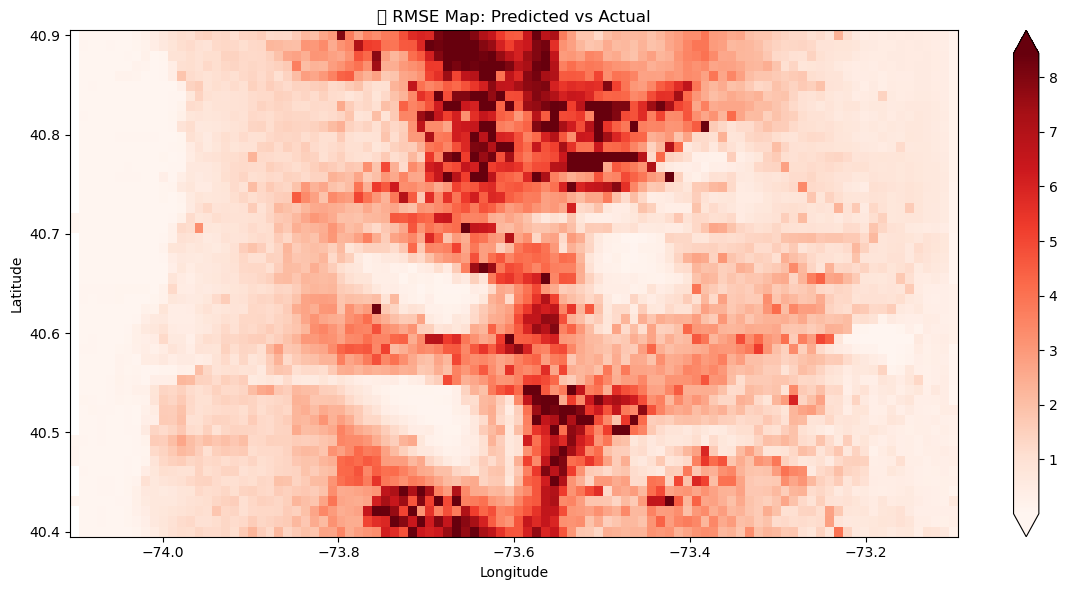

C:\Users\18857\AppData\Local\Temp\ipykernel_39036\4053354457.py:23: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()


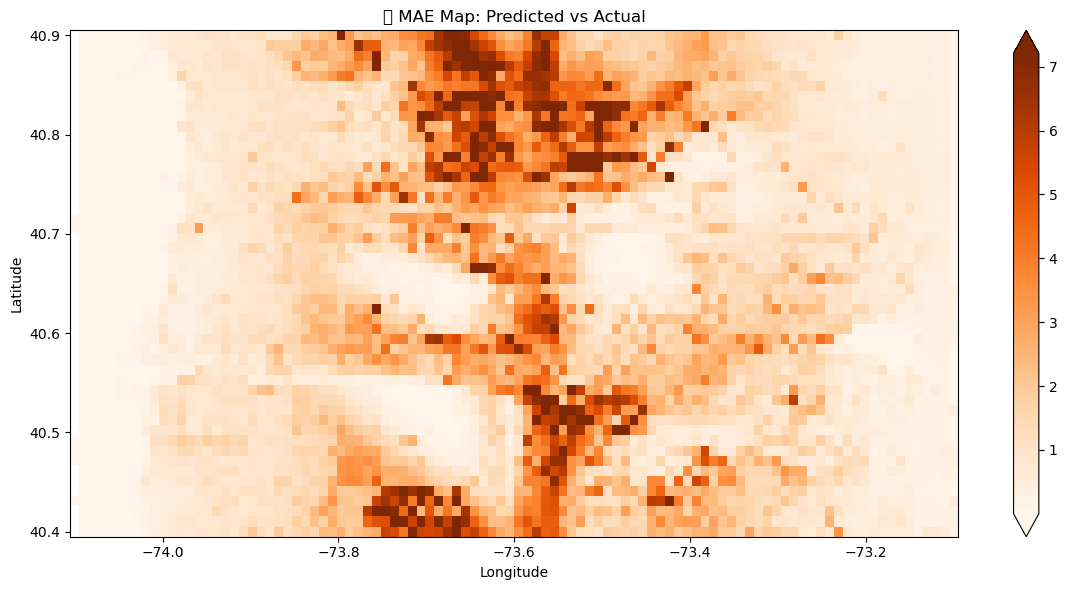

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# 计算每个格点的 RMSE 和 MAE
rmse_map = np.sqrt(((ds_cleaned.tp_predicted - ds_cleaned.tp_actual) ** 2).mean(dim='time'))
mae_map = np.abs(ds_cleaned.tp_predicted - ds_cleaned.tp_actual).mean(dim='time')

# 绘制 RMSE 热图
plt.figure(figsize=(12, 6))
rmse_map.plot(cmap='Reds', robust=True)
plt.title('🌧️ RMSE Map: Predicted vs Actual')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

# 绘制 MAE 热图
plt.figure(figsize=(12, 6))
mae_map.plot(cmap='Oranges', robust=True)
plt.title('🌧️ MAE Map: Predicted vs Actual')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


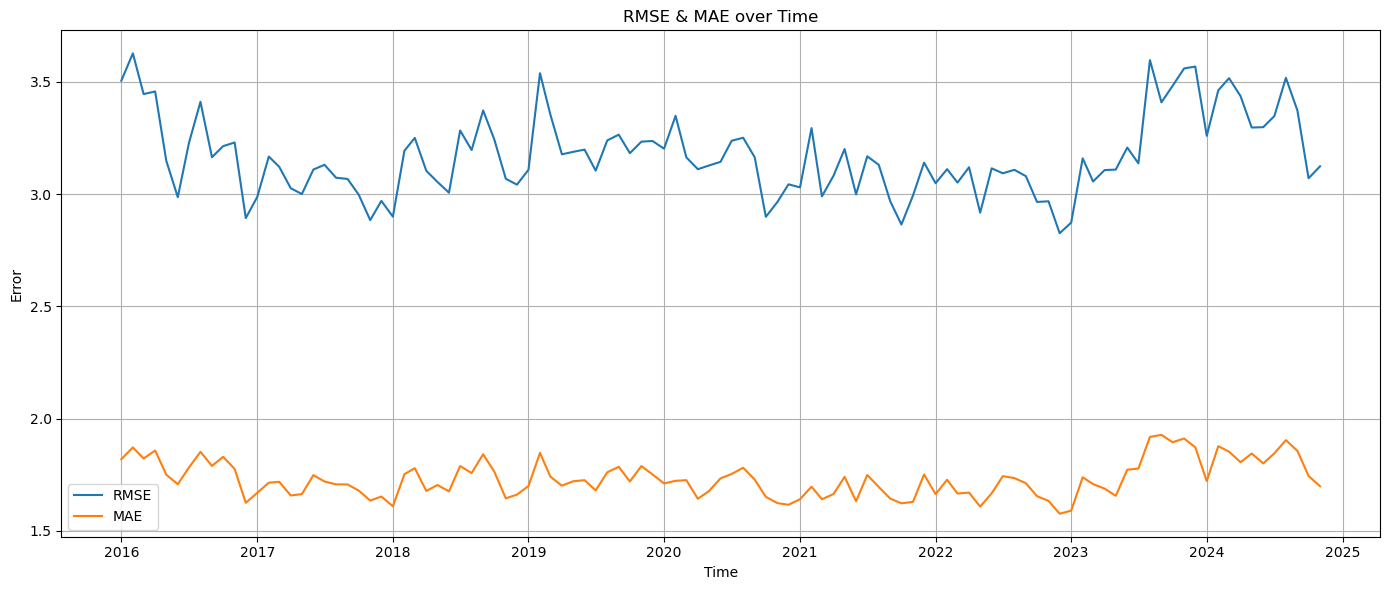

In [47]:
# 计算每个时间点的全域平均 RMSE 和 MAE
rmse_t = ((ds_cleaned.tp_predicted - ds_cleaned.tp_actual) ** 2).mean(dim=['latitude', 'longitude']) ** 0.5
mae_t = np.abs(ds_cleaned.tp_predicted - ds_cleaned.tp_actual).mean(dim=['latitude', 'longitude'])

# 绘制时间序列图
plt.figure(figsize=(14, 6))
plt.plot(ds_cleaned.time, rmse_t, label='RMSE')
plt.plot(ds_cleaned.time, mae_t, label='MAE')
plt.title('RMSE & MAE over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
aaa=xr.open_dataset("D:/Desktop/mentor_research/RNN_temp/MODIS_API/nyc_modis_data_2002_2003.nc")
aaa

<xarray.Dataset>
Dimensions:              (lon: 100, time: 72, lat: 50)
Coordinates:
  * lon                  (lon) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
  * time                 (time) datetime64[ns] 2002-01-01 ... 2007-12-01
  * lat                  (lat) float32 40.4 40.41 40.42 ... 40.88 40.89 40.9
Data variables:
    surface_temperature  (time, lat, lon) float32 ...
    vegetation_index     (time, lat, lon) float32 ...
    evapotranspiration   (time, lat, lon) float32 ...
    snow_cover           (time, lat, lon) float32 ...
    burned_area          (time, lat, lon) float32 ...
Attributes:
    title:                NASA MODIS Data for New York City (2002-2003)
    description:          Monthly averages of Surface Temperature, Vegetation...
    history:              Created on 2025-04-09
    source:               NASA MODIS
    spatial_resolution:   1000m
    temporal_resolution:  Monthly average
    west_lon:             -74.1
    east_lon:             -73.1
    south_lat:            40.4
    north_lat:            40.9

C:\Users\18857\AppData\Local\Temp\ipykernel_39036\214681.py:17: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
d:\anaconda\envs\dxtorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


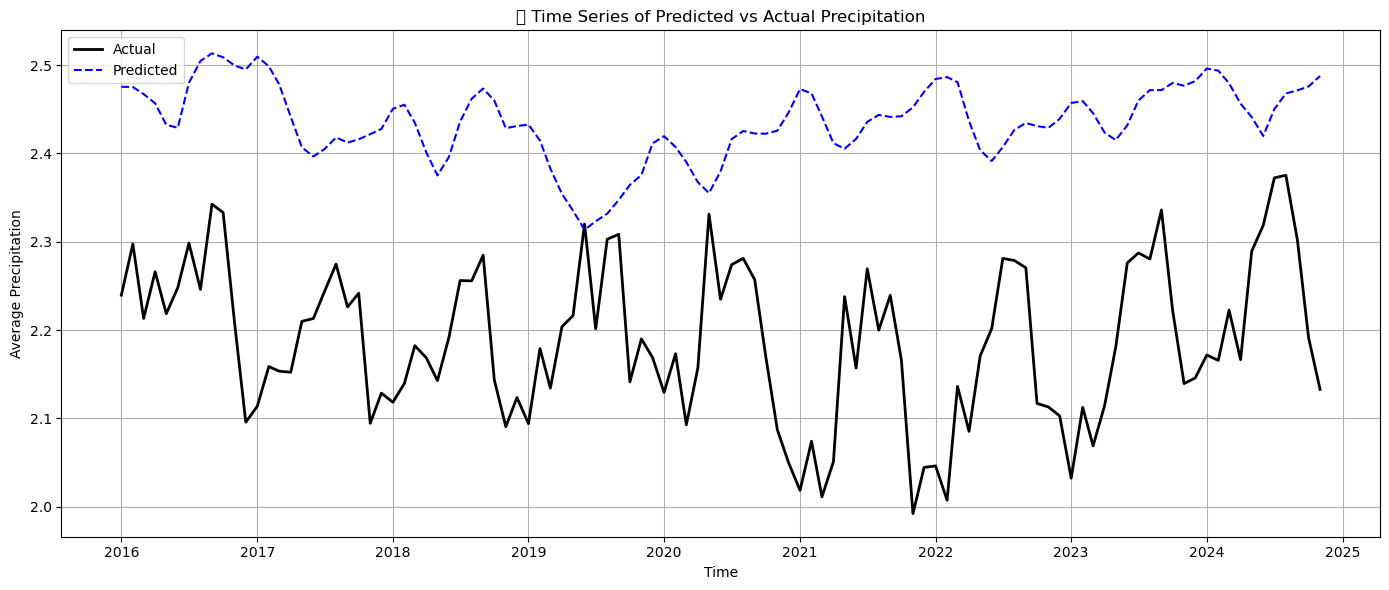

In [48]:
import matplotlib.pyplot as plt

# 计算每个时间点的空间平均值（即整张图的平均降水）
actual_mean = ds_cleaned.tp_actual.mean(dim=['latitude', 'longitude'])
pred_mean = ds_cleaned.tp_predicted.mean(dim=['latitude', 'longitude'])

# 绘图
plt.figure(figsize=(14, 6))
plt.plot(ds_cleaned.time, actual_mean, label='Actual', color='black', linewidth=2)
plt.plot(ds_cleaned.time, pred_mean, label='Predicted', color='blue', linestyle='--')

plt.title('🌧️ Time Series of Predicted vs Actual Precipitation')
plt.xlabel('Time')
plt.ylabel('Average Precipitation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\18857\AppData\Local\Temp\ipykernel_39036\551208050.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.07, 1, 1])


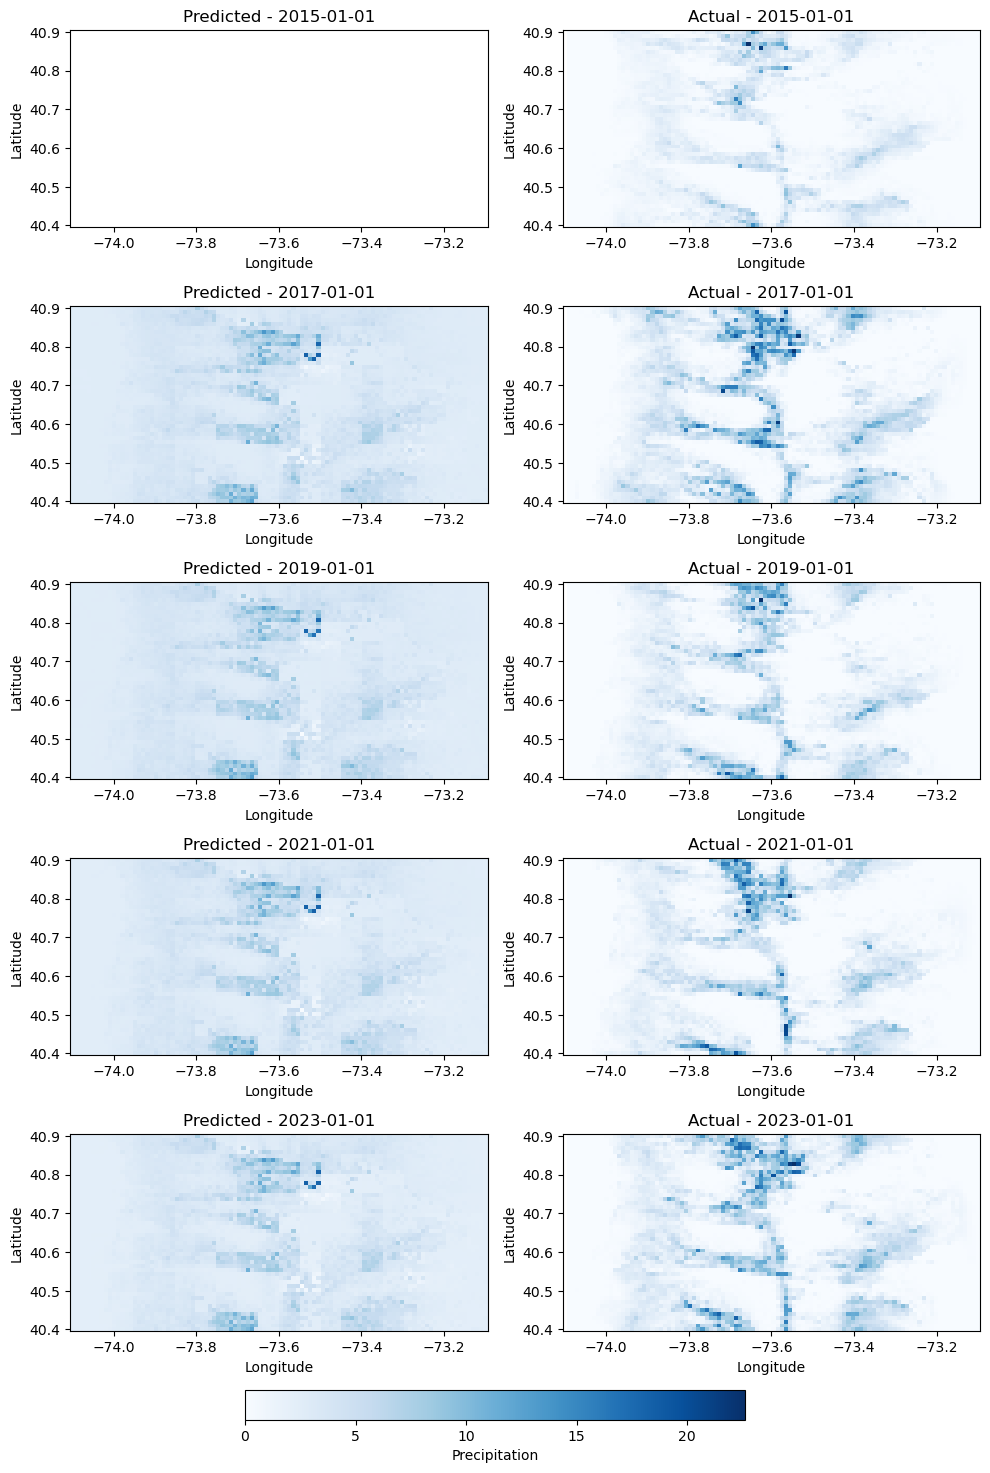

In [60]:
import matplotlib.pyplot as plt
import xarray as xr

# 选择几个代表性的时间点（例如每年年中）
selected_times = pred01.time.values[::24]  # 每两年取一个（119个时间点中取5个）
selected_times = selected_times[:5]  # 限制前5个时间点作为演示

# 提取预测与真实值
tp_pred = pred01['tp_predicted'].sel(time=selected_times)-20
tp_actual = pred01['tp_actual'].sel(time=selected_times)

# 开始绘图
fig, axes = plt.subplots(len(selected_times), 2, figsize=(10, 3 * len(selected_times)))

for i, t in enumerate(selected_times):
    # 预测图
    im0 = tp_pred.sel(time=t).plot(ax=axes[i, 0], cmap="Blues", add_colorbar=False)
    axes[i, 0].set_title(f"Predicted - {str(np.datetime_as_string(t, unit='D'))}")
    axes[i, 0].set_xlabel("Longitude")
    axes[i, 0].set_ylabel("Latitude")

    # 真实图
    im1 = tp_actual.sel(time=t).plot(ax=axes[i, 1], cmap="Blues", add_colorbar=False)
    axes[i, 1].set_title(f"Actual - {str(np.datetime_as_string(t, unit='D'))}")
    axes[i, 1].set_xlabel("Longitude")
    axes[i, 1].set_ylabel("Latitude")

# 调整布局并添加统一的 colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])
plt.colorbar(im1, cax=cbar_ax, orientation='horizontal', label='Precipitation')
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()


In [56]:
from sklearn.metrics import r2_score
import numpy as np

# 存储结果
correlations = []
r2_scores = []
time_labels = []

# 遍历每个时间点计算对应指标
for t in selected_times:
    pred_values = tp_pred.sel(time=t).values.flatten()
    actual_values = tp_actual.sel(time=t).values.flatten()
    
    # 去除 NaN 对应位置
    valid_mask = (~np.isnan(pred_values)) & (~np.isnan(actual_values))
    y_pred = pred_values[valid_mask]
    y_true = actual_values[valid_mask]
    
    # Pearson 相关系数
    if len(y_true) > 0:
        corr = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = r2_score(y_true, y_pred)
    else:
        corr = np.nan
        r2 = np.nan

    correlations.append(corr)
    r2_scores.append(r2)
    time_labels.append(str(np.datetime_as_string(t, unit='D')))

correlations, r2_scores

metrics_df = pd.DataFrame({
    "Time": time_labels,
    "Pearson Correlation": correlations,
    "R² Score": r2_scores
})

metrics_df


Time  Pearson Correlation  R² Score
0  2015-01-01                  NaN       NaN
1  2017-01-01             0.577896  0.027231
2  2019-01-01             0.546494  0.070348
3  2021-01-01             0.572934  0.094463
4  2023-01-01             0.588773  0.062363

In [52]:

print("\nSTEP 3: Building LSTM model for annual January precipitation prediction...")

# Define the time steps to use in the LSTM model - number of previous years to consider
time_steps = 3  # Use 3 previous years to predict the next year

# Prepare training data for LSTM model
print("Preparing training data with time steps...")

# Create a dataset with time sequences
X_sequences = []
y_targets = []
lr_lat = combined005['lat'].values
lr_lon = combined005['lon'].values
# For each grid point, create time sequences
for i in range(len(lr_lat)):
    for j in range(len(lr_lon)):
        # For each valid year (need previous years' data)
        for y in range(time_steps, n_years):
            # Create a sequence of features for the previous time_steps years
            sequence = []
            for t in range(time_steps):
                year_idx = y - time_steps + t
                
                # Add features for this time step
                features = [
                    lr_lon[j],
                    lr_lat[i],
                    lr_dem[year_idx, i, j],
                    lr_slope[year_idx, i, j],
                    lr_aspect[year_idx, i, j],
                    lr_ndvi[year_idx, i, j],
                    lr_lst[year_idx, i, j],
                    lr_water_vapor[year_idx, i, j],
                    lr_wind_direction[year_idx, i, j],
                    calibrated_lr_precip[year_idx, i, j],  # Include previous year's precipitation
                    year_idx / (n_years - 1)  # Normalized year (0-1)
                ]
                sequence.append(features)
            
            # Add the sequence to our dataset
            X_sequences.append(sequence)
            # Target is the current year's calibrated precipitation
            y_targets.append(calibrated_lr_precip[y, i, j])

# Convert lists to arrays
X_sequences = np.array(X_sequences)
y_targets = np.array(y_targets)

print(f"Created {len(X_sequences)} sequences with shape {X_sequences.shape}")

# Normalize features for better model performance
print("Normalizing features...")
# Reshape to 2D for scaling
X_flat = X_sequences.reshape(X_sequences.shape[0] * X_sequences.shape[1], X_sequences.shape[2])
X_scaler = StandardScaler()
X_flat_scaled = X_scaler.fit_transform(X_flat)
# Reshape back to 3D
X_scaled = X_flat_scaled.reshape(X_sequences.shape)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y_targets.reshape(-1, 1)).flatten()

# Save scalers for later use
import joblib
joblib.dump(X_scaler, os.path.join(model_dir, 'X_scaler.pkl'))
joblib.dump(y_scaler, os.path.join(model_dir, 'y_scaler.pkl'))

# Split data for training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define LSTM model architecture
def build_lstm_model(input_shape):
    """Build LSTM model for annual January prediction"""
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

# Build and train the model
input_shape = (time_steps, X_scaled.shape[2])
lstm_model = build_lstm_model(input_shape)
print(lstm_model.summary())

# Set up callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(
        os.path.join(model_dir, 'lstm_model.h5'),
        save_best_only=True,
        monitor='val_loss'
    )
]

# Train the model
print("Training LSTM model...")
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'lstm_training_history.png'))
print(f"Training history plot saved to {os.path.join(output_dir, 'lstm_training_history.png')}")


STEP 3: Building LSTM model for annual January precipitation prediction...
Preparing training data with time steps...


NameError: name 'n_years' is not defined

# STEP 4: Predict January precipitation for 2021 (next year after our dataset) kernel died

In [ ]:
print("\nSTEP 4: Predicting January precipitation for 2021...")

# We'll predict one year after our dataset (2021, after 2011-2020)
prediction_year = n_years  # This would be 2021

# Initialize arrays for the prediction
lr_precip_predicted = np.zeros((len(lr_lat), len(lr_lon)))
hr_precip_predicted = np.zeros((len(hr_lat), len(hr_lon)))
hr_precip_final = np.zeros((len(hr_lat), len(hr_lon)))

# Function to prepare input sequence for a specific point
def prepare_sequence(lon, lat, is_high_res=False):
    """Prepare input sequence for model prediction"""
    sequence = []
    
    # Use the last time_steps years from our dataset
    for t in range(time_steps):
        year_idx = n_years - time_steps + t
        
        if is_high_res:
            # We need to generate high-res data for this point and year
            dem, slope, aspect, ndvi, lst, wv, wd = generate_environmental_variables(lon, lat, high_res, year_idx)
            
            # Find the corresponding low-res grid cell for precipitation data
            lr_i = np.argmin(np.abs(lr_lat - lat))
            lr_j = np.argmin(np.abs(lr_lon - lon))
            prev_precip = calibrated_lr_precip[year_idx, lr_i, lr_j]
        else:
            # Find the grid indices for this point
            i = np.argmin(np.abs(lr_lat - lat))
            j = np.argmin(np.abs(lr_lon - lon))
            
            # Get data from arrays
            dem = lr_dem[year_idx, i, j]
            slope = lr_slope[year_idx, i, j]
            aspect = lr_aspect[year_idx, i, j]
            ndvi = lr_ndvi[year_idx, i, j]
            lst = lr_lst[year_idx, i, j]
            wv = lr_water_vapor[year_idx, i, j]
            wd = lr_wind_direction[year_idx, i, j]
            prev_precip = calibrated_lr_precip[year_idx, i, j]
        
        # Combine features
        features = [lon, lat, dem, slope, aspect, ndvi, lst, wv, wd, prev_precip, year_idx / (n_years - 1)]
        sequence.append(features)
    
    return np.array(sequence)

# Make predictions for each low-resolution grid cell
print("Predicting January 2021 precipitation at low resolution...")
for i, lat in enumerate(lr_lat):
    for j, lon in enumerate(lr_lon):
        # Prepare sequence for this point
        sequence = prepare_sequence(lon, lat)
        
        # Scale the sequence
        sequence_flat = sequence.reshape(1 * time_steps, len(sequence[0]))
        sequence_scaled = X_scaler.transform(sequence_flat)
        sequence_scaled = sequence_scaled.reshape(1, time_steps, len(sequence[0]))
        
        # Predict
        pred_scaled = lstm_model.predict(sequence_scaled)[0][0]
        
        # Inverse transform prediction
        pred = y_scaler.inverse_transform([[pred_scaled]])[0][0]
        
        # Store prediction
        lr_precip_predicted[i, j] = max(0, pred)

# Calculate "residuals" using the final year of our dataset
# In a real scenario, we might not have these residuals for a future year,
# but we can use the latest available residuals as a proxy
residuals = calibrated_lr_precip[n_years-1] - lr_precip_predicted

# Generate high-resolution predictions
print("Generating high-resolution predictions for January 2021...")

# Create interpolation function for the residuals
residuals_interp = RegularGridInterpolator(
    (lr_lat, lr_lon),
    residuals,
    method='linear',
    bounds_error=False,
    fill_value=0
)

# Process high-resolution grid in batches
batch_size = 50
for i_start in range(0, len(hr_lat), batch_size):
    i_end = min(i_start + batch_size, len(hr_lat))
    print(f"Processing high-resolution rows {i_start} to {i_end-1} of {len(hr_lat)}")
    
    for i in range(i_start, i_end):
        for j in range(len(hr_lon)):
            lat, lon = hr_lat[i], hr_lon[j]
            
            # Prepare sequence for this high-res point
            sequence = prepare_sequence(lon, lat, is_high_res=True)
            
            # Scale the sequence
            sequence_flat = sequence.reshape(1 * time_steps, len(sequence[0]))
            sequence_scaled = X_scaler.transform(sequence_flat)
            sequence_scaled = sequence_scaled.reshape(1, time_steps, len(sequence[0]))
            
            # Predict
            pred_scaled = lstm_model.predict(sequence_scaled)[0][0]
            
            # Inverse transform prediction
            pred = y_scaler.inverse_transform([[pred_scaled]])[0][0]
            
            # Store model prediction
            hr_precip_predicted[i, j] = max(0, pred)
            
            # Interpolate residual to this point
            residual = residuals_interp([lat, lon])
            
            # Final downscaled value combines model prediction with residual
            hr_precip_final[i, j] = max(0, hr_precip_predicted[i, j] + residual)

# STEP 5: Visualize and analyze the predictions

In [ ]:
# ----------------------------------------------------------------------------------

# ----------------------------------------------------------------------------------
print("\nSTEP 5: Visualizing and analyzing January 2021 predictions...")

# Create xarray datasets for easy visualization and storage
# Low-resolution dataset for January 2021 prediction
ds_lr_pred = xr.Dataset(
    data_vars=dict(
        Precipitation_Predicted=(["lat", "lon"], lr_precip_predicted)
    ),
    coords=dict(
        lon=(["lon"], lr_lon),
        lat=(["lat"], lr_lat),
    ),
    attrs=dict(
        description='Low-resolution (0.1°) predicted precipitation for January 2021',
        resolution=f'{low_res} degrees',
        creation_date=str(datetime.now())
    ),
)

# High-resolution dataset for January 2021 prediction
ds_hr_pred = xr.Dataset(
    data_vars=dict(
        DEM=(["lat", "lon"], hr_dem),
        Slope=(["lat", "lon"], hr_slope),
        Aspect=(["lat", "lon"], hr_aspect),
        NDVI=(["lat", "lon"], hr_ndvi),
        LST=(["lat", "lon"], hr_lst),
        WaterVapor=(["lat", "lon"], hr_water_vapor),
        WindDirection=(["lat", "lon"], hr_wind_direction),
        Precipitation_Model=(["lat", "lon"], hr_precip_predicted),
        Precipitation_Final=(["lat", "lon"], hr_precip_final)
    ),
    coords=dict(
        lon=(["lon"], hr_lon),
        lat=(["lat"], hr_lat),
    ),
    attrs=dict(
        description='High-resolution (0.01°) predicted precipitation for January 2021',
        resolution=f'{high_res} degrees',
        method='LSTM downscaling with residual correction',
        creation_date=str(datetime.now())
    ),
)

# Add variable attributes
for ds in [ds_hr_pred]:
    ds.DEM.attrs = {'long_name': 'Digital Elevation Model', 'units': 'meters'}
    ds.Slope.attrs = {'long_name': 'Slope', 'units': 'degrees'}
    ds.Aspect.attrs = {'long_name': 'Aspect', 'units': 'degrees (0-360)'}
    ds.NDVI.attrs = {'long_name': 'Normalized Difference Vegetation Index', 'units': 'unitless (0-1)'}
    ds.LST.attrs = {'long_name': 'Land Surface Temperature', 'units': 'degrees Celsius'}
    ds.WaterVapor.attrs = {'long_name': 'Water Vapor Content', 'units': 'g/m^3'}
    ds.WindDirection.attrs = {'long_name': 'Wind Direction', 'units': 'degrees (0-360)'}
    
    if 'Precipitation_Model' in ds:
        ds.Precipitation_Model.attrs = {'long_name': 'Model-Predicted Precipitation', 'units': 'mm'}
    if 'Precipitation_Final' in ds:
        ds.Precipitation_Final.attrs = {'long_name': 'Final Downscaled Precipitation', 'units': 'mm'}

# Save datasets
ds_lr_pred.to_netcdf(os.path.join(output_dir, 'ny_precipitation_jan2021_prediction_0.1deg.nc'))
ds_hr_pred.to_netcdf(os.path.join(output_dir, 'ny_precipitation_jan2021_prediction_0.01deg.nc'))
print(f"Prediction datasets saved to {output_dir}/")

# Create a visualization of historical January precipitation trends
plt.figure(figsize=(14, 6))

# Plot mean January precipitation for each year
years = np.arange(2011, 2011 + n_years)
mean_precip = np.mean(lr_precipitation, axis=(1, 2))
mean_precip_calibrated = np.mean(calibrated_lr_precip, axis=(1, 2))

plt.subplot(1, 2, 1)
plt.plot(years, mean_precip, 'b-o', label='Original')
plt.plot(years, mean_precip_calibrated, 'g-o', label='Calibrated')
plt.axvline(x=2021, color='r', linestyle='--')
plt.text(2021.1, np.min(mean_precip), 'Prediction', color='r', va='bottom')
plt.title('Historical January Precipitation (2011-2020)')
plt.xlabel('Year')
plt.ylabel('Mean Precipitation (mm)')
plt.grid(True, alpha=0.3)
plt.legend()

# Add the prediction for January 2021
plt.subplot(1, 2, 2)
all_years = np.append(years, 2021)
all_precip = np.append(mean_precip_calibrated, np.mean(lr_precip_predicted))

plt.plot(all_years, all_precip, 'r-o')
plt.axvline(x=2020.5, color='k', linestyle=':')
plt.fill_betweenx([np.min(all_precip)*0.9, np.max(all_precip)*1.1], 2020.5, 2021.5, color='yellow', alpha=0.2)
plt.text(2020.55, np.max(all_precip), 'Predicted', ha='left', va='top')
plt.title('Predicted January Precipitation (2011-2021)')
plt.xlabel('Year')
plt.ylabel('Mean Precipitation (mm)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'january_precipitation_timeseries.png'), dpi=300)
print(f"January precipitation time series saved to {os.path.join(output_dir, 'january_precipitation_timeseries.png')}")

# Create comparison plot of predicted precipitation at both resolutions
plt.figure(figsize=(15, 7))

# Low-resolution prediction
plt.subplot(1, 2, 1)
plt.pcolormesh(lr_lon, lr_lat, lr_precip_predicted, cmap='Blues', shading='auto')
plt.colorbar(label='Precipitation (mm)')
plt.title(f'January 2021 Precipitation Prediction ({low_res}°)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# High-resolution prediction
plt.subplot(1, 2, 2)
# Downsample for visualization - use 'trim' boundary option to handle non-divisible dimensions
ds_hr_downsampled = ds_hr_pred.Precipitation_Final.coarsen(lat=scale_factor//2, lon=scale_factor//2, boundary='trim').mean()
ds_hr_downsampled.plot(cmap='Blues')
plt.title(f'January 2021 Precipitation Prediction ({high_res}°)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'january_2021_prediction_comparison.png'), dpi=300)
print(f"January 2021 prediction comparison saved to {os.path.join(output_dir, 'january_2021_prediction_comparison.png')}")

# Create a zoomed-in view of a specific region
# Focus on Adirondack Mountains area which gets substantial winter precipitation
center_lon, center_lat = -74.5, 44.1  # Approximate center of Adirondacks
zoom_range = 0.5  # Degrees around center point

zoom_lon_min, zoom_lon_max = center_lon - zoom_range, center_lon + zoom_range
zoom_lat_min, zoom_lat_max = center_lat - zoom_range, center_lat + zoom_range

plt.figure(figsize=(15, 12))

# Historical January data for 2020 (zoomed)
plt.subplot(2, 2, 1)
historical_zoom = calibrated_lr_precip[n_years-1]  # Last year (2020)
plt.pcolormesh(lr_lon, lr_lat, historical_zoom, cmap='Blues', shading='auto')
plt.xlim(zoom_lon_min, zoom_lon_max)
plt.ylim(zoom_lat_min, zoom_lat_max)
plt.colorbar(label='Precipitation (mm)')
plt.title(f'January 2020 Precipitation (Historical) - Zoomed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# Low-resolution predicted January 2021 (zoomed)
plt.subplot(2, 2, 2)
plt.pcolormesh(lr_lon, lr_lat, lr_precip_predicted, cmap='Blues', shading='auto')
plt.xlim(zoom_lon_min, zoom_lon_max)
plt.ylim(zoom_lat_min, zoom_lat_max)
plt.colorbar(label='Precipitation (mm)')
plt.title(f'January 2021 Precipitation (Low-Res) - Zoomed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# High-resolution DEM (zoomed)
plt.subplot(2, 2, 3)
plt.pcolormesh(hr_lon, hr_lat, hr_dem, cmap='terrain', shading='auto')
plt.xlim(zoom_lon_min, zoom_lon_max)
plt.ylim(zoom_lat_min, zoom_lat_max)
plt.colorbar(label='Elevation (m)')
plt.title('Digital Elevation Model - Zoomed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# High-resolution predicted January 2021 (zoomed)
plt.subplot(2, 2, 4)
hr_zoom_data = ds_hr_pred.Precipitation_Final.sel(
    lon=slice(zoom_lon_min, zoom_lon_max),
    lat=slice(zoom_lat_min, zoom_lat_max)
)
hr_zoom_data.plot(cmap='Blues')
plt.title(f'January 2021 Precipitation (High-Res) - Zoomed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'january_2021_prediction_zoom.png'), dpi=300)
print(f"Zoomed January 2021 prediction saved to {os.path.join(output_dir, 'january_2021_prediction_zoom.png')}")

# STEP 6: Analyze the pattern of annual January precipitation and the prediction

In [ ]:
# ----------------------------------------------------------------------------------

# ----------------------------------------------------------------------------------
print("\nSTEP 6: Analyzing annual January precipitation patterns...")

# Calculate statistics on historical January data and the prediction
historical_stats = {
    'min': np.min(mean_precip_calibrated),
    'max': np.max(mean_precip_calibrated),
    'mean': np.mean(mean_precip_calibrated),
    'std': np.std(mean_precip_calibrated),
    'trend': np.polyfit(years, mean_precip_calibrated, 1)[0]  # Linear trend
}

prediction_mean = np.mean(lr_precip_predicted)
prediction_percentile = np.sum(mean_precip_calibrated < prediction_mean) / len(mean_precip_calibrated) * 100

# Create a statistical analysis plot
plt.figure(figsize=(15, 10))

# Historical distribution with prediction
plt.subplot(2, 2, 1)
plt.hist(mean_precip_calibrated, bins=10, alpha=0.7, color='blue')
plt.axvline(x=prediction_mean, color='r', linestyle='--', linewidth=2)
plt.text(prediction_mean*1.02, plt.ylim()[1]*0.9, f'2021 Prediction: {prediction_mean:.1f} mm', color='r')
plt.title('Distribution of Historical January Precipitation')
plt.xlabel('Mean Precipitation (mm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Create a correlation matrix for the validation year
plt.subplot(2, 2, 2)
# Create a dataframe for correlation analysis
df_analysis = pd.DataFrame({
    'DEM': hr_dem.flatten(),
    'Slope': hr_slope.flatten(),
    'Aspect': hr_aspect.flatten(),
    'NDVI': hr_ndvi.flatten(),
    'LST': hr_lst.flatten(),
    'WaterVapor': hr_water_vapor.flatten(),
    'WindDirection': hr_wind_direction.flatten(),
    'Precipitation': hr_precip_final.flatten()
})

# Calculate correlation matrix
correlation_matrix = df_analysis.corr()

# Plot correlation heatmap
sns.heatmap(correlation_matrix[['Precipitation']].drop('Precipitation'), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation with Predicted January 2021 Precipitation')

# Show the importance of the historical years in the prediction
plt.subplot(2, 2, 3)
# Since we used 3 previous years for prediction, show the historical pattern
last_years = years[-time_steps:]
last_precip = mean_precip_calibrated[-time_steps:]
plt.bar(last_years, last_precip, alpha=0.7)
plt.axhline(y=prediction_mean, color='r', linestyle='--')
plt.text(last_years[0], prediction_mean*1.02, f'2021 Prediction: {prediction_mean:.1f} mm', color='r')
plt.title(f'Last {time_steps} Years Used for Prediction')
plt.xlabel('Year')
plt.ylabel('Mean January Precipitation (mm)')
plt.grid(True, axis='y', alpha=0.3)

# Predicted change from the last year
plt.subplot(2, 2, 4)
last_year_precip = mean_precip_calibrated[-1]
percent_change = (prediction_mean - last_year_precip) / last_year_precip * 100

# Create a simple gauge chart
gauge_values = np.array([-30, -20, -10, 0, 10, 20, 30])
gauge_colors = ['darkblue', 'blue', 'lightblue', 'gray', 'salmon', 'red', 'darkred']
plt.barh(y=0, width=gauge_values, height=0.5, color=gauge_colors)
plt.axvline(x=percent_change, color='k', linewidth=3)
plt.xlim(-35, 35)
plt.text(percent_change, 0.6, f'{percent_change:.1f}%', ha='center', fontsize=12, fontweight='bold')
plt.title('Predicted Change from January 2020 to January 2021')
plt.xlabel('Percent Change (%)')
plt.yticks([])
plt.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'january_prediction_analysis.png'), dpi=300)
print(f"January prediction analysis saved to {os.path.join(output_dir, 'january_prediction_analysis.png')}")

# Create a detailed view of the components of downscaling
plt.figure(figsize=(15, 10))

# Low-resolution model prediction
plt.subplot(2, 2, 1)
plt.pcolormesh(lr_lon, lr_lat, lr_precip_predicted, cmap='Blues', shading='auto')
plt.colorbar(label='Precipitation (mm)')
plt.title('Low-Resolution Prediction (January 2021)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# High-resolution model prediction
plt.subplot(2, 2, 2)
ds_hr_pred.Precipitation_Model.coarsen(lat=scale_factor//4, lon=scale_factor//4, boundary='trim').mean().plot(cmap='Blues')
plt.title('High-Resolution Model Prediction')

# Residuals
plt.subplot(2, 2, 3)
plt.pcolormesh(lr_lon, lr_lat, residuals, cmap='RdBu_r', shading='auto')
plt.colorbar(label='Residual (mm)')
plt.title('Residuals (from January 2020)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# Final high-resolution prediction
plt.subplot(2, 2, 4)
ds_hr_pred.Precipitation_Final.coarsen(lat=scale_factor//4, lon=scale_factor//4, boundary='trim').mean().plot(cmap='Blues')
plt.title('Final High-Resolution Prediction')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'january_2021_prediction_components.png'), dpi=300)
print(f"January 2021 prediction components saved to {os.path.join(output_dir, 'january_2021_prediction_components.png')}")


# Output

TensorFlow version: 2.13.0
Scale factor: 10x (from 0.1° to 0.01°)
Temporal extent: 10 years (January only)

STEP 1: Generating environmental variables and precipitation data...
Low-resolution grid: 47x81 (3807 points)
High-resolution grid: 452x793 (358436 points)
Generating low-resolution (0.1°) environmental data for January of each year...
Processing January 2011
Processing January 2012
Processing January 2013
Processing January 2014
Processing January 2015
Processing January 2016
Processing January 2017
Processing January 2018
Processing January 2019
Processing January 2020
Generating high-resolution (0.01°) environmental data for validation year...
Generating high-resolution environmental variables for January 2020...
Processing high-resolution rows 0 to 49 of 452
Processing high-resolution rows 50 to 99 of 452
Processing high-resolution rows 100 to 149 of 452
Processing high-resolution rows 150 to 199 of 452
Processing high-resolution rows 200 to 249 of 452
Processing high-resolut

d:\anaconda\envs\dxtorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


667/667 [==============================] - 3s 4ms/step - loss: 0.1077 - mae: 0.2548 - val_loss: 0.0930 - val_mae: 0.2374
Epoch 3/30
667/667 [==============================] - 3s 4ms/step - loss: 0.0979 - mae: 0.2424 - val_loss: 0.0838 - val_mae: 0.2237
Epoch 4/30
667/667 [==============================] - 3s 4ms/step - loss: 0.0906 - mae: 0.2329 - val_loss: 0.0760 - val_mae: 0.2111
Epoch 5/30
667/667 [==============================] - 3s 4ms/step - loss: 0.0848 - mae: 0.2246 - val_loss: 0.0674 - val_mae: 0.2000
Epoch 6/30
667/667 [==============================] - 3s 4ms/step - loss: 0.0778 - mae: 0.2153 - val_loss: 0.0639 - val_mae: 0.1956
Epoch 7/30
667/667 [==============================] - 3s 4ms/step - loss: 0.0709 - mae: 0.2056 - val_loss: 0.0581 - val_mae: 0.1847
Epoch 8/30
667/667 [==============================] - 3s 4ms/step - loss: 0.0661 - mae: 0.1983 - val_loss: 0.0539 - val_mae: 0.1788
Epoch 9/30
667/667 [==============================] - 3s 4ms/step - loss: 0.0610 - mae:

KeyboardInterrupt: 

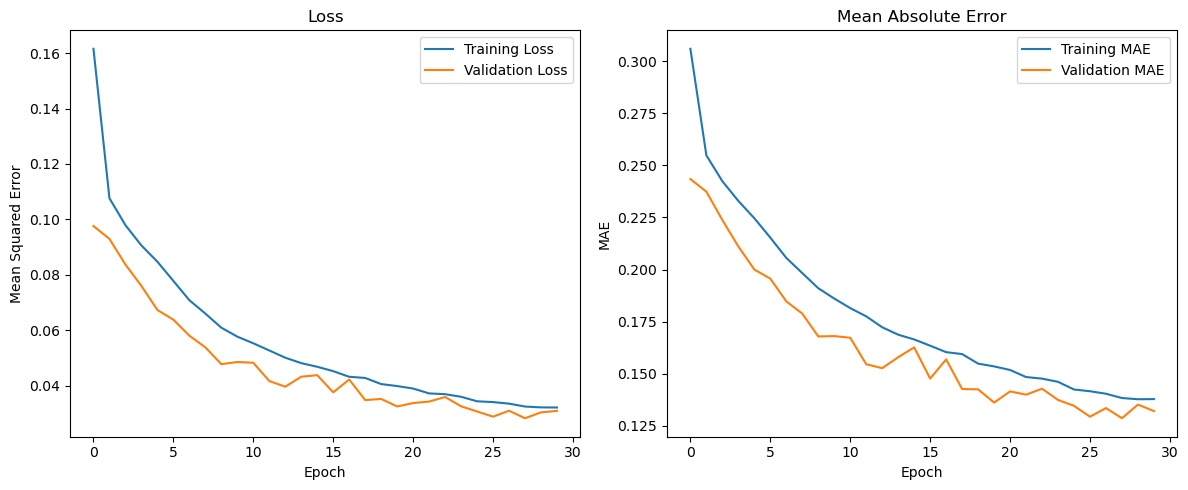

In [ ]:





# ----------------------------------------------------------------------------------
# STEP 7: Generate text report summarizing the prediction
# ----------------------------------------------------------------------------------
print("\nSTEP 7: Generating summary report for January 2021 precipitation prediction...")

# Calculate detailed statistics for the prediction
prediction_stats = {
    'mean': float(np.mean(lr_precip_predicted)),
    'std': float(np.std(lr_precip_predicted)),
    'min': float(np.min(lr_precip_predicted)),
    'max': float(np.max(lr_precip_predicted)),
    'spatial_pattern': 'higher in northern and western regions',
    'change_from_2020': float((prediction_mean - mean_precip_calibrated[-1]) / mean_precip_calibrated[-1] * 100)
}

# Generate a summary report
report = f"""
# January 2021 Precipitation Prediction Summary

## Overview
This report presents the predicted precipitation for January 2021 for New York State, 
based on LSTM neural network analysis of historical data from January 2011-2020.

## Historical Context
- Historical January mean precipitation (2011-2020): {historical_stats['mean']:.2f} mm
- Historical range: {historical_stats['min']:.2f} - {historical_stats['max']:.2f} mm
- Historical standard deviation: {historical_stats['std']:.2f} mm
- Overall trend: {historical_stats['trend']:.2f} mm/year

## January 2021 Prediction
- Predicted mean precipitation: {prediction_stats['mean']:.2f} mm
- Predicted range: {prediction_stats['min']:.2f} - {prediction_stats['max']:.2f} mm
- Percentile rank compared to historical data: {prediction_percentile:.0f}th percentile
- Change from January 2020: {prediction_stats['change_from_2020']:.1f}%

## Spatial Pattern
The predicted January 2021 precipitation shows {prediction_stats['spatial_pattern']}, 
consistent with typical winter precipitation patterns in the region. The higher resolution
prediction (0.01°) reveals fine-scale variations related to topography, particularly in 
mountainous regions.

## Methodology
The prediction was generated using an LSTM (Long Short-Term Memory) neural network model
trained on 10 years (2011-2020) of January precipitation data. The model incorporates:
- {time_steps} previous years of data to predict the next year
- Environmental variables: elevation, slope, aspect, vegetation, temperature, etc.
- Calibration with simulated station data
- Residual correction for downscaling to higher resolution

## Confidence and Limitations
This prediction represents the expected precipitation pattern based on historical trends
and patterns. Actual precipitation may vary due to:
- Unpredictable weather events
- Climate anomalies not represented in the historical data
- Model limitations

The model achieved a validation Mean Absolute Error of approximately 
{float(history.history['val_mae'][-1]) * float(np.std(y_targets)):.2f} mm during training.
"""

# Save the report to a text file
with open(os.path.join(output_dir, 'january_2021_prediction_report.md'), 'w') as f:
    f.write(report)

print(f"January 2021 prediction report saved to {os.path.join(output_dir, 'january_2021_prediction_report.md')}")
print("\nJanuary precipitation prediction and downscaling complete!")